In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import skimage
from skimage.feature import canny
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, rotate
import math
from scipy import ndimage
from matplotlib.path import Path

smart content aware noise removal could be one idea to improve.
working fine all images.
gaussianblur inbuilt works only on even window sizes

In [2]:
def find_scan_screenshot(img):
    # return 0 for scan/screenshot and 1 for photograph
    total_pixels = img.shape[0]*img.shape[1]
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    prop = np.sum(hist[15:241])/total_pixels
    if prop<0.1:
        return 0
    else:
        return 1

In [3]:
def binarization_scans(img):
    # using inbuilt otsu's method..Implement later
    _,im = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return im
#handle very small images later 
def binarization_photos(img):
    high_res = 0
    if img.size>2000*1000:
        high_res = 1
    
    if high_res==1:
        img = cv2.GaussianBlur(img,(9,9),3) # fails for even
    
    window_size = int(min(img.shape[0],img.shape[1])/60)
    if window_size%2==0:
        window_size+=1 #cv2.adaptiveThreshold accepts only odd window sizes
    
    thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,window_size,10)
    return thresh_img

def morph_proc(img):
    img = 255 - img
    img[img==255] = 1
    kernel = np.ones((3,3))
    kernel1 = np.ones((5,5))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) 
    closed = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel) 
#     filled = cv2.morphologyEx(closed, cv2.MORPH_DILATE, kernel1) 
    fin_img = cv2.morphologyEx(closed, cv2.MORPH_DILATE, kernel1) 
#     hole_size = int(0.0005 * img.shape[0] * img.shape[1])
#     fin_img = remove_small_holes(fin_img, area_threshold=hole_size)
    fin_img[fin_img==1] = 255
    return 255 - fin_img

In [4]:
def binarize_input(img):
    img_type = find_scan_screenshot(img)
    if img_type==0:
        print("Scan/Screenshot")
    else:
        print("Photograph")
    if img_type==0:
        new_img = binarization_scans(img)
    else:
        new_img = binarization_photos(img)
        new_img = morph_proc(new_img)
    return new_img

In [5]:
def remove_small_noise(img):
    img[img==255] = 1
    hole_size = int(0.0005 * img.shape[0] * img.shape[1])
    new_img = remove_small_holes(img, area_threshold=hole_size)
    new_img[new_img==1] = 255
    return 255-new_img

In [6]:
# directory = "../input/"
# for filename in os.listdir("../input/"):
#     try:
#         img_name = os.path.join(directory, filename)
#         print(img_name)
#         img = cv2.imread(img_name,0)
#         plt.imshow(img,cmap='gray')
#         plt.show()
#         new_img = binarize_input(img)
#         plt.imshow(new_img,cmap='gray')
#         plt.show()
#     except :
#         pass
    
# remove very small images maybe based on area after connected comp analysis

In [7]:
def skew_correction(img):
    neg_img = 255 - img
#     print("skew_correction")
    
    img_edges = canny(neg_img, sigma=7)
#     plt.imshow(img_edges,cmap='gray')
#     plt.show()
    h, theta, d = hough_line(img_edges)
    h, theta, d = hough_line_peaks(h, theta, d, min_distance=0, min_angle=0, num_peaks=4)
    theta = [int(np.round(math.degrees(i))) for i in theta]    
    print(theta)

    dom_orient = max(theta)
    deskewing_angle = dom_orient - 90

    while abs(deskewing_angle) > 45: 
        deskewing_angle = deskewing_angle - (abs(deskewing_angle)/deskewing_angle) * 90

    print(deskewing_angle)
#     deskew_img = skimage.transform.rotate(neg_img, deskewing_angle, resize=True, cval=1, mode ='constant')
    deskew_img = skimage.transform.rotate(neg_img, deskewing_angle, mode='constant', cval=0, preserve_range=True, clip=True)
    
    deskew_img = 255-deskew_img
    return deskew_img.astype(np.uint8)

In [8]:
# directory = "../input/"
# for filename in os.listdir("../input/"):
#     try:
#         img_name = os.path.join(directory, filename)
#         img = cv2.imread(img_name,0)
#         plt.imshow(img,cmap="gray")
#         plt.show()
#         plt.imshow(skew_correction(binarize_input(img)),cmap="gray")
#         plt.show()
#     except:
#         pass
# img = cv2.imread("../input/eq5_hr.jpg",0)
# new_img = binarize_input(img)
# img_rotated = skew_correction(new_img)
# plt.imshow(im,cmap='gray')

In [9]:
# img = cv2.imread("../input/eq5_hr.jpg",0)
# plt.imshow(img,cmap='gray')
# plt.show()
# new_img = binarize_input(img)
# img_rotated = skew_correction(new_img)
# plt.imshow(img_rotated,cmap='gray')
# plt.show()

In [10]:
def check_contains(bbox1, bbox2): 
    '''check if bbox2 is contained in bbox1'''
    if (bbox1[0]<bbox2[0]) and (bbox1[2]>bbox2[2]) and (bbox1[1]<bbox2[1]) and (bbox1[3]>bbox2[3]):
        return True
    return False
    

In [11]:
def segmentation(im):
#     plt.imshow(im,cmap='gray')
#     plt.show()
    neg_im = 255-im
    kernel = np.ones((3,3), np.uint8) 
    neg_im_erosion = cv2.erode(neg_im, kernel, iterations=1) 
#     edge_map = np.logical_xor(neg_im,neg_im_erosion)
    edge_map = neg_im_erosion # change to above
#     print('edge map')
#     plt.imshow(edge_map,cmap="gray")
#     plt.show()
    labels = skimage.measure.label(edge_map, connectivity=2) #connectivity-2 => neighbours 8
    reg = skimage.measure.regionprops(labels)
#     print(len(reg))
    bboxs = [i.bbox for i in reg] #min_row, min_col, max_row, max_col
    centroids = [i.centroid for i in reg]
    convex_hulls = [i.convex_image for i in reg]
    imgs = [i.image for i in reg]
    ign_ind = []
    # checking if bounding box is contained, need to change to, convex hull being contained - vivek
#     need to add additional check with edge map
    for i in range(0,len(bboxs)): #checks if 'j' is contained in 'i'
        for j in range(0,len(bboxs)):
            if bboxs[i]==bboxs[j]:
                continue
            
            contains = check_contains(bboxs[i],bboxs[j])
            if contains:
                ign_ind.append(j)
                
    
#     for i in ign_ind:
#         print(bboxs[i])
#         plt.imshow(im[bboxs[i][0]:bboxs[i][2],bboxs[i][1]:bboxs[i][3]],cmap='gray')
#         plt.show()
#     plt.imshow(imgs[i],cmap=plt.cm.gnuplot)
    centroids_new = []
    bboxs_new = []
    convex_hulls_new = []
    imgs_new = []
    imgs_sizes = []
    for i in range(0,len(imgs)):
        if i in ign_ind:
#             print(i,"hai")
            continue
        elif imgs[i].size<1000: #theshold of 1000 on segmented part sizes to get rid of extra noisy stuff
            continue
        centroids_new.append(centroids[i])
        bboxs_new.append(bboxs[i])
        convex_hulls_new.append(convex_hulls[i])
        imgs_new.append(imgs[i])
        imgs_sizes.append(imgs[i].size)
#         plt.imshow(imgs[i],cmap="gray")
#         plt.show()
    
    imgs_sizes = np.sort(imgs_sizes)
    print(imgs_sizes)
    return centroids_new, bboxs_new, convex_hulls_new, imgs_new

In [12]:
# img = cv2.imread("../input/eq5_hr.jpg",0)
# plt.imshow(img,cmap='gray')
# plt.show()
# new_img = binarize_input(img)
# img_rotated = skew_correction(new_img)
# plt.imshow(img_rotated,cmap='gray')
# plt.show()
# centroids, bboxs, convex_hulls,imgs = segmentation(img_rotated)
# centroids_new = []
# for i in range(0, len(imgs)):
#     plt.imshow(imgs[i],cmap='gray')
#     centrs = [centroids[i][0],centroids[i][1]]
#     centrs[0]-=bboxs[i][0]
#     centrs[1]-=bboxs[i][1]
#     print(centrs)
#     centroids_new.append(centrs)
#     plt.show()

In [13]:
def create_identifier(img,centroid):
#     print("maxi:",np.max(img))
#     img = ~img
#     plt.imshow(img,cmap='gray')
#     plt.show()
    #assuming that the character pixels in the paper means those pixels belonging to character
    id_profile = np.zeros(22)
    mom_inertia = 0
    char_count = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if img[i,j] != 0:
                char_count+=1
                mom_inertia+=(i-centroid[0])**2+(j-centroid[1])**2
    mom_inertia/=(char_count**2)
    id_profile[0] = mom_inertia
    img[img==255] = 1
    mu00 = central_moments(img,0,0)
    etas = np.zeros((4,4))
    for p in range(0,4):
        for q in range(0,4):
            if p+q<=3:
                gamma = 1 + (p+q)/2
                etas[p,q] = central_moments(img,p,q)/(mu00**gamma)

    hu2 = (etas[2,0] - etas[0,2])**2 + (4*etas[1,1]**2)
    hu3 = (etas[3,0] - 3*etas[1,2])**2 + (3*etas[2,1] - etas[0,3])**2
    hu4 = (etas[3,0] + etas[1,2])**2 + (etas[2,0] + etas[0,3])**2
    hu5 = (etas[3,0] - 3*etas[1,2])*(etas[3,0] + etas[1,2])*((etas[3,0] + etas[1,2])**2 - 3*((etas[2,1] + etas[0,3])**2)) + (3*(etas[2,1] - etas[0,3]))*(etas[2,1] + etas[0,3])*(3*(etas[3,0] + etas[1,2])**2 - (etas[2,1] + etas[0,3])**2)
    hu6 = (etas[2,0] - etas[0,2])*((etas[3,0]+etas[1,2])**2 - (etas[2,1]+ etas[0,3])**2) + 4*etas[1,1]*((etas[3,0] + etas[1,2])*(etas[2,1] + etas[0,3]))
    hu7 = (3*etas[2,1] - etas[0,3])*(etas[3,0] + etas[1,2])*((etas[3,0] + etas[1,2])**2 - 3*(etas[2,1]-etas[0,3])**2) - (etas[3,0] - 3*etas[1,2])*(etas[2,1] + etas[0,3])*(3*(etas[3,0] + etas[1,2])**2 - (etas[2,1] + etas[0,3])**2)
    id_profile[16] = hu2
    id_profile[17] = hu3
    id_profile[18] = hu4
    id_profile[19] = hu5
    id_profile[20] = hu6
    id_profile[21] = hu7
    id_profile[1:16] = get_circular_topology(img,centroid)
    return id_profile

In [14]:
def central_moments(img, p, q):
    img[img==255] = 1
    M00 = 0 
    M10 = 0
    M01 = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            M00+=img[i,j]
            M10+=i*img[i,j]
            M01+=j*img[i,j]
    
    x_bar = np.floor(float(M10)/float(M00))
    y_bar = np.floor(float(M01)/float(M00))
    
    cen_mmt = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            cen_mmt += ((i-x_bar)**p)*((j-y_bar)**q)*img[i,j]
            
    return cen_mmt

In [15]:
def create_new_centroids(centroids,bboxs,ims):
    centroids_new = []
    for i in range(0, len(ims)):
#         plt.imshow(ims[i],cmap='gray')
        centrs = [centroids[i][0],centroids[i][1]]
        centrs[0]-=bboxs[i][0]
        centrs[1]-=bboxs[i][1]
        print(centrs)
        centroids_new.append(centrs)
#         plt.show()
    return centroids_new

In [96]:
def ang_dist(xx,yy):
    lis = [] 
    for x,y in zip(xx,yy):
        delta = np.abs(x-y)
        if delta > np.pi:
            delta = 2*np.pi-delta 
        lis.append(delta)
    return max(lis)
def circular_mask(img,centroid,radius):
    lastx,lasty = -10,-10
    last = 0
    count = 0
    cut_angles = []
    img = img.astype(np.uint8)
    angle = np.linspace(0,2*np.pi,3600)
    circle_x = np.rint(centroid[0]+radius*np.cos(angle)).astype(np.int64)
    circle_y = np.rint(centroid[1]+radius*np.sin(angle)).astype(np.int64)  
    for x,y,theta in zip(circle_x,circle_y,angle):
        if (x>=0 and x<img.shape[0] and y>=0  and y<img.shape[1]) == False:
            continue
        if img[x,y] != last :
            last = img[x,y]
            if img[x,y] == 1 and abs(lastx-x)+abs(lasty-y)>15:
                count += 1
                lastx,lasty = x,y
                cut_angles.append(theta)
                print(x,y)
    if count == 0:
        return 0,0
    cut_angles = np.asarray(cut_angles)
    angular_distance = ang_dist(np.roll(cut_angles,1),cut_angles)
    cv2.circle(img,(int(centroid[1]),int(centroid[0])),int(radius),1,thickness=1)
    plt.imshow(img,cmap="gray")
    plt.show()
    print(count)
    return count,angular_distance/(2*np.pi)
def get_circular_topology(img,centroid):
    circular_topology = np.zeros(16)
    #finding maximum distance
    edge_indices = np.argwhere(img)
    d=np.sqrt(np.max(np.sum((edge_indices-centroid)**2,axis=1)))/9
    for i in range(1,9):
        circular_topology[i-1],circular_topology[7+i] = circular_mask(img,centroid,i*d)
    return circular_topology[:-1]

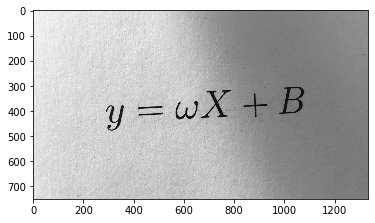

Photograph
[87, 89, 87, 87]
-1


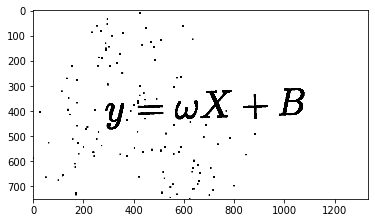

[ 1000  6570  7446  9312 10700 13200]
[52.808372641509436, 54.991155660377444]
[54.52144026186579, 61.69459901800326]
[48.12469237079574, 47.76292042657917]
[43.7760123013839, 42.97385955920038]
[47.683923705722066, 36.169715842740345]
[4.481259370314831, 49.36731634182911]
50 43


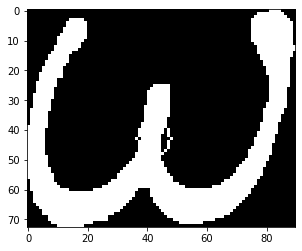

1
57 43
31 47
52 33


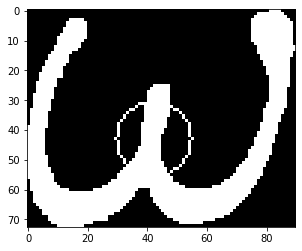

3
64 43
57 28
64 42


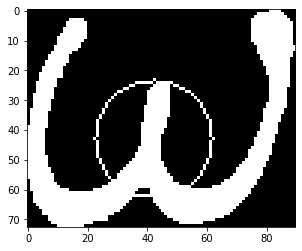

3
70 49
60 22


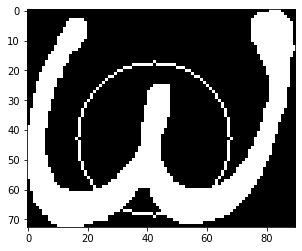

2
69 64
61 14


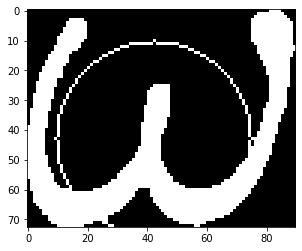

2
41 83
17 13


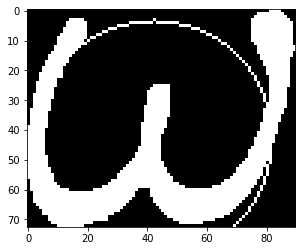

2
27 86
4 19
12 9


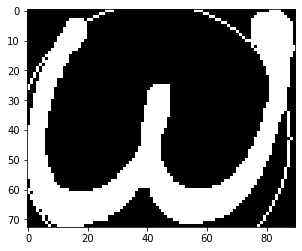

3
15 88


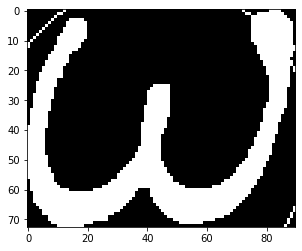

1
[ 6.44893374e-01  1.00000000e+00  3.00000000e+00  3.00000000e+00
  2.00000000e+00  2.00000000e+00  2.00000000e+00  3.00000000e+00
  1.00000000e+00  0.00000000e+00  4.45123645e-01  1.40316755e-01
  1.81994999e-01  2.76465685e-01  3.72603501e-01  3.19255349e-01
  6.46370663e-02  2.99409108e-02  8.50585324e-02 -6.09822491e-05
  1.10331204e-03 -4.98820935e-04]


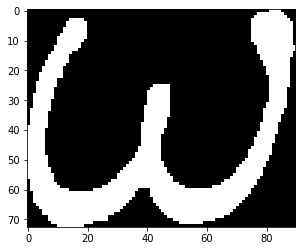

In [97]:
img = cv2.imread("../input/eq1_hr.jpg",0)
plt.imshow(img,cmap='gray')
plt.show()
new_img = binarize_input(img)
img_rotated = skew_correction(new_img)
plt.imshow(img_rotated,cmap='gray')
plt.show()
centroids, bboxs, convex_hulls,imgs = segmentation(img_rotated)
centroids_new = create_new_centroids(centroids, bboxs, imgs)
prof = create_identifier(imgs[3],centroids_new[3])
print(prof)
plt.imshow(imgs[3],cmap='gray')
plt.show()
prof_check = np.copy(prof)

[73.60601163542339, 71.19295410471886]

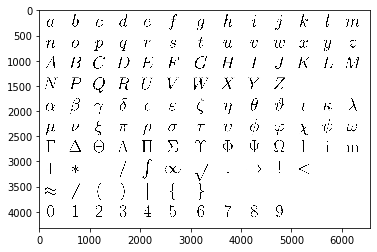

In [19]:
char_pal = cv2.imread("../input/reduced_characterPalette.jpg",0)
plt.imshow(char_pal,cmap='gray')
centroids_new[0]

In [102]:
all_chars_seg = cv2.imread("../input/reduced_characterPalette.jpg",0)
new_img_seg = binarize_input(all_chars_seg)
centroids, bboxs, convex_hulls,imgs = segmentation(new_img_seg)
centroids_new = create_new_centroids(centroids, bboxs, imgs)

Scan/Screenshot
[ 2496  4784  8940 13158 13464 14694 14706 14820 14820 16200 16800 18375
 18666 19431 19584 20808 21573 21573 21574 21917 22338 22600 23103 23550
 24311 24624 24939 24966 25245 25245 26163 26400 26850 27280 27540 28611
 28928 29280 29440 29729 30030 30030 30030 30646 30723 30723 32469 32518
 33428 33660 33813 33839 33880 34720 35100 35168 36207 36480 37758 37920
 38556 38678 38802 39120 39524 40544 41140 41160 41160 41922 42560 43188
 43428 44044 44247 44344 45796 45864 45864 46566 46833 47120 48278 49126
 50076 51146 52182 52216 52248 53418 54112 55221 55430 55458 55458 55876
 56153 56364 57096 57117 57358 57596 59024 59024 59436 62321 65052 65052
 65052 66222 68266 71456 71820 77688 80253 91314]
[147.79149906141058, 85.5321802091712]
[127.44740177439797, 54.531812420785855]
[134.59439013035382, 85.96915735567973]
[132.2234570820525, 68.8786947268859]
[132.123687137032, 60.915976770048474]
[116.55829982768523, 33.58663603293098]
[79.03085073231537, 69.41399189778747]
[

167 86
133 98
163 73


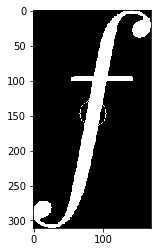

3
187 86
113 102
183 70


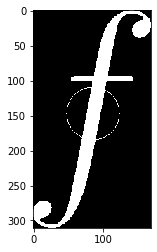

3
101 121
93 106
94 64
203 66


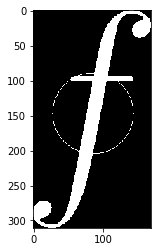

4
74 109
222 62


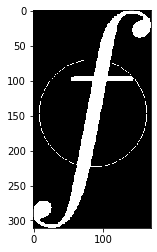

2
54 113
241 58


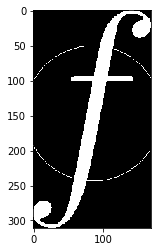

2
35 117
260 54


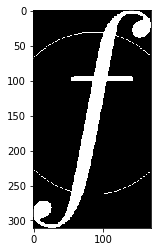

2
34 161
16 122
279 50


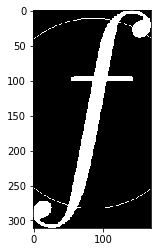

3
15 166
280 2
297 42


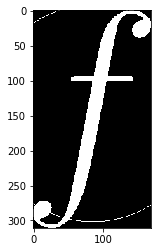

3


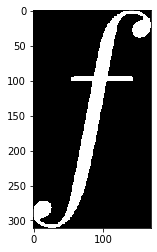

99 55
104 37


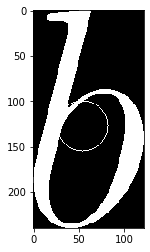

2
91 78
86 42
131 12


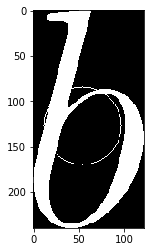

3
171 93
94 101
70 46
156 5


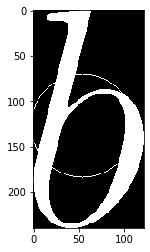

4
192 86
56 49
175 1


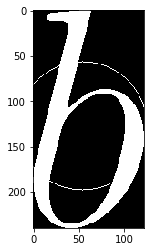

3
211 77
199 102
41 53
195 1


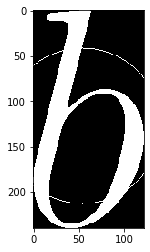

4
228 61
27 56
215 6


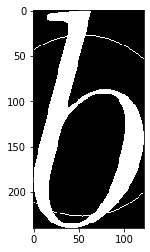

3
13 60


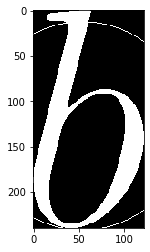

1


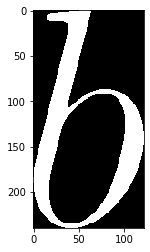

167 97


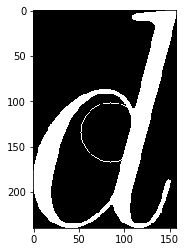

1
185 93
176 114
111 130
88 67
131 35


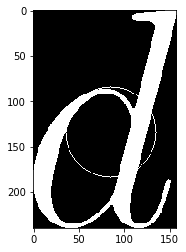

5
202 88
89 136
126 19


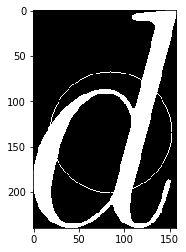

3
219 89
196 144
70 140
156 5
218 76


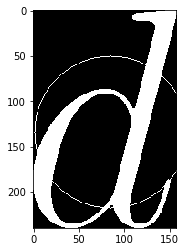

5
235 101
224 134
53 145
187 0
232 57


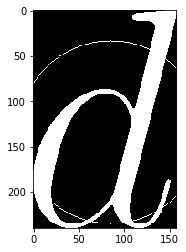

5
35 149
229 16
236 26


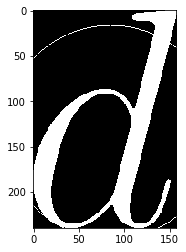

3
18 153


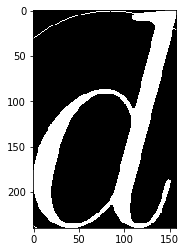

1


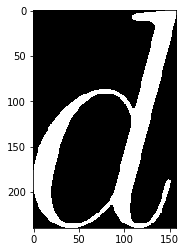

102 68
110 49


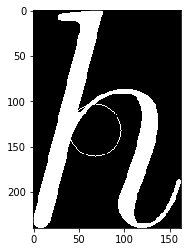

2
92 90
90 54
112 29
132 24


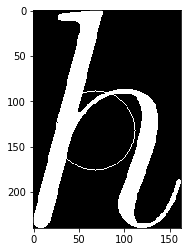

4
182 103
73 58
161 17


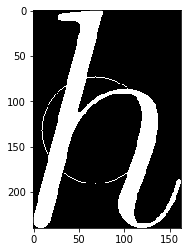

3
202 96
185 121
58 62
180 12


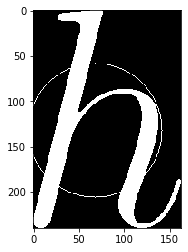

4
218 94
43 66
198 8


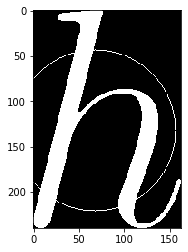

3
232 102
188 158
28 69
214 4


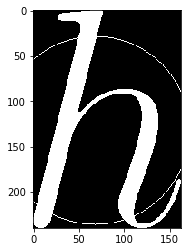

4
239 121
220 149
13 73
230 0


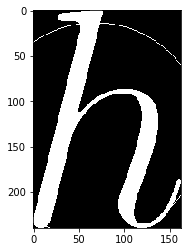

4


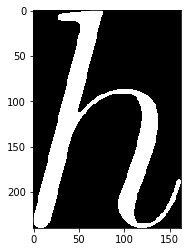

128 75
144 52


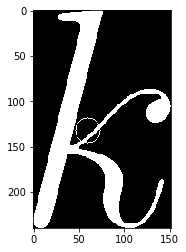

2
162 61
116 86
105 50
161 58


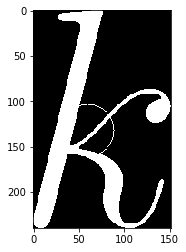

4
174 76
106 96
88 54
148 20


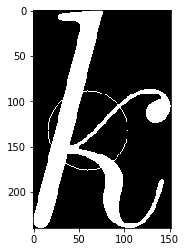

4
188 79
97 108
73 58
169 15


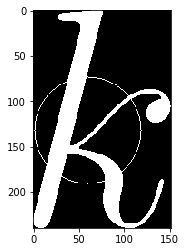

4
204 77
123 134
91 123
58 62
186 11


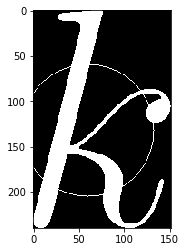

5
219 79
115 148
44 65
202 7


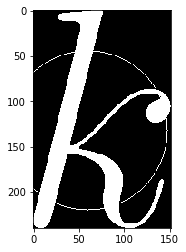

4
232 87
206 134
29 69
217 3


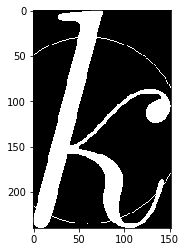

4
239 110
232 123
15 73
233 0


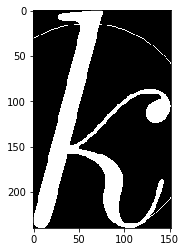

4


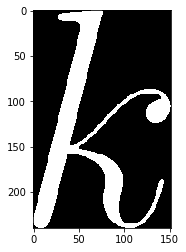

130 34
107 43
107 24
120 21


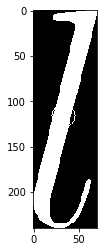

4
144 34
93 47
138 17


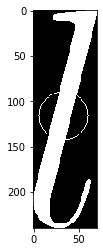

3
79 50
152 13


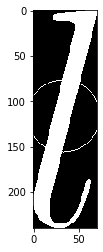

2
66 54
166 10


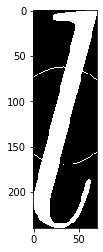

2
53 57
179 6


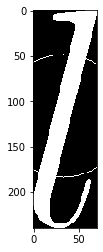

2
195 56
39 60
192 3


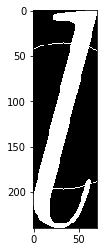

3
211 51
26 64
206 0


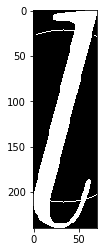

3
225 45
13 67
221 2


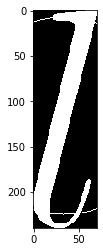

3


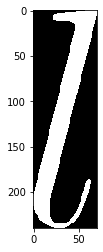

101 92


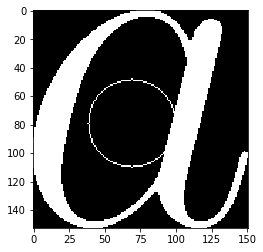

1
117 87


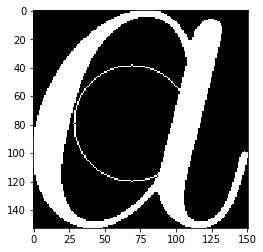

1
131 76
66 120
37 39


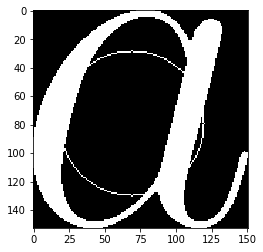

3
141 69
137 91
50 124
28 106
19 51
141 64


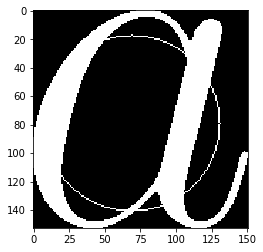

6
146 98
35 127
17 107
6 69
10 48
99 0
136 24
148 45


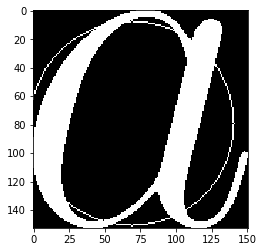

8
151 110
125 139
23 130
137 11
145 19


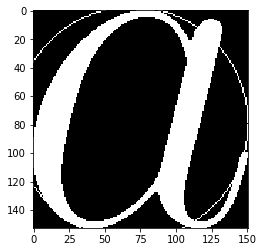

5


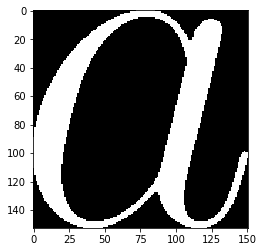

62 29


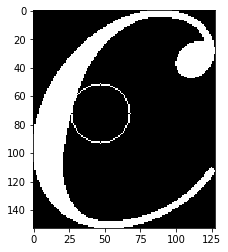

1
43 36


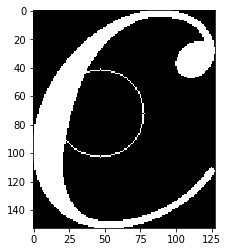

1
31 44
48 14
59 8


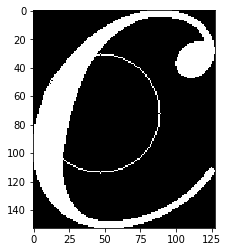

3
20 53
94 0


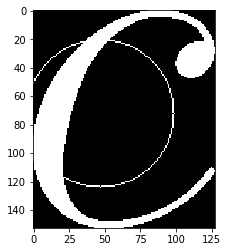

2
46 106
11 64
117 3


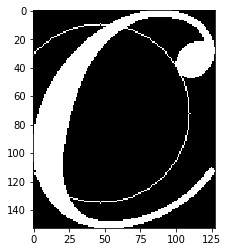

3
45 117
5 79
140 18
147 43


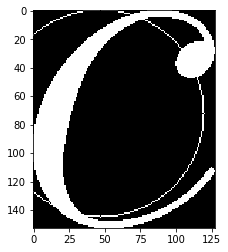

4
138 101
37 125
5 99


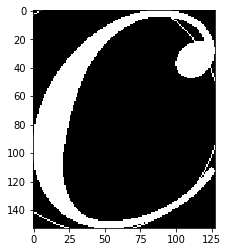

3


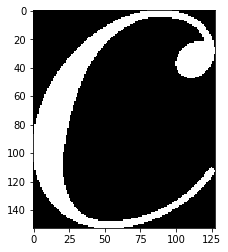

69 55
65 40


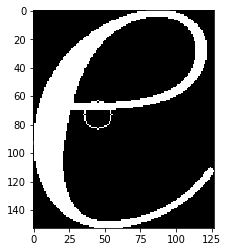

2
68 66
61 28


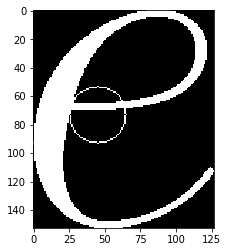

2
67 76
43 35


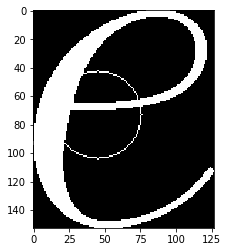

2
64 86
32 41
52 9
65 4


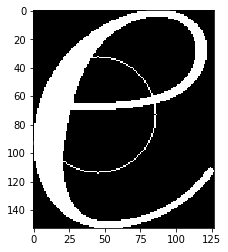

4
61 96
21 49
101 1
121 22


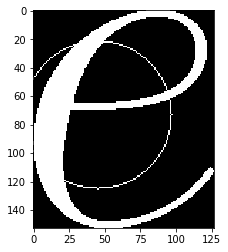

4
56 106
12 61
122 6


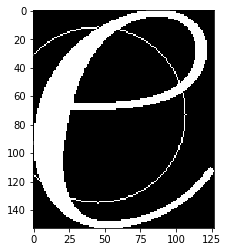

3
48 114
6 74
142 21


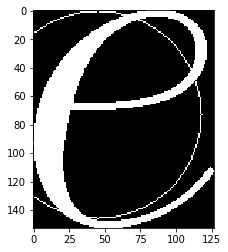

3
144 89
120 115
37 120
4 93


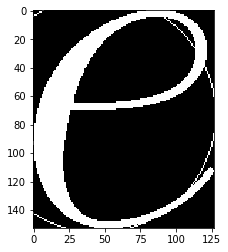

4


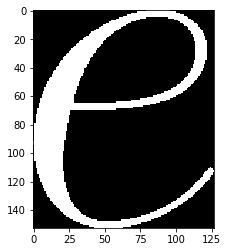

133 91
109 110


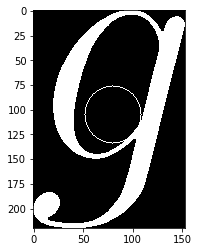

2
144 101
81 44
145 61


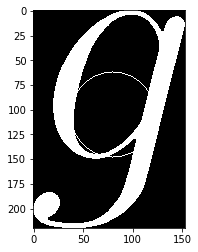

3
161 97
84 135
55 51
126 27


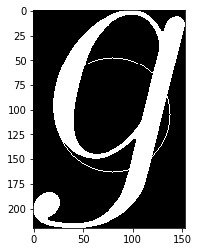

4
177 92
64 140
36 58
54 30


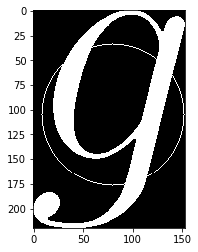

4
193 84
46 144
19 70


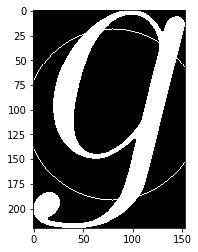

3
207 81
30 148
14 125
9 114
5 92
184 16
207 70


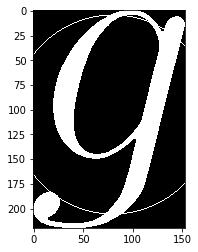

7
14 152
191 3
215 41


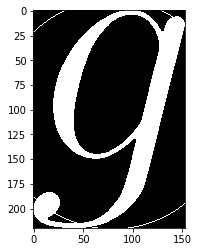

3


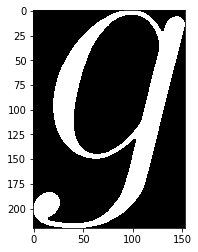

84 43


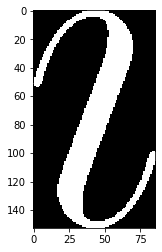

1
93 43
66 56
86 30


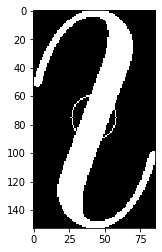

3
101 43
57 60
95 27


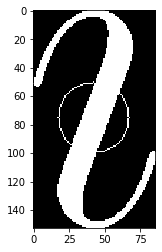

3
49 63
104 23


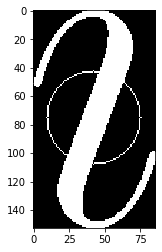

2
41 66
112 20


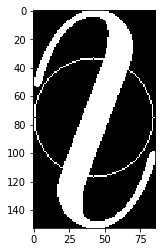

2
114 77
32 68
38 9
120 18


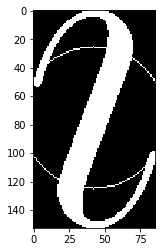

4
129 70
23 69
22 17
129 17


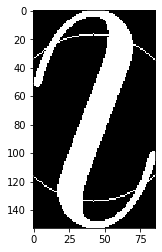

4
142 59
12 65
10 27
140 21


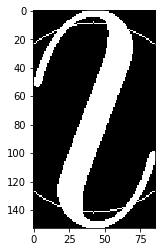

4


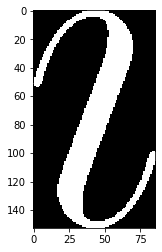

129 81


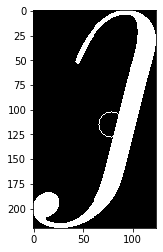

1
143 80
107 105
143 77


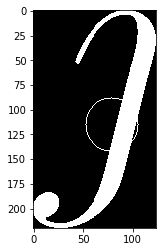

3
156 80
88 110
156 74


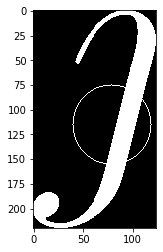

3
170 80
73 113
169 71


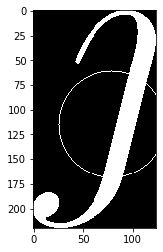

3
184 80
59 117
182 66


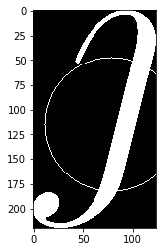

3
45 121
38 53
195 59


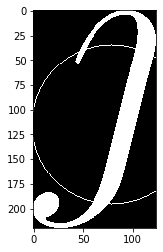

3
31 123
22 63
184 13
206 50


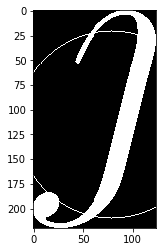

4
15 120
7 80
192 2
214 34


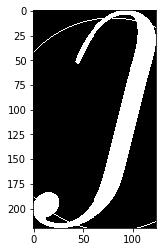

4


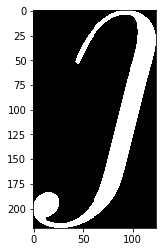

88 133
67 148
85 125


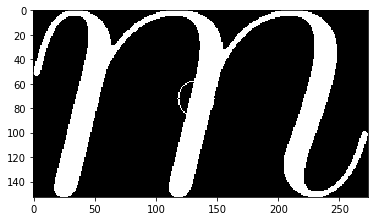

3
104 133
48 153
101 121


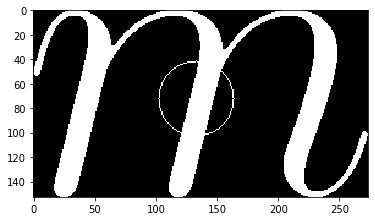

3
120 133
34 161
117 117


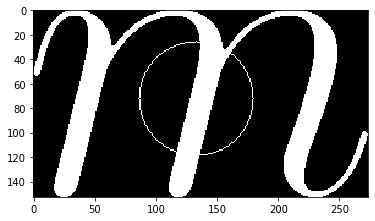

3
21 171
10 146
132 113


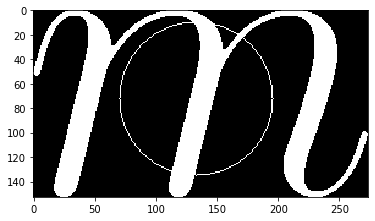

3
11 184
7 89
14 80
22 72
148 111


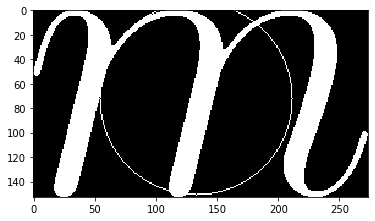

5
134 206
5 201
14 58


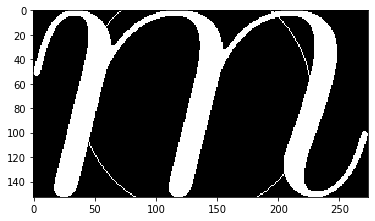

3
147 215
60 244
11 226
3 47
102 27


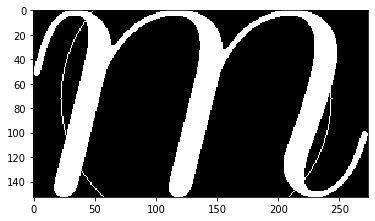

5
152 232
0 29
129 20


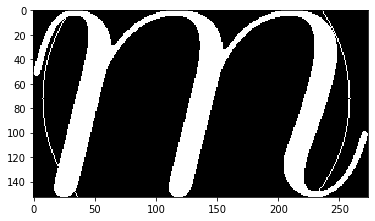

3


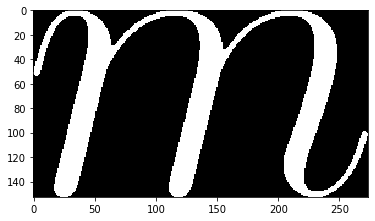

120 45
98 53


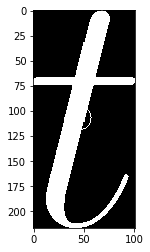

2
86 56
124 27


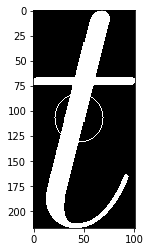

2
74 61
138 24


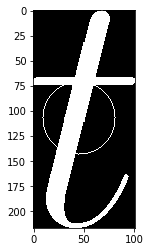

2
74 81
62 62
67 19
150 21


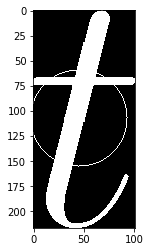

4
74 97
50 65
163 18


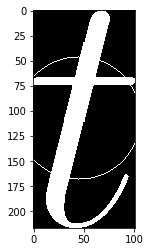

3
168 88
38 68
175 15


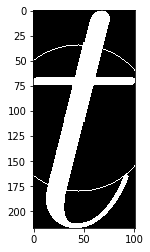

3
187 78
26 71
187 13


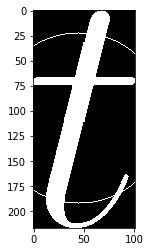

3
204 64
14 74
201 16


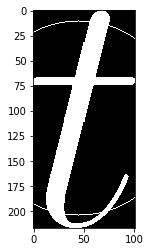

3


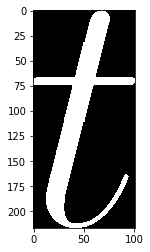

55 58


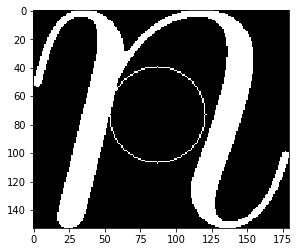

1
110 115
31 70


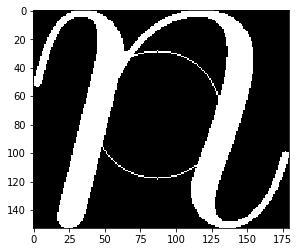

2
125 111
101 137
87 142
16 84
22 62
85 31


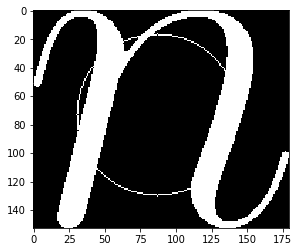

6
137 113
53 152
6 102
12 58
105 27


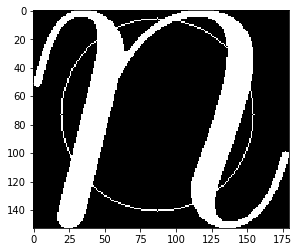

5
146 119
31 154
3 48
120 23


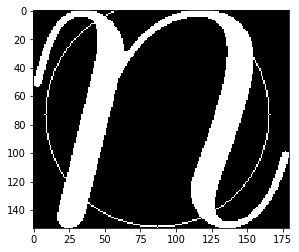

4
152 132
0 33
7 24
36 4
133 19


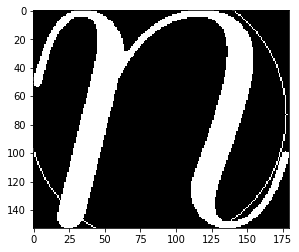

5


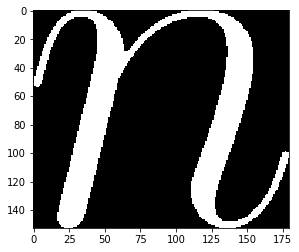

109 103
45 36


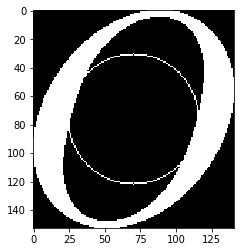

2
128 90
24 50


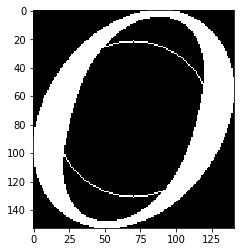

2
140 76
131 103
90 133
12 64
20 39
60 8


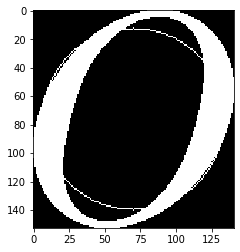

6
54 140
15 112
4 88
97 0
148 52


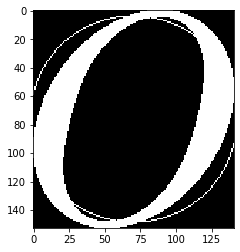

5


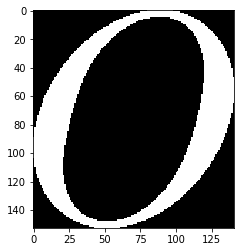

68 76
122 66


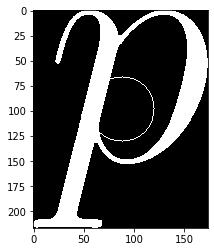

2
142 111
108 137
50 81
119 45
144 73


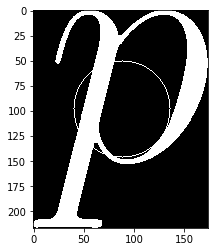

5
116 151
33 87
140 39


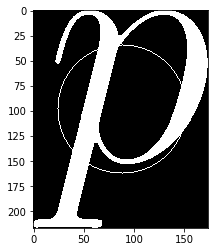

3
82 168
18 100
17 82
42 29
159 35


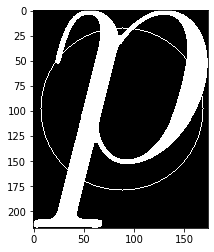

5
50 173
5 119
3 69
13 40
176 30


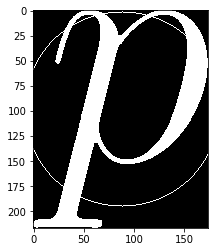

5
193 26
208 58


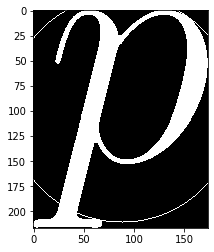

2
207 18


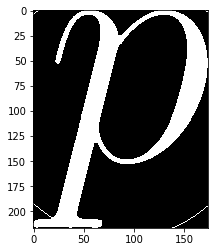

1


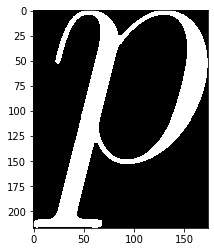

128 79


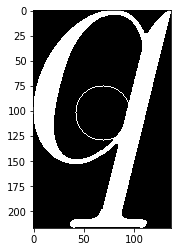

1
142 82
112 109
143 61


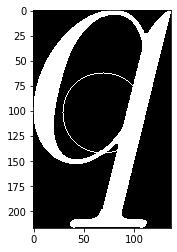

3
156 79
78 117
66 29
132 23
147 37


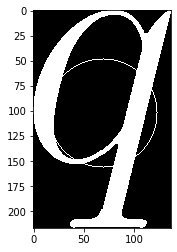

5
170 75
60 121
43 36
126 6


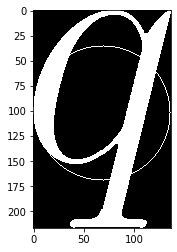

4
184 72
44 125
24 48


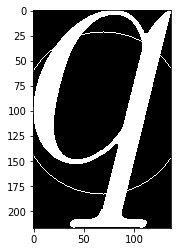

3
198 69
29 129
16 106
8 65
11 47
198 68


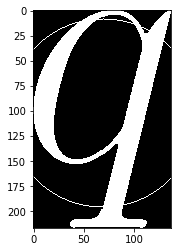

6
211 69
15 133
208 41


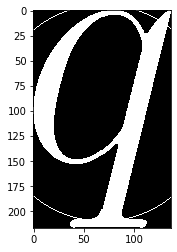

3


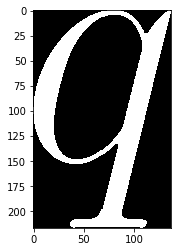

50 59


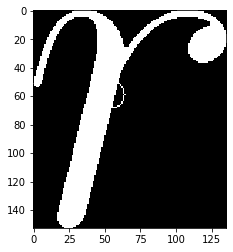

1
39 63
69 35


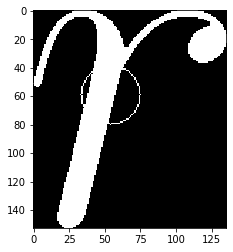

2
30 68
83 32


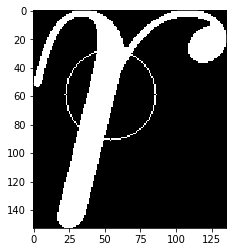

2
21 75
17 60
94 29


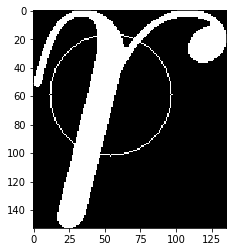

3
13 83
5 51
26 12
106 26


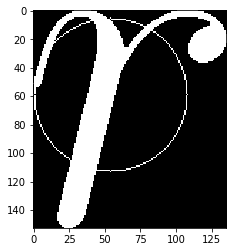

4
36 116
7 93
0 30
6 19
117 23


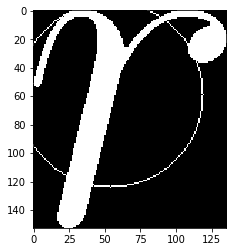

5
34 126
4 107
128 21


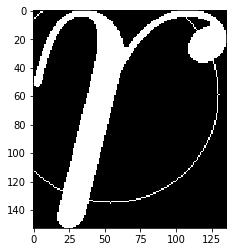

3
24 134
1 119
138 18


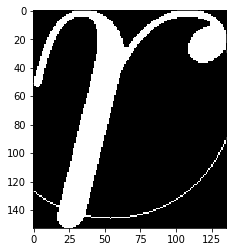

3


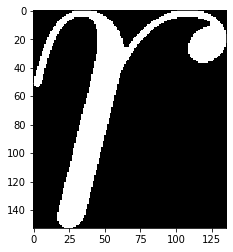

83 73


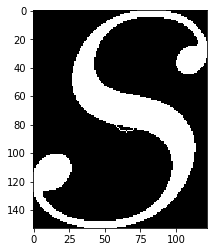

1
85 82
60 74


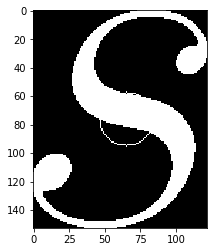

2
91 90
65 91
53 50


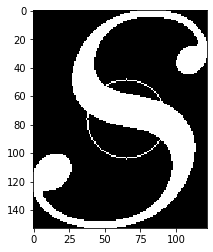

3
100 96
45 44


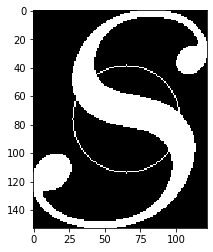

2
113 97
35 42


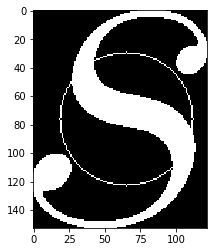

2
128 91
112 110
44 112
23 46
101 14


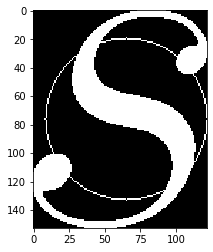

5
143 73
137 93
38 119
11 57
15 42
105 5


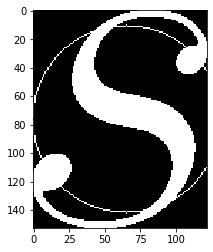

6
25 121
17 113
5 92
115 0
147 35


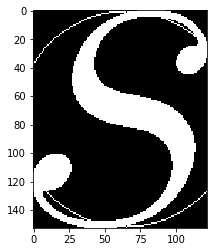

5


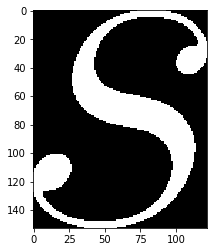

100 112


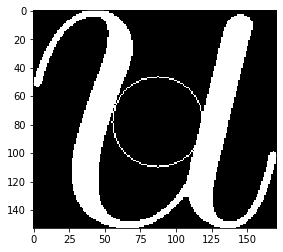

1
117 108
41 66


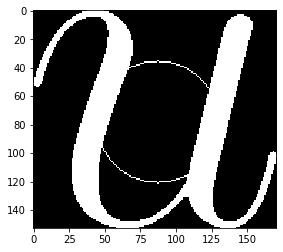

2
131 100
64 140
28 69
48 44
76 34


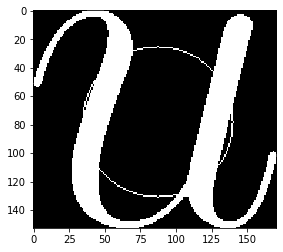

5
143 88
138 112
48 144
17 68
102 28
143 86


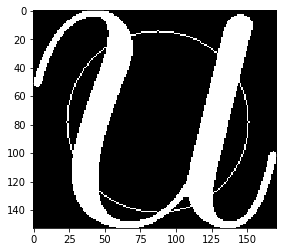

6
147 119
32 147
8 62
124 28


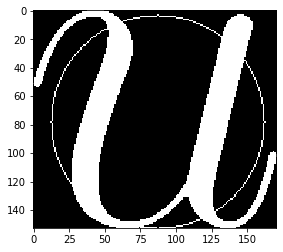

4
152 132
133 155
107 169
20 151
1 51


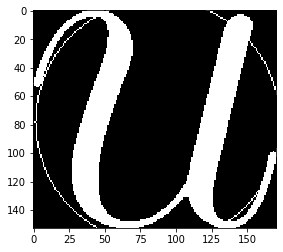

5


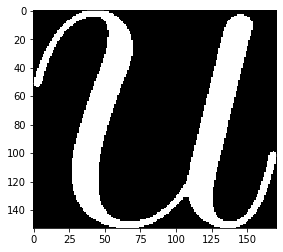

47 63


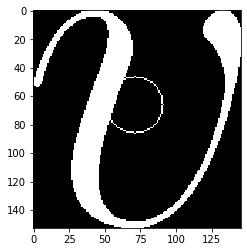

1
36 67


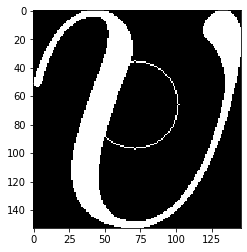

1
25 69
31 50
82 32


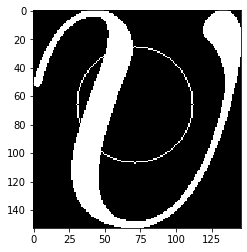

3
15 67
97 29


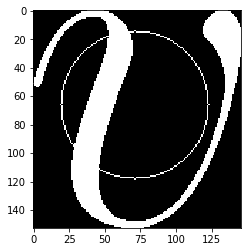

2
110 117
5 59
111 27


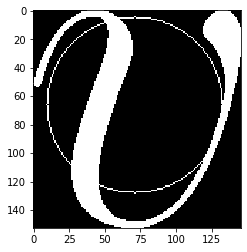

3
134 101
50 142
0 42
38 4
51 0
126 29


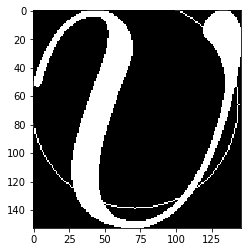

6
150 71
29 145
145 43


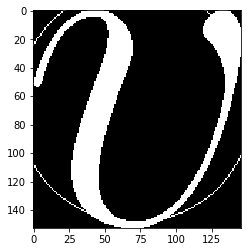

3


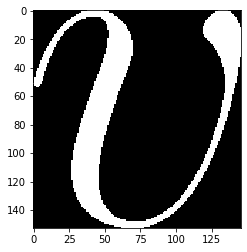

86 111


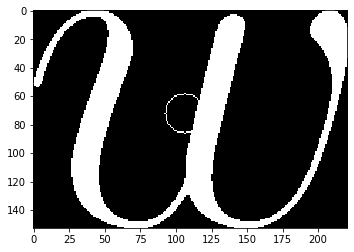

1
101 108
65 135


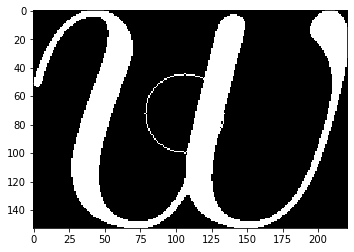

2
116 107
45 140
116 107


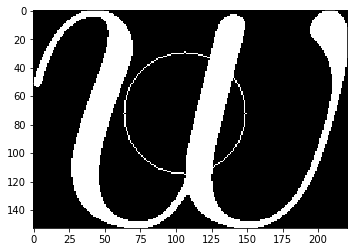

3
130 110
29 144
29 69
130 101


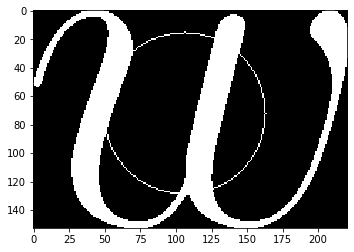

4
143 120
13 148
13 66
73 35
143 91


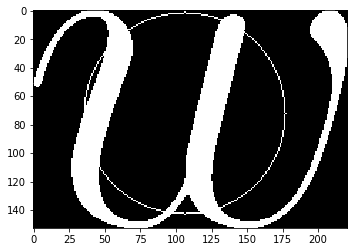

5
152 141
3 56
104 27
141 54


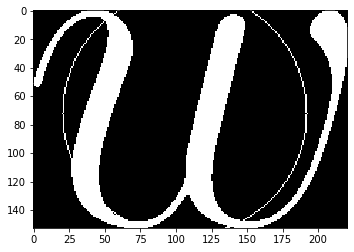

4
96 204
1 36
9 28


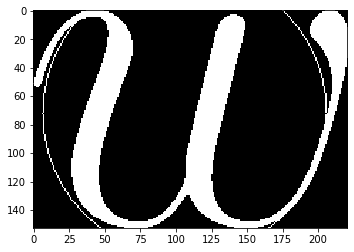

3
45 218


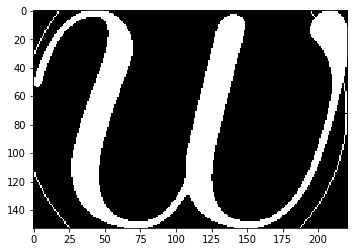

1


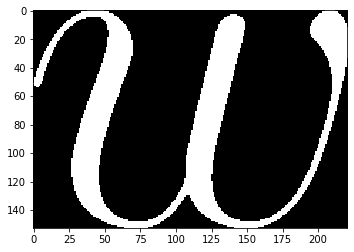

87 82
72 92
80 71


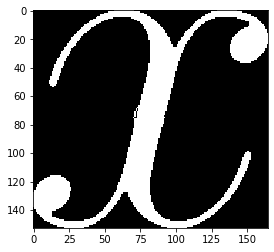

3
99 82
58 96
94 68


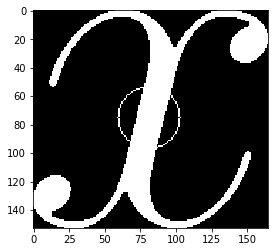

3
110 82
46 99
106 65


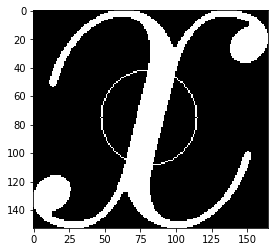

3
35 102
117 62


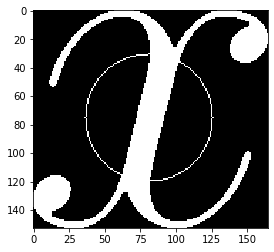

2
133 82
24 106
128 57


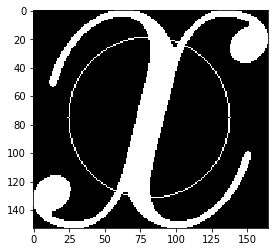

3
145 82
14 113
7 85
137 51
144 77


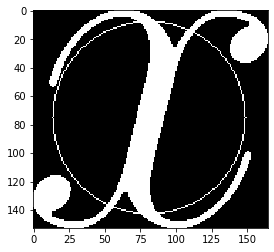

5
152 105
143 125
36 152
7 122
1 54
6 43
116 12
145 42


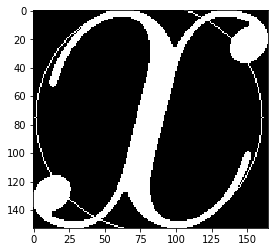

8
29 161
4 139
122 3
148 24


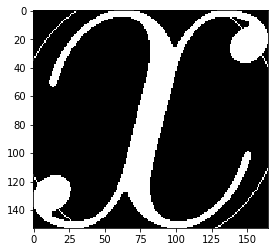

4


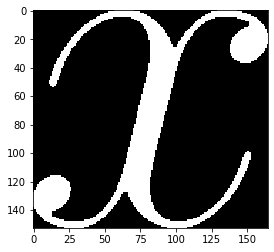

145 81
141 95
67 56


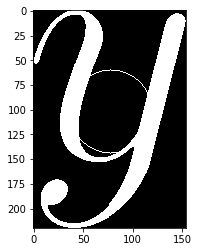

3
155 98
139 121
90 133
49 62
122 27
149 48


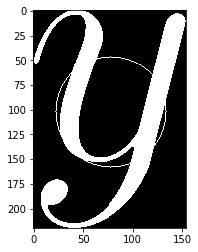

6
171 92
67 139
33 68


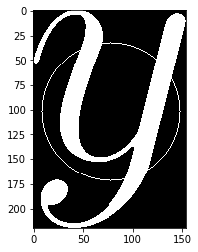

3
187 83
49 143
19 68


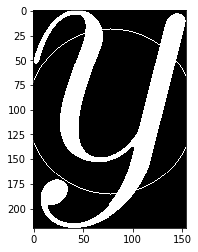

3
201 79
32 147
6 60
31 12
41 3
176 13
200 73


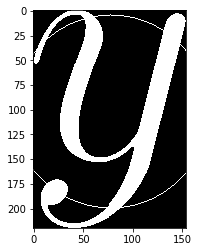

7
17 151
189 8
212 55


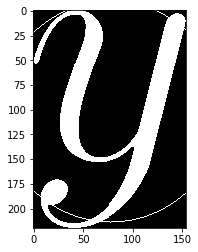

3


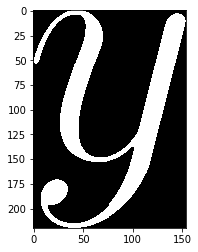

70 80
80 63


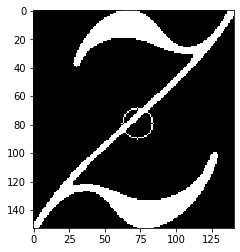

2
62 89
90 53


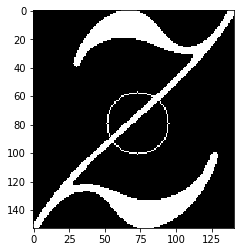

2
54 97
97 45


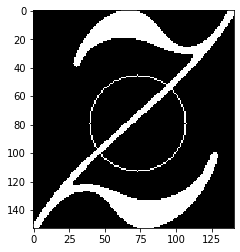

2
46 105
105 36


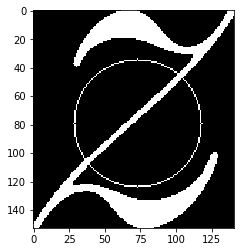

2
137 74
38 113
30 104
113 28
122 35
129 46


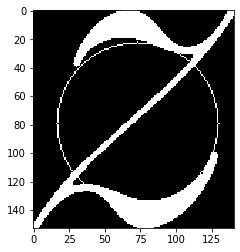

6
148 74
139 107
29 121
12 88
122 20
147 64


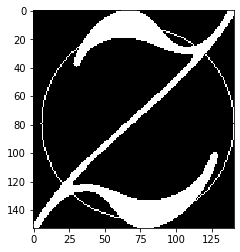

6
20 128
0 66
131 13


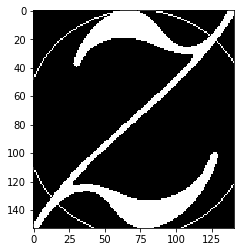

3
11 135
140 6


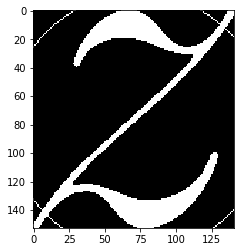

2


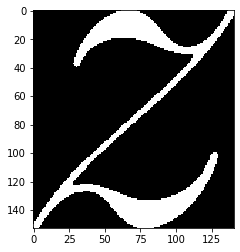

162 156
150 169
154 133


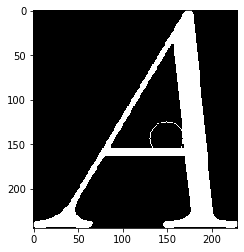

3
177 171
154 111


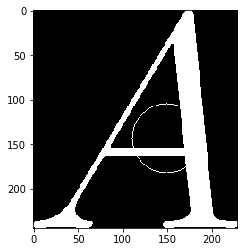

2
198 173
98 188
90 122
130 92
154 91


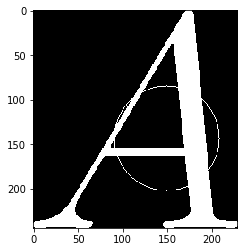

5
219 175
72 185
65 137
163 73


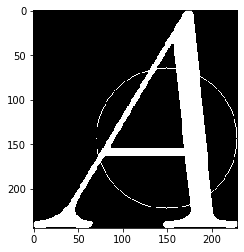

4
243 150
50 183
44 150
185 59
243 147


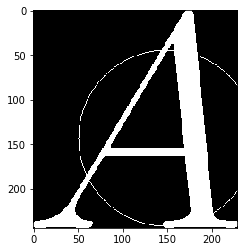

5
243 216
28 181
205 47


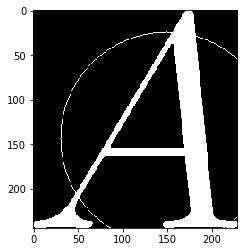

3
7 179
222 35


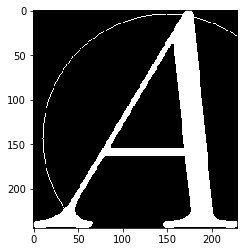

2
233 18


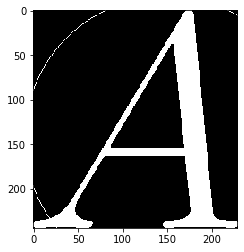

1


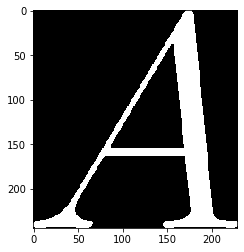

55 63


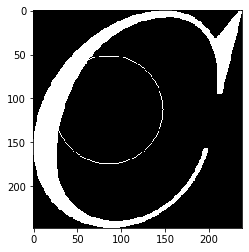

1
30 89
127 3


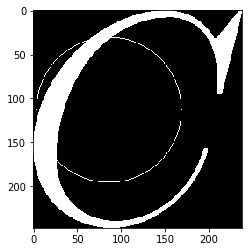

2
14 119
175 2
205 34


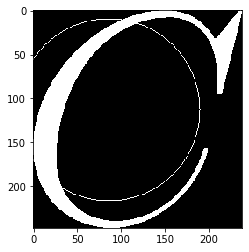

3
239 86
229 137
194 182
95 210
7 153
225 29


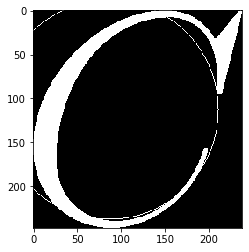

6
61 223


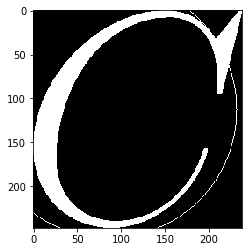

1
29 231


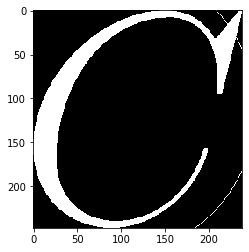

1


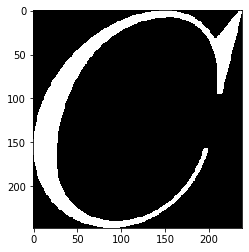

155 134


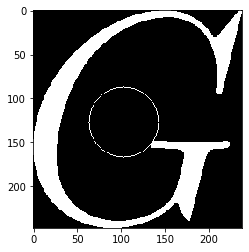

1
157 157


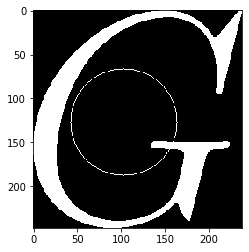

1
176 170
57 62


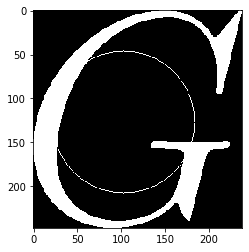

2
215 157
172 195
160 200
26 95
34 63
134 2
202 33


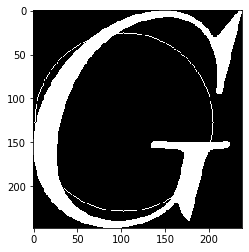

7
231 170
220 183
154 223
82 217
9 137
220 24
245 68


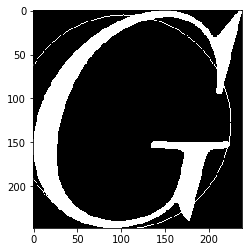

7
52 225
20 197
10 185


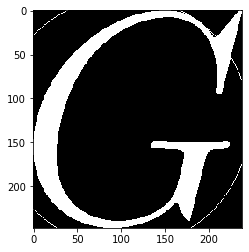

3
26 231


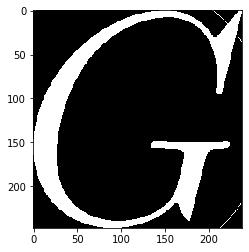

1


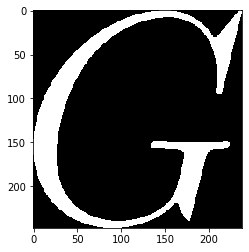

114 150
110 113


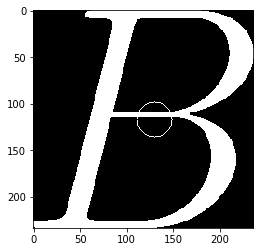

2
118 170
110 93


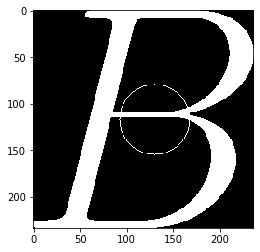

2
135 186
103 187
72 94


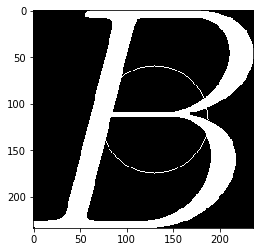

3
168 190
94 205
46 100
134 56


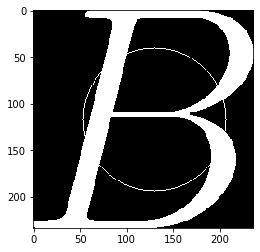

4
208 165
81 221
24 106
166 48


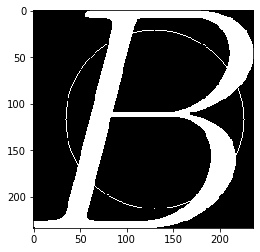

4
233 131
63 233
8 171
191 42
226 89


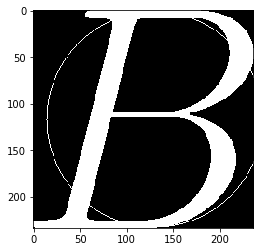

5
27 231
7 209
0 64
213 36


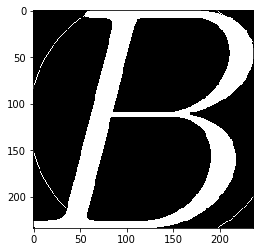

4
225 19


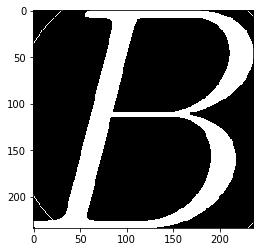

1


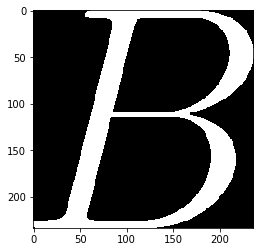

74 95


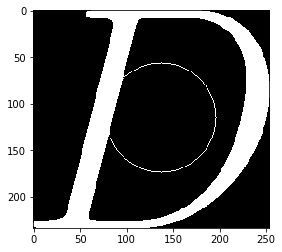

1
44 102
124 59


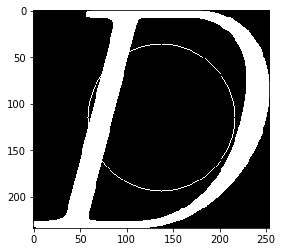

2
214 158
21 108
162 50


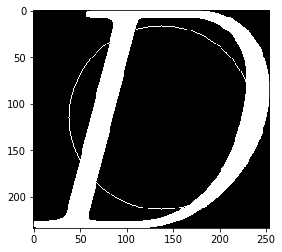

3
84 253
188 43
226 90


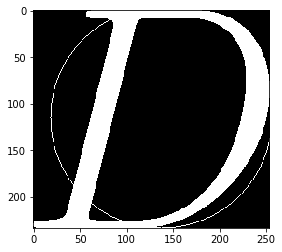

3
1 59
212 37


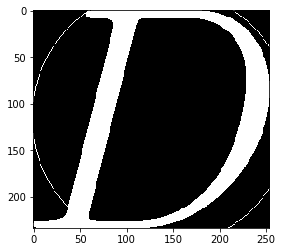

2
225 21


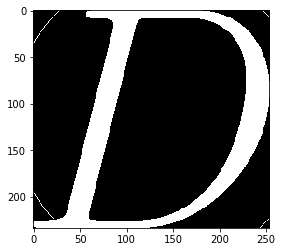

1


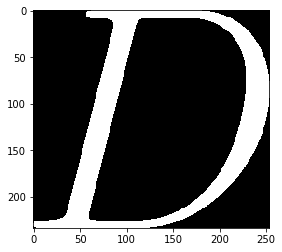

115 159
108 120


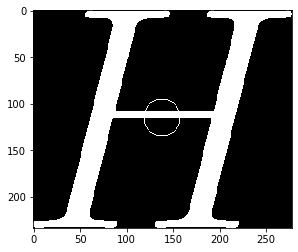

2
115 179
108 99


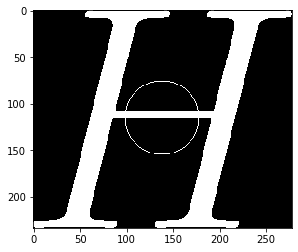

2
159 181
74 95


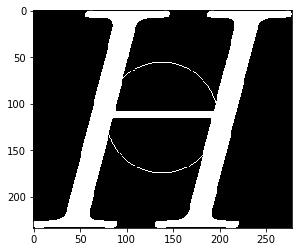

2
188 174
160 205
108 218
44 103
71 72
123 59


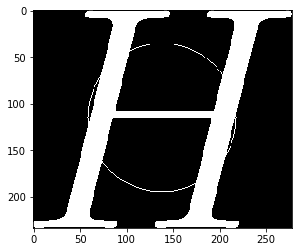

6
212 168
70 227
20 109
162 50


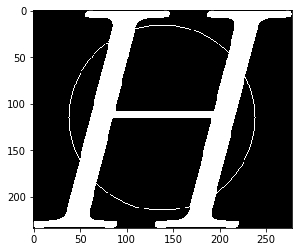

4
232 169
43 234
8 193
1 104
189 43


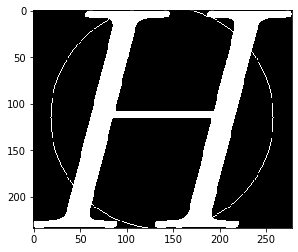

5
233 216
19 240
0 60
213 37


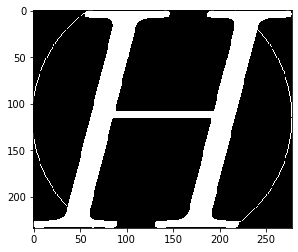

4
8 258
225 20


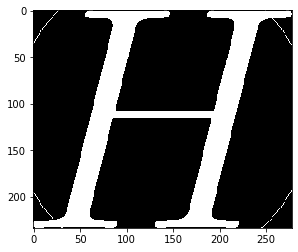

2


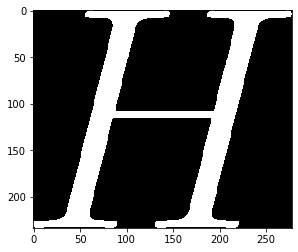

131 75
109 88
123 61


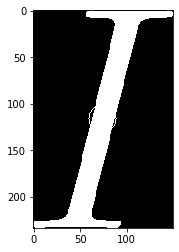

3
147 75
92 93
141 57


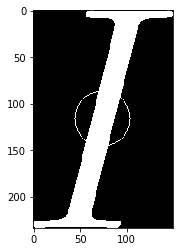

3
162 75
76 97
156 53


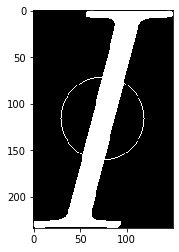

3
61 101
171 49


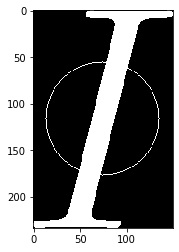

2
46 104
187 45


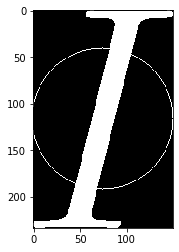

2
31 108
202 42


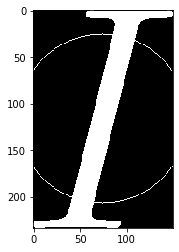

2
16 112
9 84
217 38


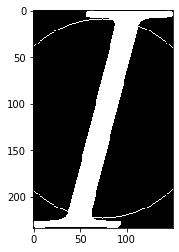

3
8 133
225 18


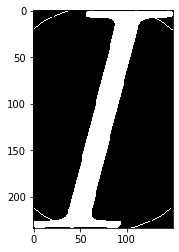

2


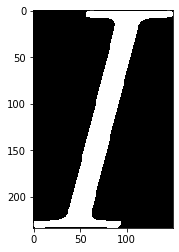

138 103


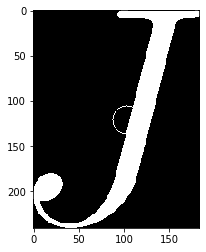

1
154 103
108 133
153 98


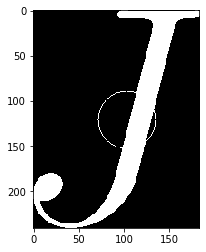

3
170 103
88 138
169 94


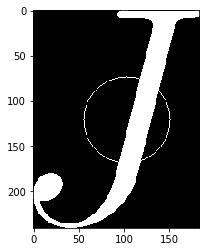

3
186 103
71 142
184 91


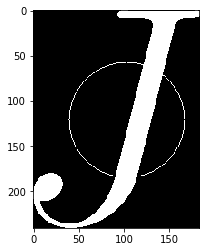

3
202 103
54 146
200 85


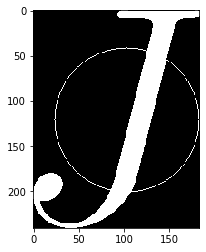

3
37 150
184 29
214 77


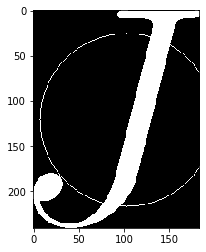

3
21 154
184 9
227 64


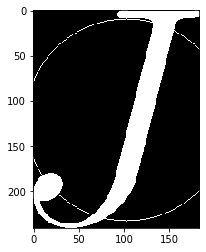

3
9 164
199 1
236 44


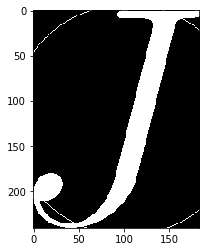

3


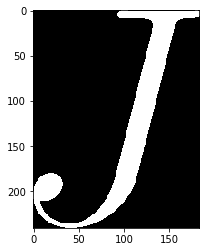

133 144
125 100


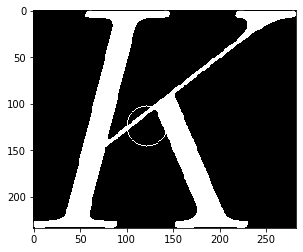

2
157 154
92 152
94 90


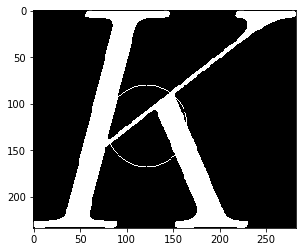

3
179 163
76 168
62 98
135 56


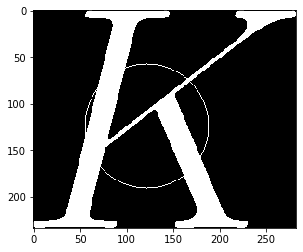

4
200 172
62 186
37 104
172 47


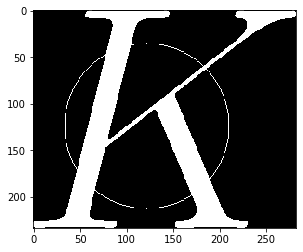

4
232 153
48 204
13 112
200 40
225 72


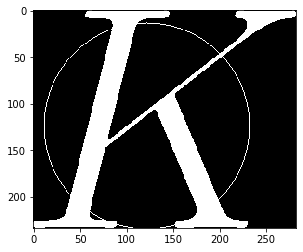

5
232 203
34 222
1 72
222 31


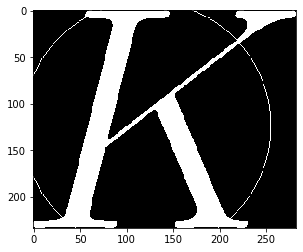

4
22 240
226 3


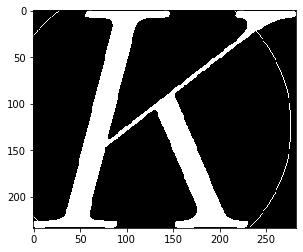

2
11 261


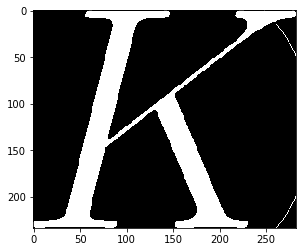

1


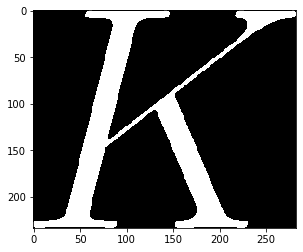

119 84


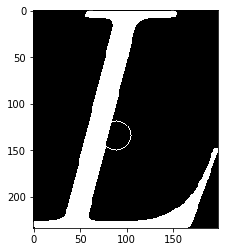

1
102 88
119 60
135 56


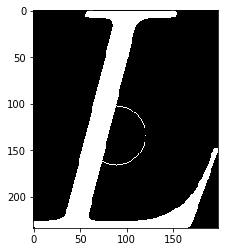

3
86 92
91 67
163 49


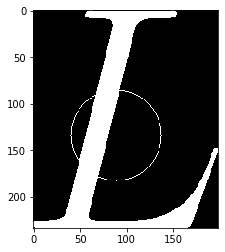

3
69 96
183 44


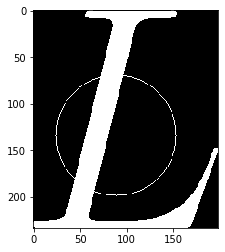

2
53 100
201 40


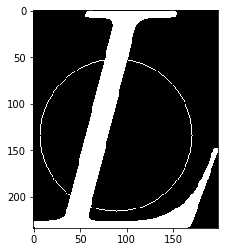

2
233 97
219 142
37 104
217 35


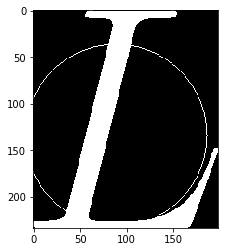

4
233 149
21 108
225 17


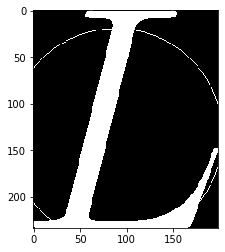

3
8 127
232 0


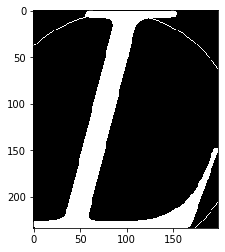

2


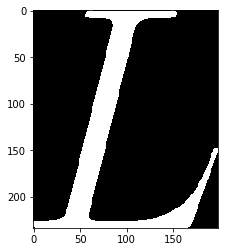

139 186
122 197


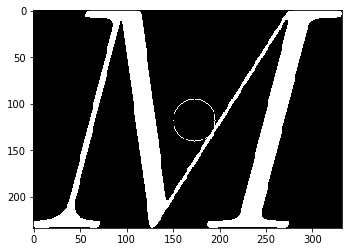

2
99 215
106 129
165 170


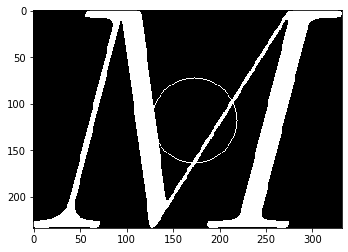

3
77 229
70 124
155 115
186 156


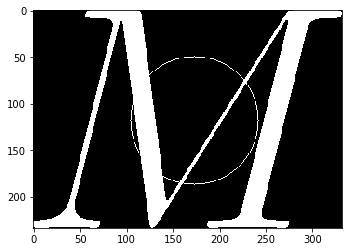

4
193 229
57 241
43 121
193 120


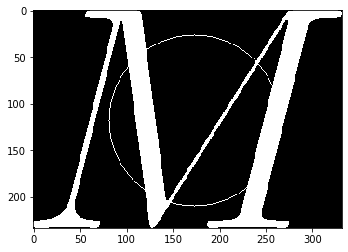

4
233 189
76 280
37 254
18 118
46 84
123 59
223 124


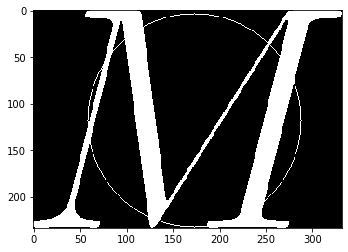

7
232 252
42 288
17 267
0 104
173 47


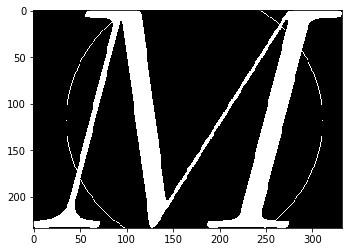

5
15 296
206 38
218 46


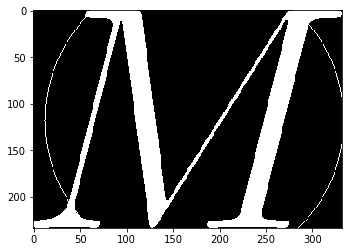

3
8 321
223 21


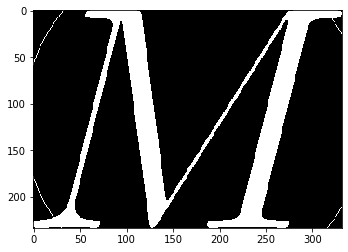

2


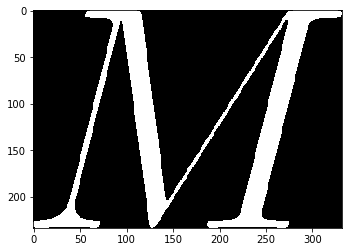

116 133
108 97


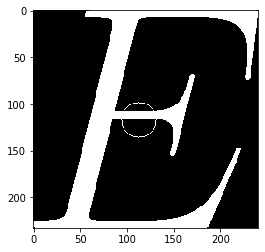

2
130 150
85 92


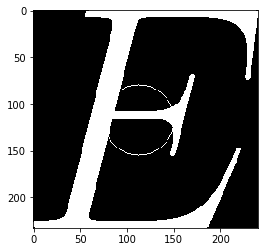

2
95 166
62 98
82 69
128 58


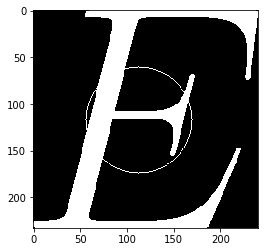

4
69 172
41 103
158 50


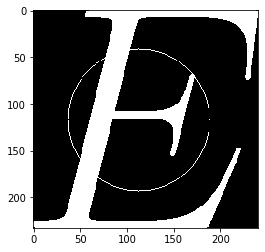

3
22 108
182 44


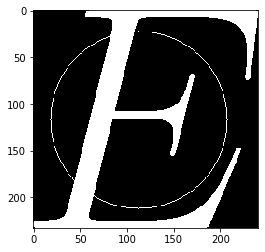

2
231 114
180 209
7 146
203 39
225 74


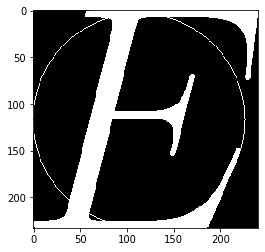

5
232 181
58 234
8 191
222 31


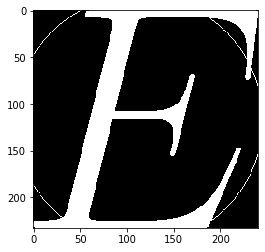

4
28 237
225 5


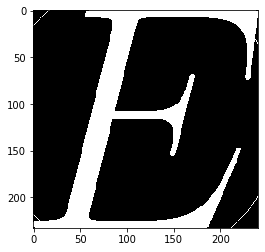

2


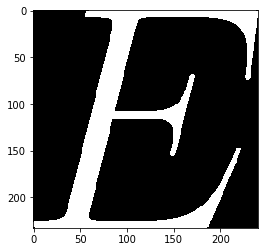

119 103
86 92
112 87


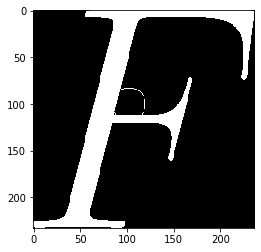

3
121 134
64 97
90 67


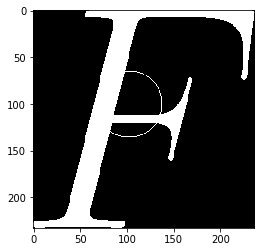

3
134 147
46 102
132 57


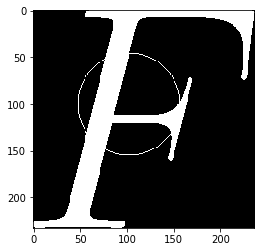

3
160 146
27 107
154 51


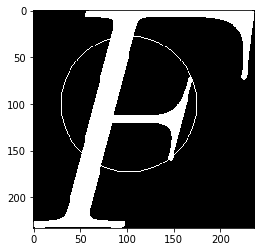

3
9 115
174 46


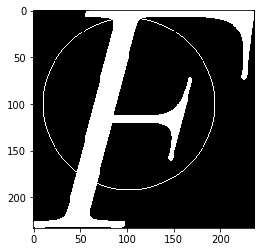

2
7 162
193 42


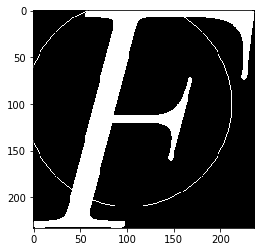

2
68 228
9 194
212 37


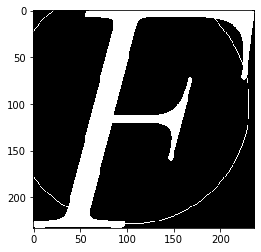

3
31 232
224 20


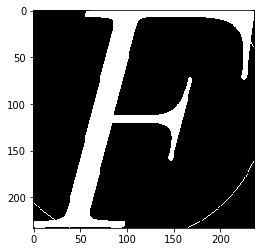

2


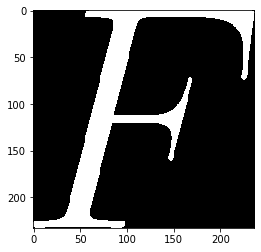

205 120
194 88
205 117


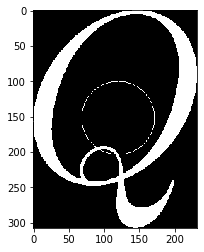

3
222 121
218 146
154 191
205 74


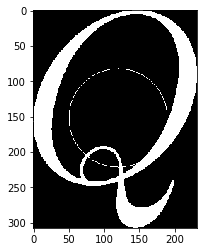

4
240 120
174 205
221 66
239 108


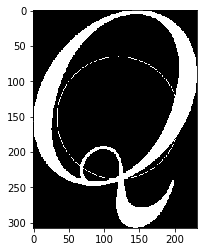

4
258 120
135 224
73 51
247 75
258 119


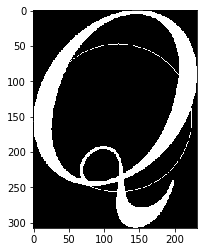

5
275 120
253 191
100 231
36 79
66 33
275 118


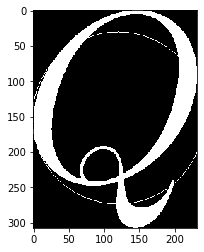

6
293 122
276 186
63 228
33 195
12 114


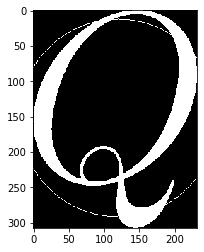

5


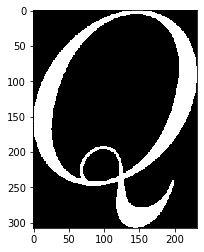

128 140
90 149


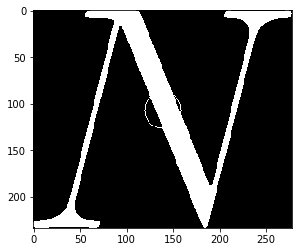

2
148 148
66 140


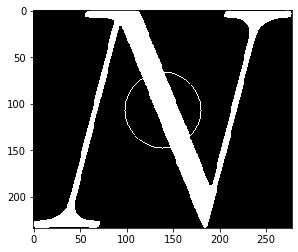

2
168 156
46 132


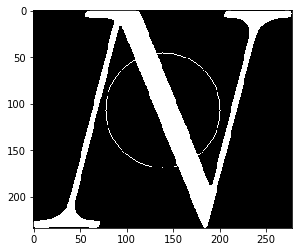

2
187 164
168 197
156 206
96 221
26 124
46 84
55 76
126 59


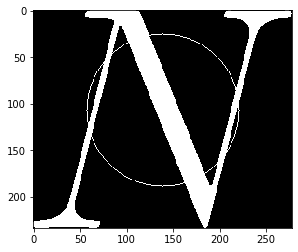

8
206 171
58 230
7 116
160 50


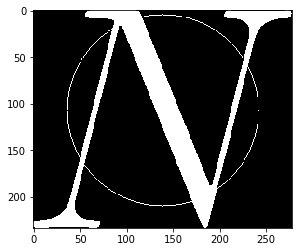

4
226 179
31 237
8 214
0 78
187 43


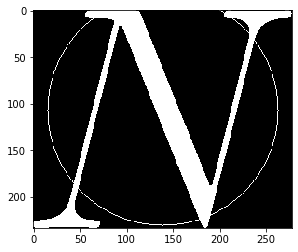

5
13 250
210 36


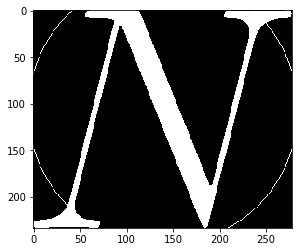

2
8 272
223 20


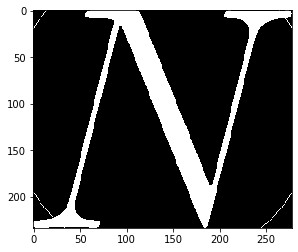

2


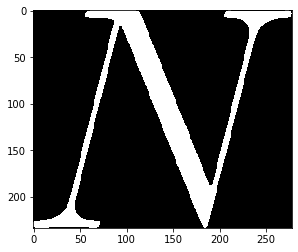

123 145
62 98


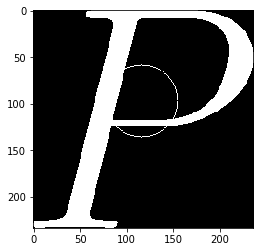

2
119 171
39 104
53 77
118 61


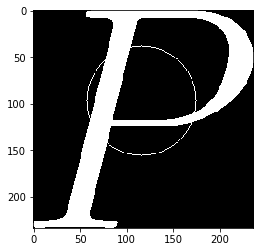

4
109 194
19 109
145 54


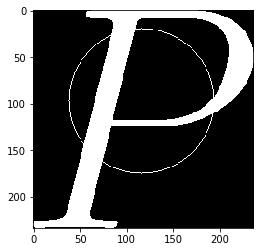

3
95 214
8 159
168 48


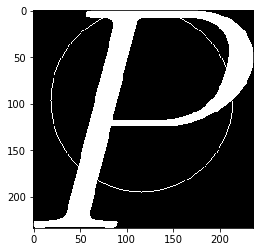

3
72 231
190 43


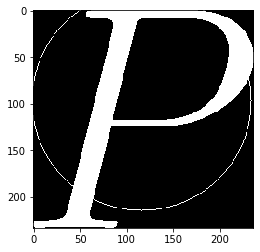

2
211 38


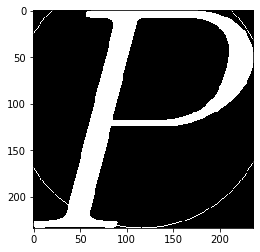

1
225 23


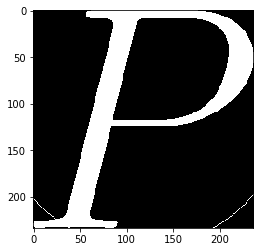

1


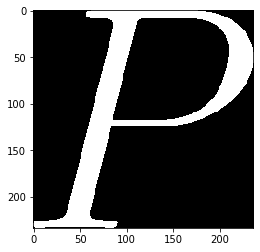

122 147
114 110


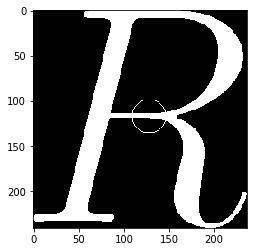

2
135 162
113 166
114 91


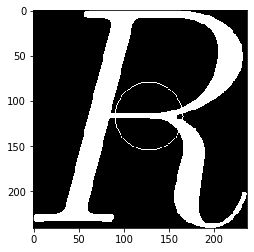

3
162 165
107 184
71 96


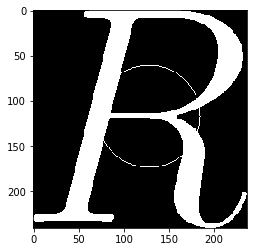

3
188 159
97 202
46 102
65 74
140 55


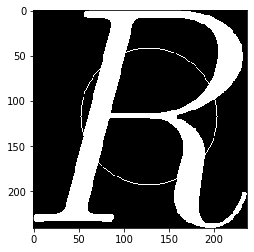

5
209 156
84 217
25 107
168 48


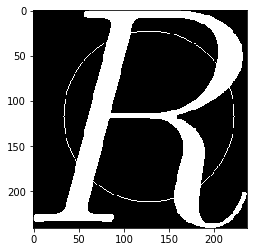

4
227 163
65 229
8 160
192 42


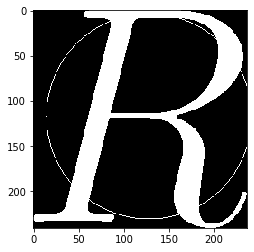

4
238 185
203 231
23 221
15 212
0 68
214 37


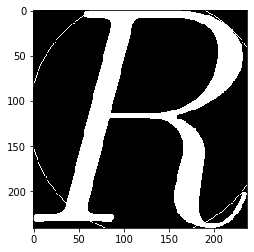

6
225 20


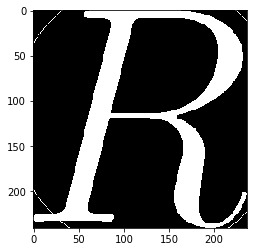

1


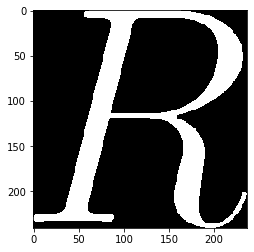

69 49


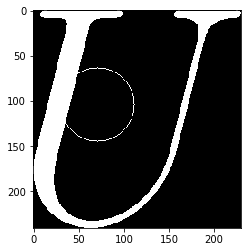

1
44 55
123 11


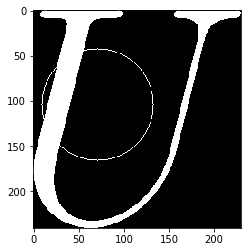

2
21 61
153 4


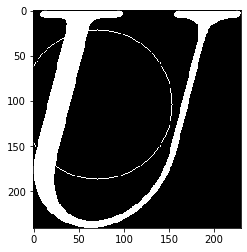

2
183 140
168 154
88 175
4 98
1 61
180 0


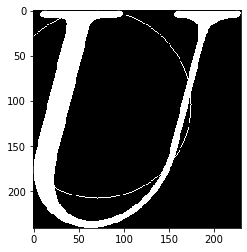

6
229 87
222 113
50 184
214 12


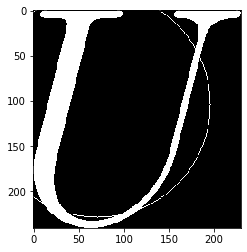

4
22 192


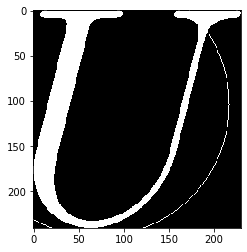

1
10 209


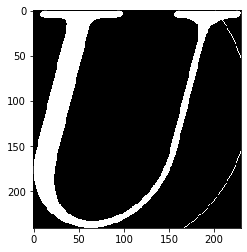

1


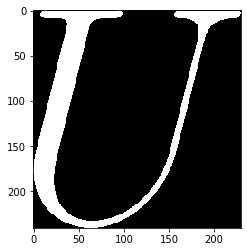

91 61
114 64


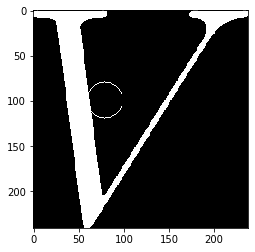

2
65 57


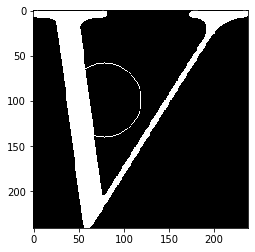

1
154 111
139 127
126 135
43 55
150 44


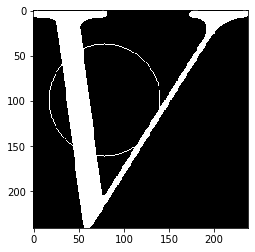

5
181 94
85 161
22 52
176 47


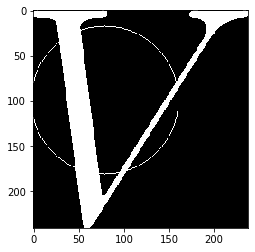

4
203 80
62 175
1 51
199 50


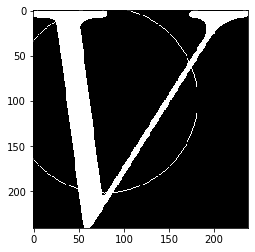

4
41 189
0 5
221 53


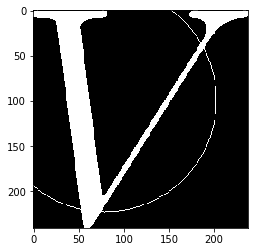

3
22 202


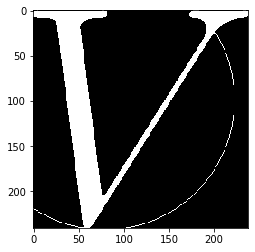

1
10 219


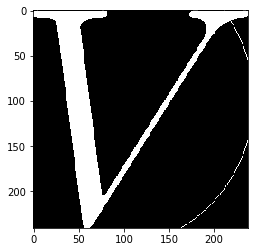

1


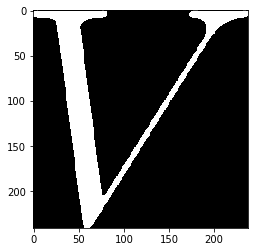

80 138
121 110


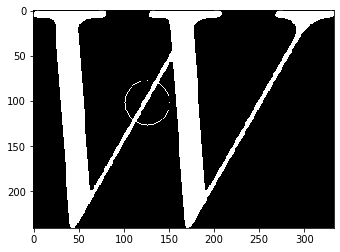

2
140 161
57 150
143 97


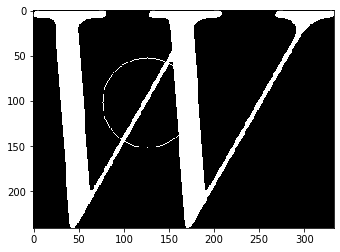

3
170 163
47 179
81 54
137 58
166 84


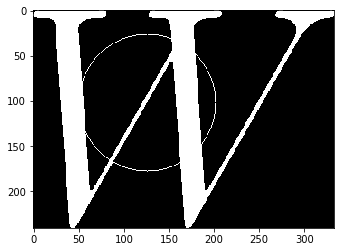

5
197 165
15 178
35 50
144 34
188 72


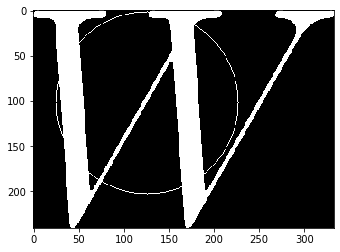

5
223 167
213 189
100 254
4 208
1 51
192 37


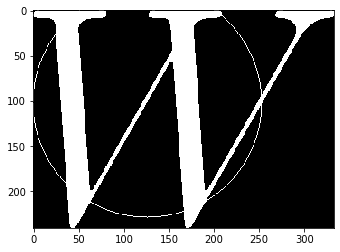

6
64 274
1 13
228 40


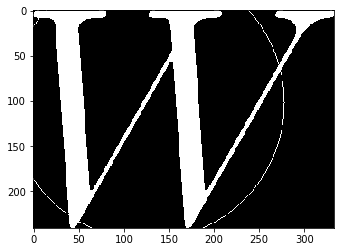

3
35 291
9 279


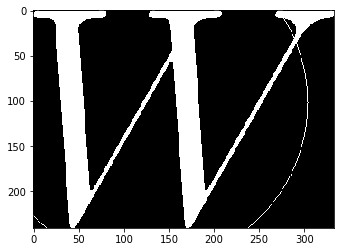

2
13 310


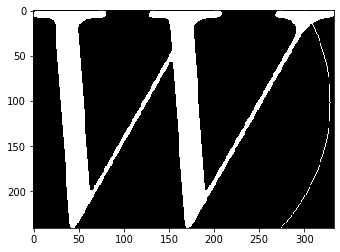

1


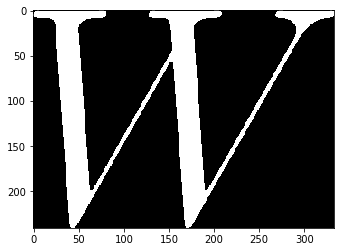

137 144
100 157
126 126
137 143


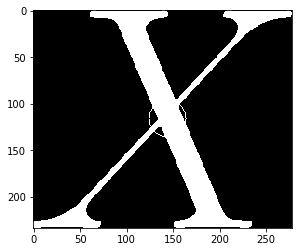

4
157 151
85 171
76 144
141 112


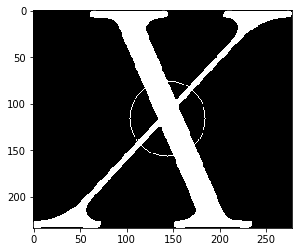

4
176 159
70 185
56 135
157 97


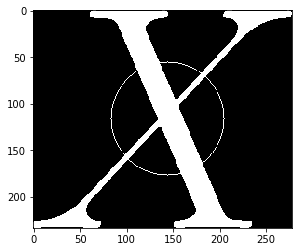

4
195 168
55 199
37 127
171 83


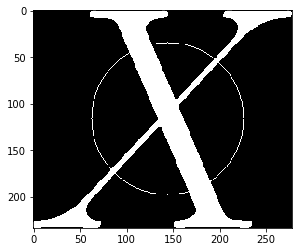

4
215 175
40 213
17 120
186 69


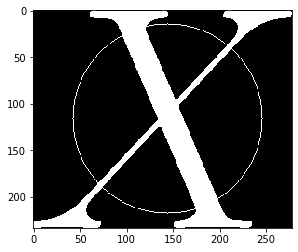

4
232 187
26 227
1 103
201 55


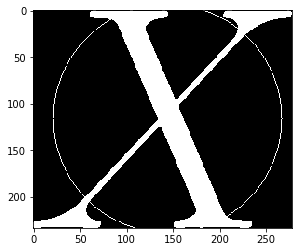

4
233 228
14 245
215 39


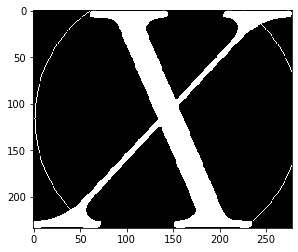

3
8 268
224 20


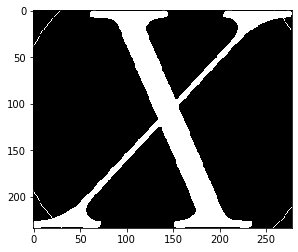

2


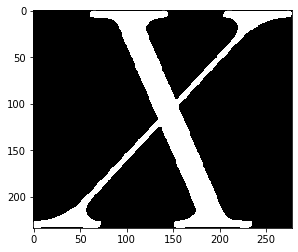

120 88
81 81


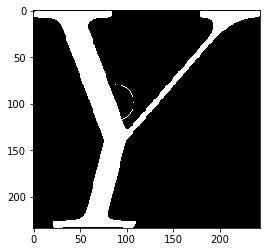

2
141 88
138 101
106 128
61 74
138 75


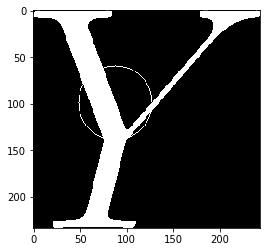

5
161 88
85 147
42 67
159 72


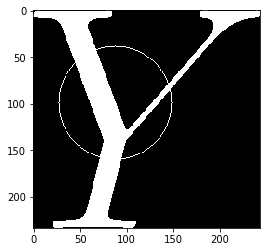

4
182 88
66 163
23 60
179 67


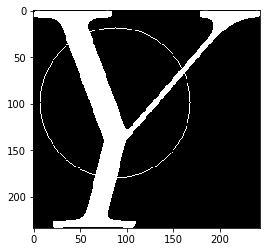

4
50 177
1 64
199 62


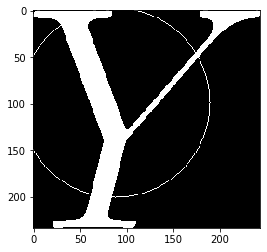

3
34 191
1 16
218 56


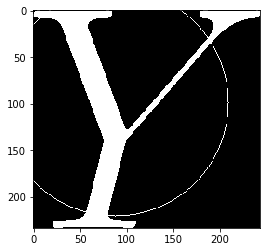

3
20 206
227 22


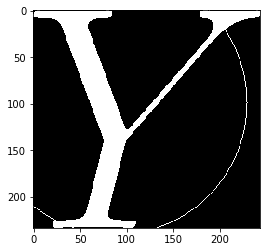

2
10 225


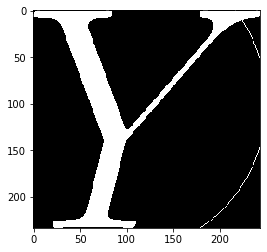

1


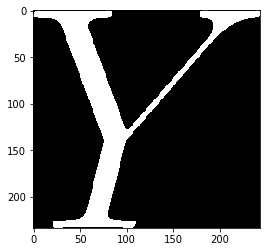

111 128
120 95


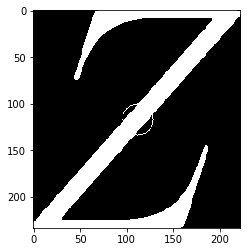

2
96 141
136 81


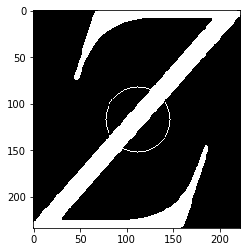

2
83 153
150 69


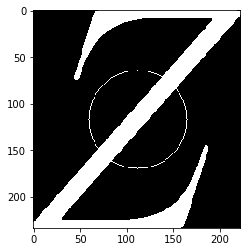

2
69 165
163 57


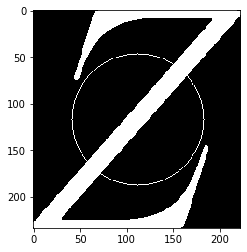

2
190 165
176 179
56 177
45 60
57 48
177 45


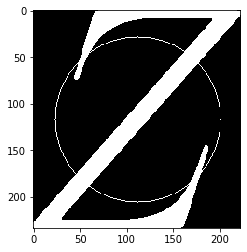

6
225 112
43 188
11 105
190 33
224 104


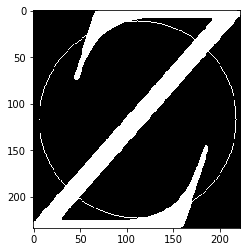

5
233 158
30 200
8 172
3 65
203 22
225 48


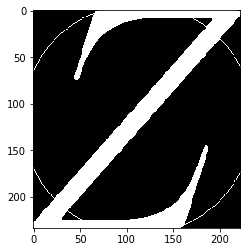

6
16 212
216 10


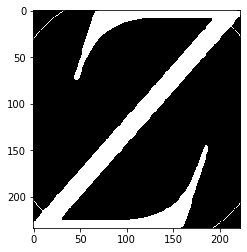

2


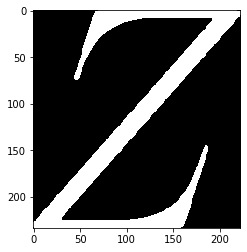

146 97
100 72


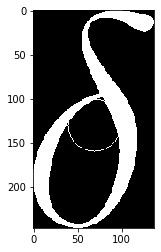

2
168 97
102 106
127 24


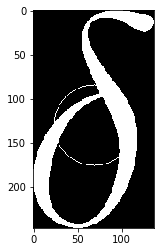

3
187 94
172 115
70 83
147 11


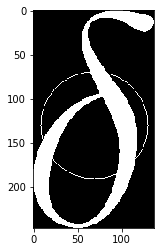

4
205 89
53 71
168 3


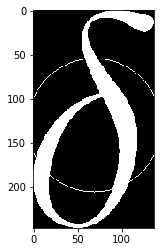

3
222 81
38 64
190 0


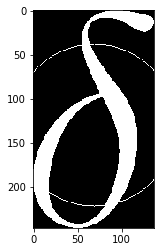

3
238 70
23 61
216 5
229 25
238 65


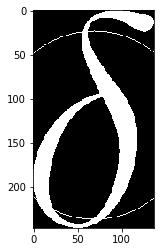

5
23 129
9 93


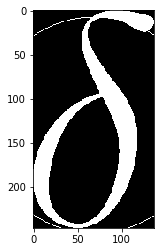

2


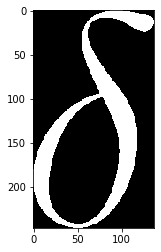

166 148
112 152
101 143
96 91


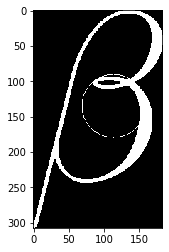

4
200 136
87 162
95 58


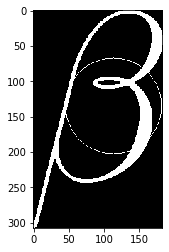

3
226 113
69 175
54 72
177 32
226 113


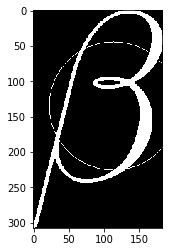

5
45 182
23 94
207 25
215 33
228 47
236 59


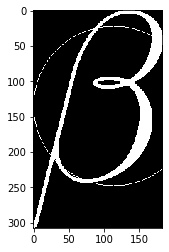

6
9 165
233 18


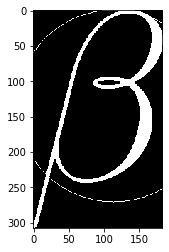

2
258 12


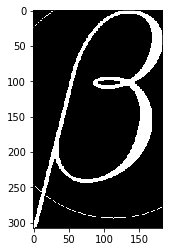

1
282 6


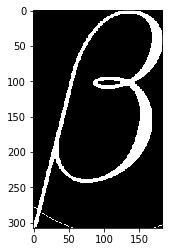

1


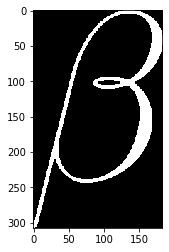

125 81
118 54


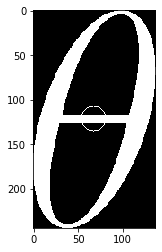

2
125 96
118 40


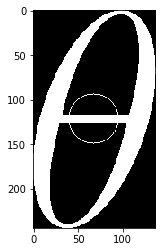

2
153 97
91 38


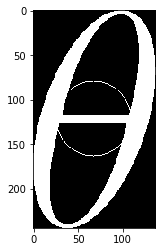

2
174 90
70 45


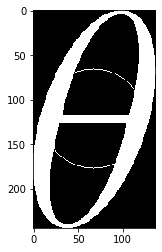

2
190 84
97 133
53 52
146 2


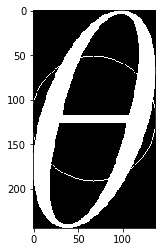

4
206 75
72 136
38 60
171 0


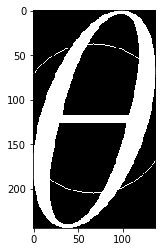

4
220 68
50 135
36 117
23 69
194 1
220 66


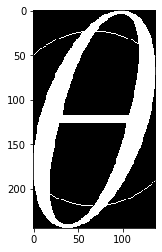

6
28 130
10 82
216 6
233 54


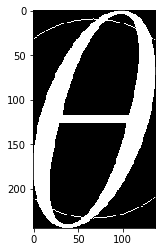

4


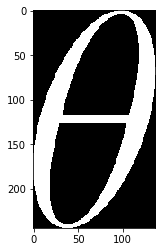

112 122


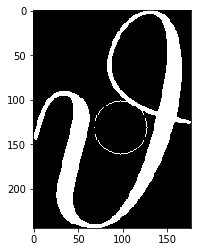

1
171 123
86 95
107 60


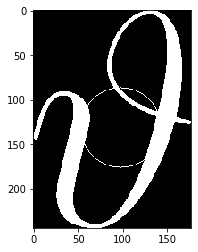

3
191 115
178 138
124 159
72 89
95 50
144 39


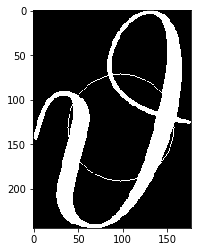

6
208 107
203 124
127 175
94 164
57 88
91 35
169 33


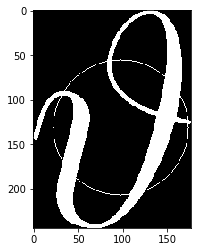

7
223 99
71 166
41 91
108 11
189 28
223 97


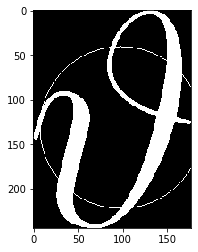

6
49 165
25 99
209 26
237 80


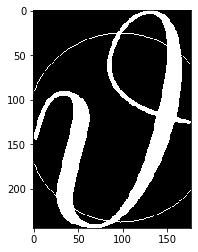

4
28 161
11 112


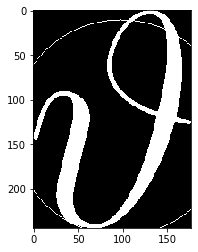

2


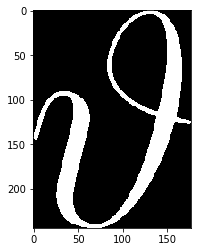

175 15
197 20


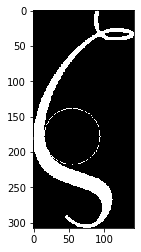

2
239 56
126 24
146 5
213 7


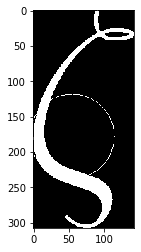

4
255 79
100 35


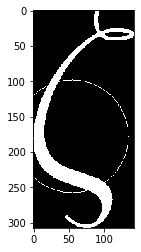

2
271 96
77 50


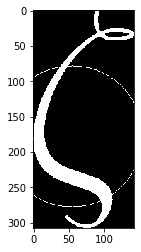

2
299 56
294 92
58 66
299 52


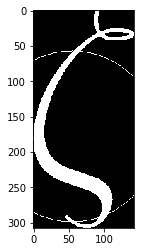

4
40 87


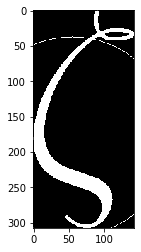

1
39 138
30 121
21 92


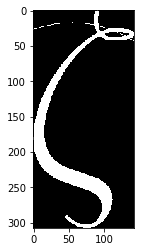

3


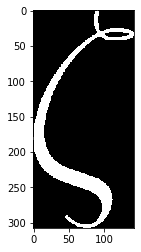

146 107
148 80


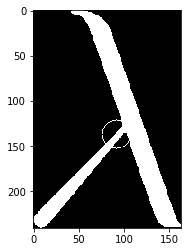

2
163 113
121 120
159 69


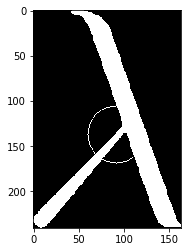

3
179 118
92 110
171 57


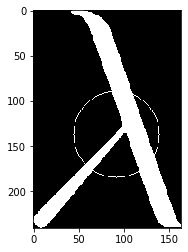

3
195 124
73 103
182 46


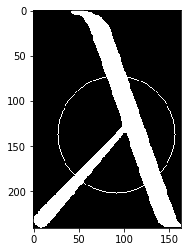

3
210 129
56 97
194 34


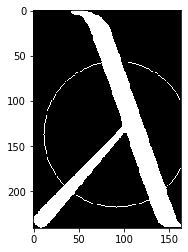

3
226 135
40 91
205 23


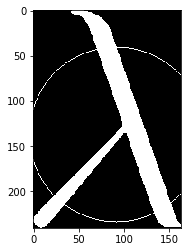

3
239 145
24 86
217 11


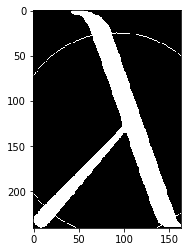

3
9 76
229 1


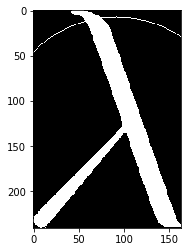

2


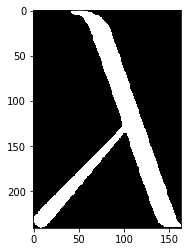

79 71
67 64
74 50


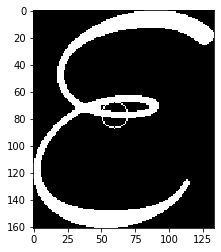

3
78 81
68 41


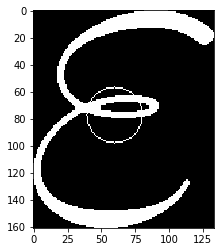

2
72 92
65 31


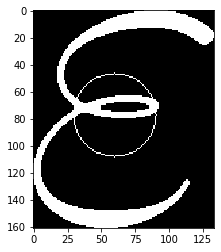

2
55 24
83 18


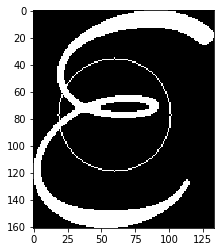

2
37 25
92 10


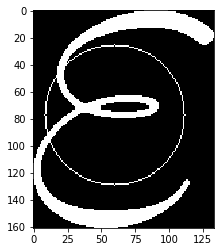

2
14 68
21 32
104 3


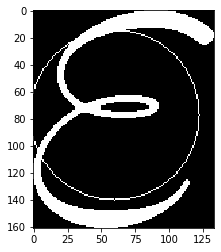

3
151 60
13 98
120 0
131 9
143 25


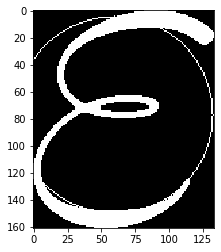

5
25 127
146 12
159 39


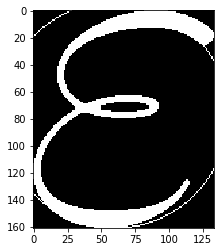

3


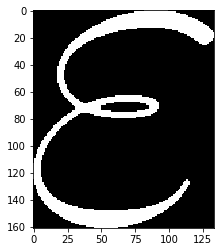

94 123


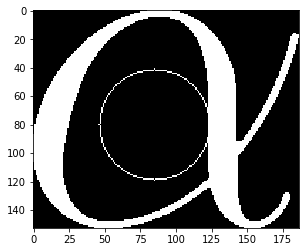

1
125 114
118 123


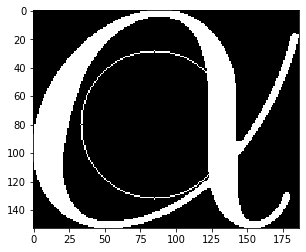

2
132 127
94 150
45 141
26 48
145 74


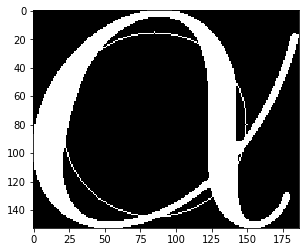

5
143 134
73 164
9 119
4 66
46 15
147 43


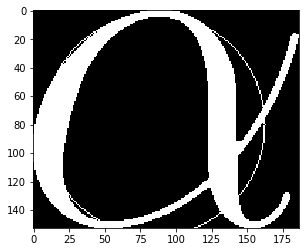

6
151 145
53 174
125 6


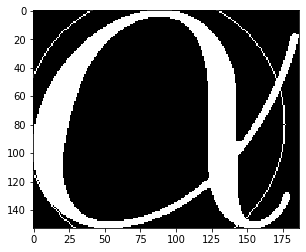

3
150 164
36 181


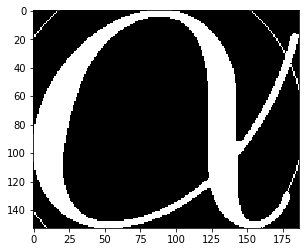

2


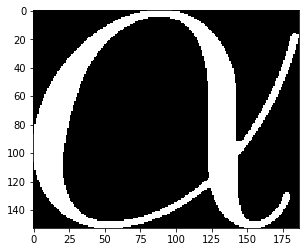

93 115
42 109
36 97


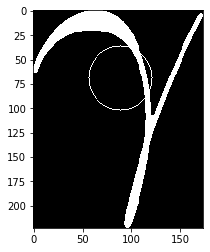

3
114 115
98 132
78 140
20 99


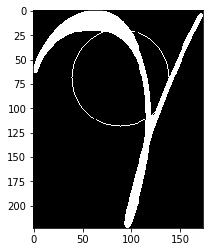

4
133 114
46 154
3 80
24 39


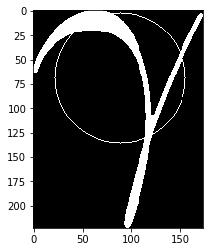

4
152 109
26 163
20 22
55 6


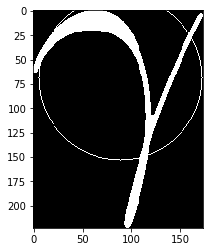

4
170 104
9 171


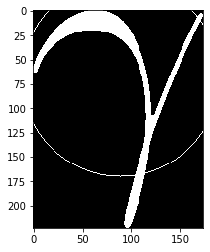

2
188 99


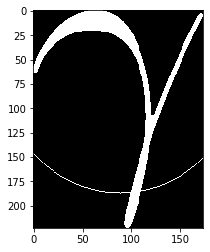

1
205 95


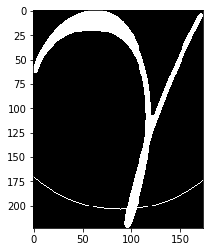

1


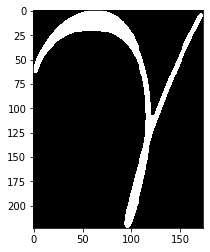

128 114
62 56


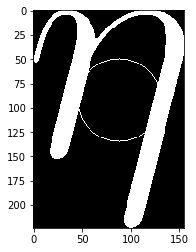

2
147 110
130 133
79 145
38 65
66 36
89 30


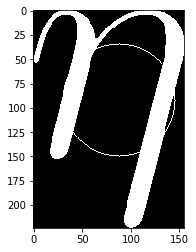

6
163 106
154 127
55 152
19 80
24 63
121 22


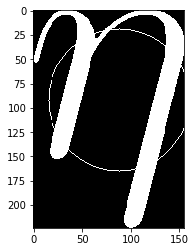

6
179 101
34 154
5 103
10 56
142 17


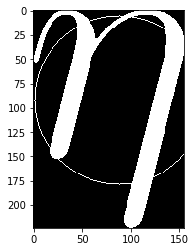

5
194 98
1 42
20 15
35 4


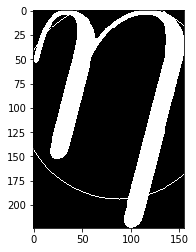

4
209 94


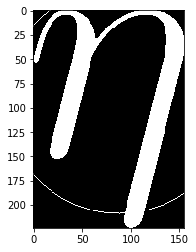

1


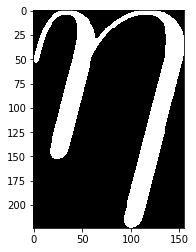

90 30
73 35


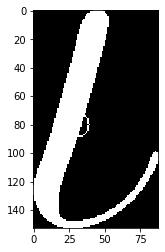

2
64 38
86 12


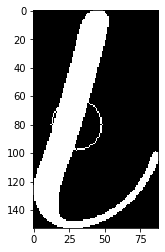

2
55 40
98 8


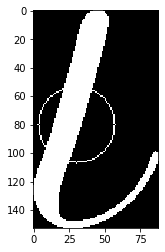

2
47 43
107 5


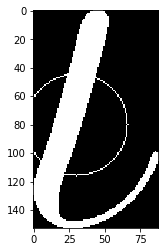

2
37 45
117 2


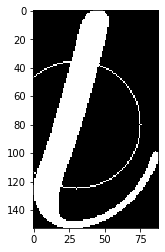

2
28 48
127 0


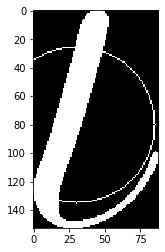

2
144 45
129 72
20 50
139 4


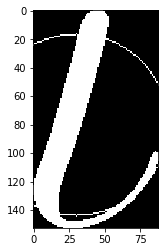

4
11 52


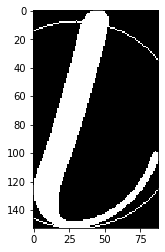

1


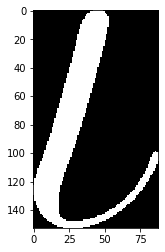

76 80
66 66


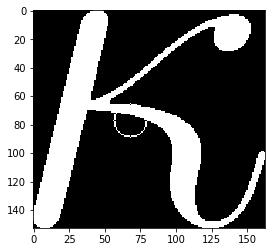

2
84 92
54 66


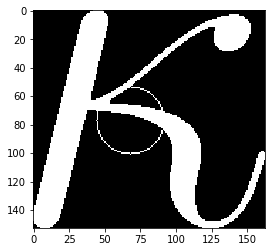

2
99 98
43 80
52 42


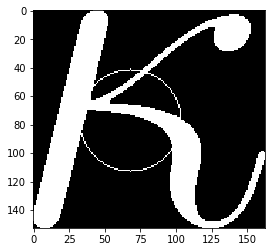

3
118 96
34 90
35 46


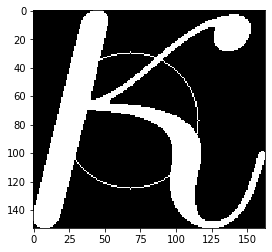

3
131 97
116 115
26 100
20 49
97 11


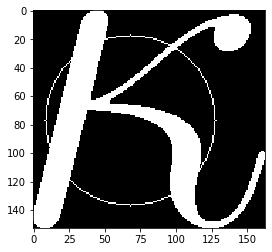

5
142 103
18 110
7 52
116 7


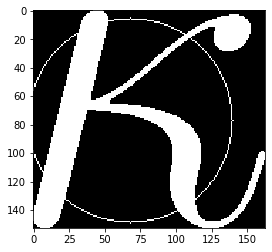

4
150 113
28 137
12 122
131 3


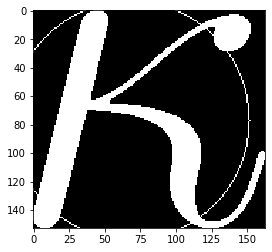

4
152 130
23 148
146 0


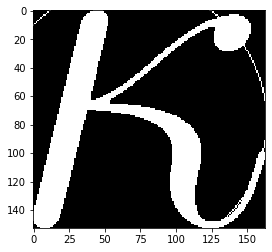

3


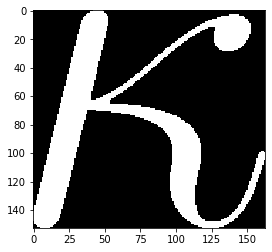

68 47


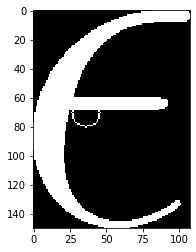

1
68 58
49 30


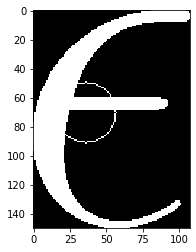

2
68 69
38 35


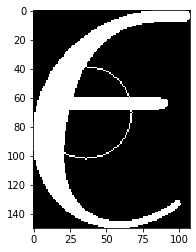

2
68 80
27 43
30 21
95 0


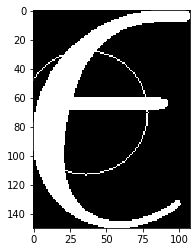

4
66 91
18 53
116 6


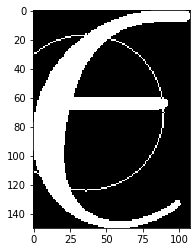

3
11 65
134 19


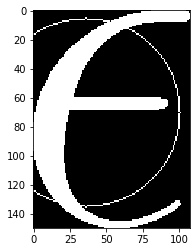

2
147 41
8 81


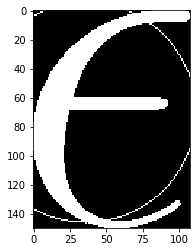

2
144 83
7 97


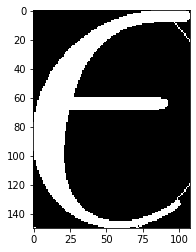

2


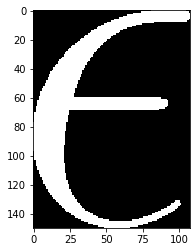

136 85
128 71
146 28


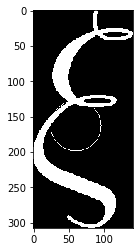

3
135 107
124 100
109 52
176 6


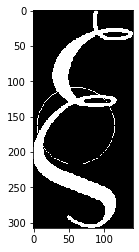

4
237 60
90 50
205 0


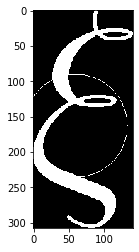

3
255 60
71 55
255 59


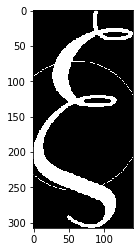

3
269 94
53 66


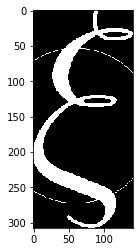

2
286 101
279 116
42 105
37 86
292 48


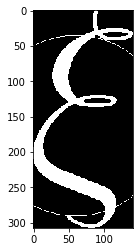

5
38 137
31 126
19 89


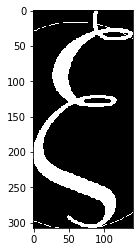

3


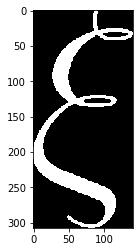

144 94
178 81


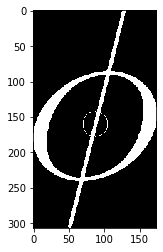

2
126 98
196 76


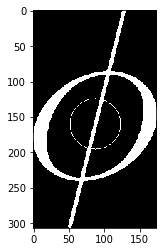

2
108 103
214 72


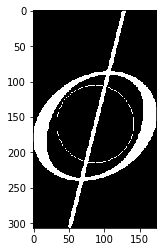

2
235 87
232 106
212 140
129 154
90 110
125 23
232 67
235 80


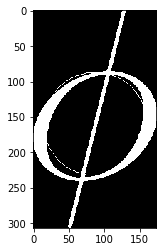

8
72 112
196 2
222 18
250 63


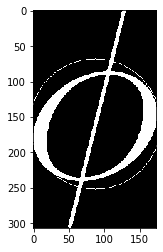

4
54 116
268 58


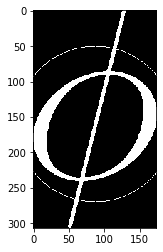

2
36 121
286 54


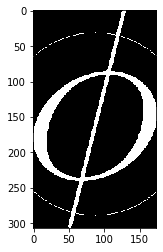

2
18 125
304 49


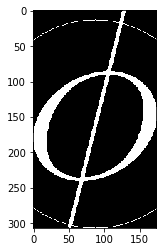

2


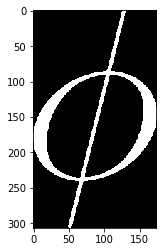

172 104
152 114


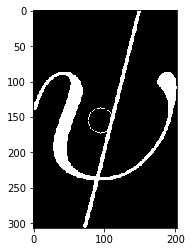

2
192 99
128 120


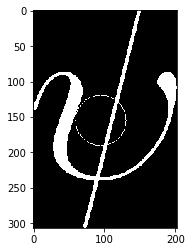

2
211 96
109 124
108 69
211 94


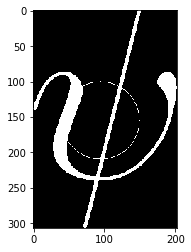

4
91 129
92 59
186 28
229 90


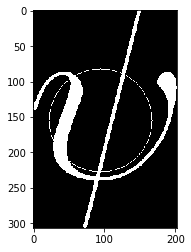

4
176 185
72 134
89 33
106 18
119 11
133 6
247 85


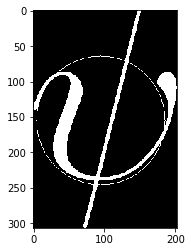

7
122 200
54 138
265 81


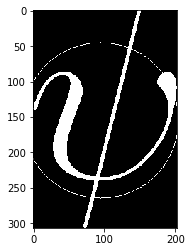

3
36 143
283 76


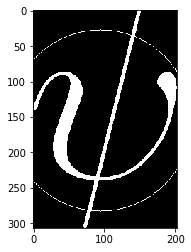

2
18 147
301 72


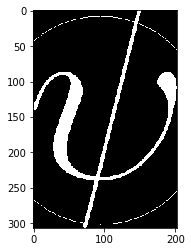

2


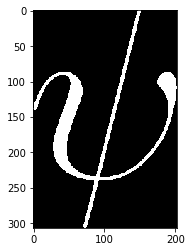

114 96
84 99
104 83


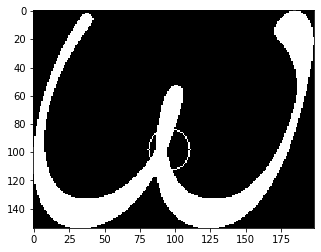

3
129 96
69 104
117 73
128 90


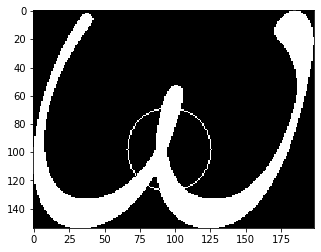

4
144 100
54 104
126 61


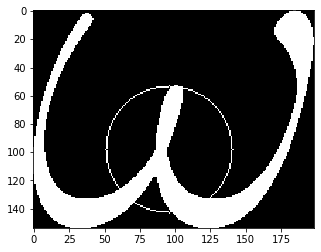

3
153 121
132 47


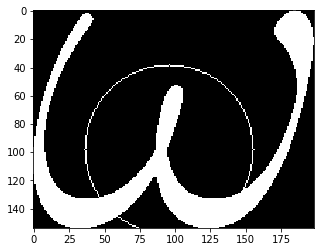

2
128 165
101 172
132 29


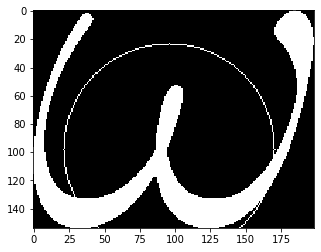

3
85 185
75 9


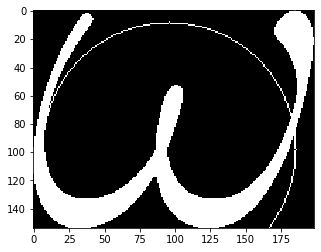

2
56 193
41 185
10 40
27 20


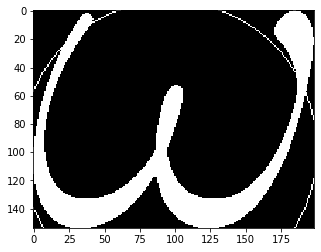

4
33 197


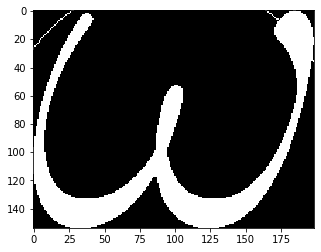

1


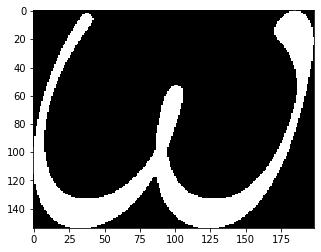

86 51


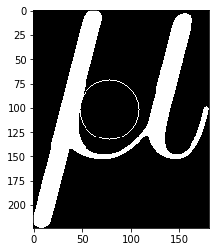

1
149 79
146 94
129 118
60 57
145 58


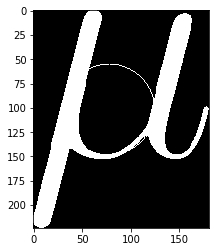

5
144 126
100 141
41 62
128 21


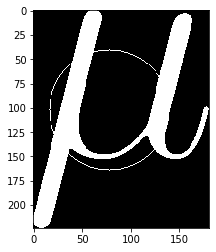

4
151 140
68 149
24 66
149 16


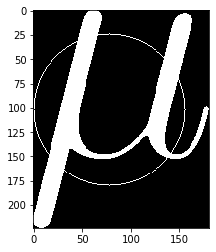

4
146 162
110 173
46 154
8 70
168 11


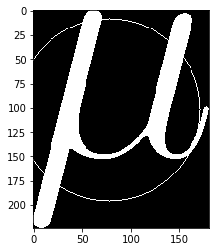

5
28 159
185 7


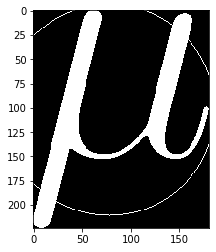

2
9 163
202 3


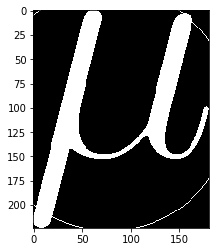

2


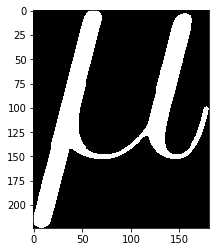

55 42


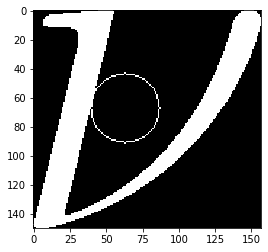

1
34 47


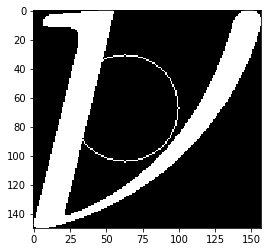

1
118 67
111 88
99 102
20 50
34 28
83 16


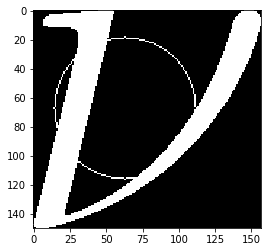

6
72 126
7 53
101 12
129 50


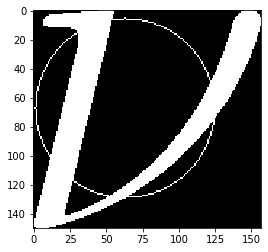

4
55 137
2 30
117 8
137 35


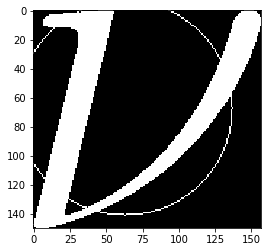

4
38 146
131 4


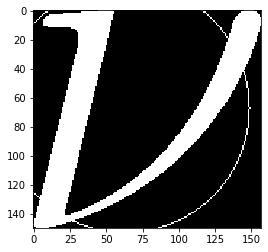

2
23 152
144 1


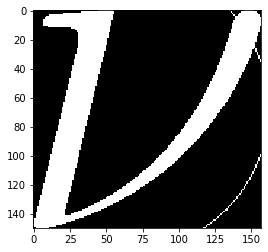

2


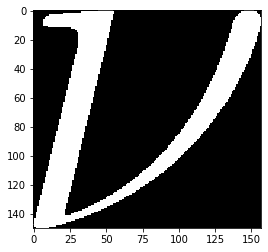

80 52


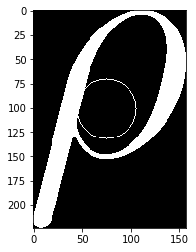

1
148 76
57 59
84 32
139 49
148 69


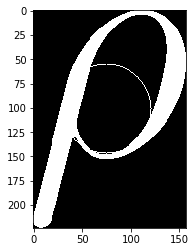

5
113 137
39 66
131 21


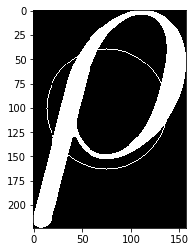

3
83 151
23 77
151 16


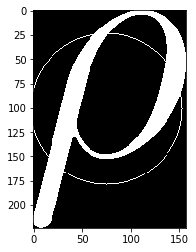

3
54 156
9 93
169 11


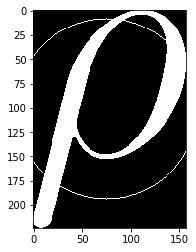

3
19 147
186 7


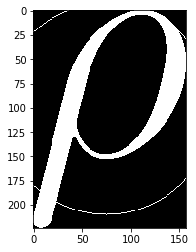

2
203 3


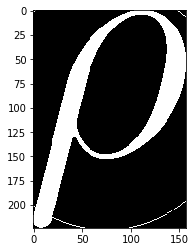

1


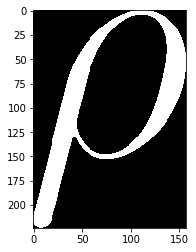

49 63


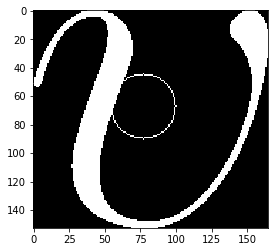

1
34 68


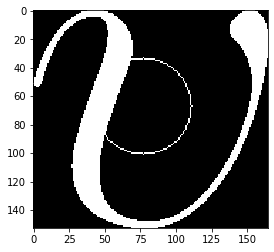

1
22 69
80 33


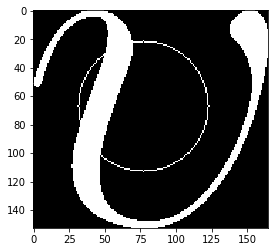

2
11 65
98 28


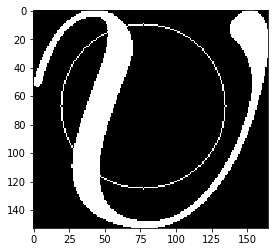

2
109 134
99 140
86 145
2 55
116 28


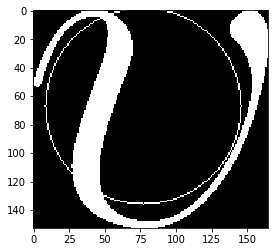

5
149 77
141 111
62 158
7 24
139 39


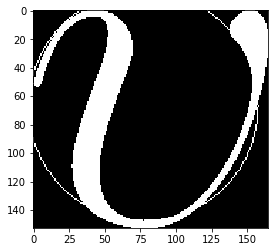

5
33 164


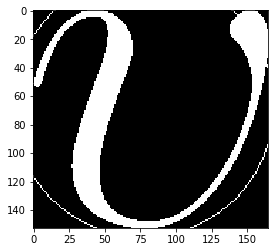

1


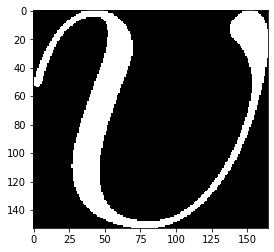

94 80


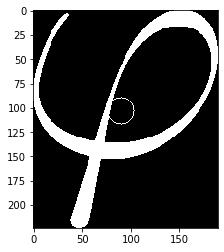

1
75 86
120 68


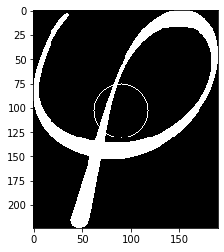

2
146 91
61 92
134 60


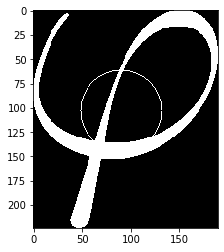

3
133 139
47 100
128 39
150 58


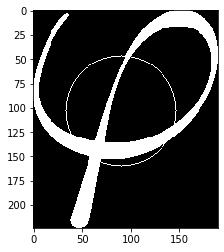

4
114 161
35 110
115 20
164 54


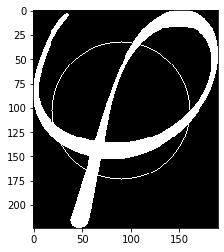

4
93 176
24 122
90 6
111 6
178 50


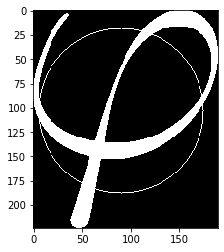

5
72 185
16 140
36 17
51 6
192 45


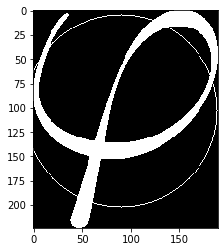

5
46 189
25 174
4 36
10 26
206 41


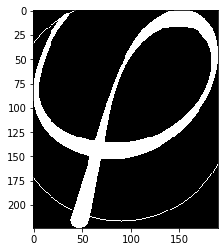

5


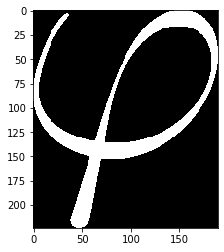

125 93
99 105
119 81


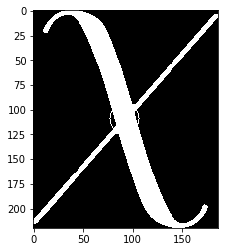

3
141 93
88 115
78 94
132 71
141 92


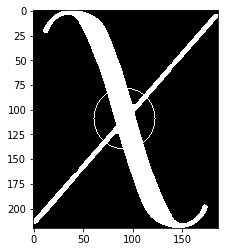

5
156 96
76 125
63 90
143 60


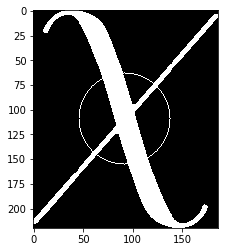

4
172 102
64 136
48 85
155 50


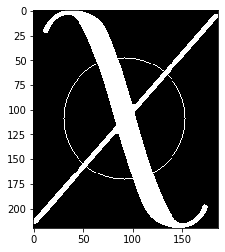

4
187 107
52 146
32 79
167 39


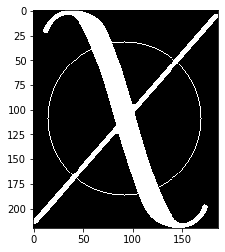

4
201 113
41 156
18 73
179 29


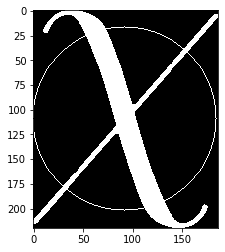

4
214 126
29 167
5 60
190 19


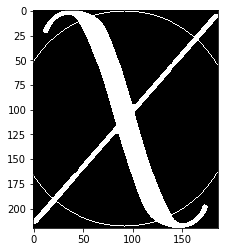

4
219 153
205 173
17 177
0 33
202 8


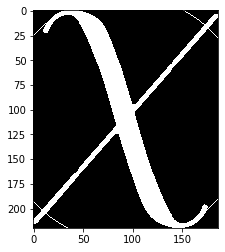

5


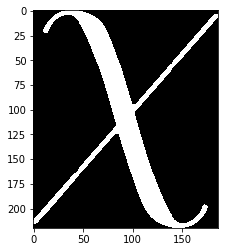

73 107
39 72


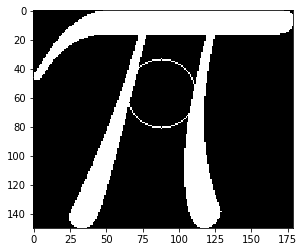

2
90 105
40 120
23 76
71 55


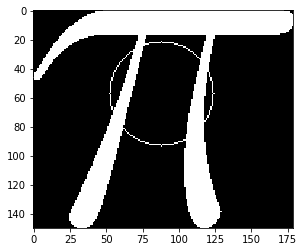

4
103 104
24 123
16 114
85 49


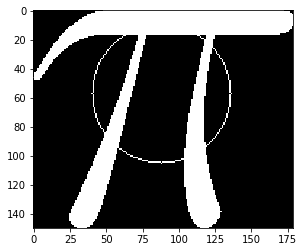

4
116 104
16 133
98 44


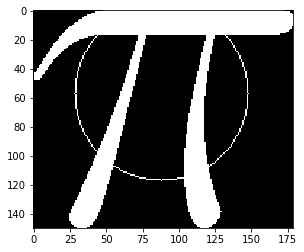

3
128 105
16 148
1 43
26 22
110 39


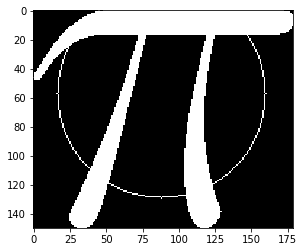

5
140 108
16 163
33 7
122 33


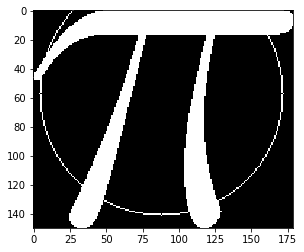

4
149 118
14 175
133 28


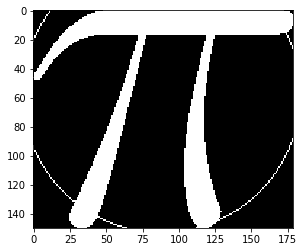

3


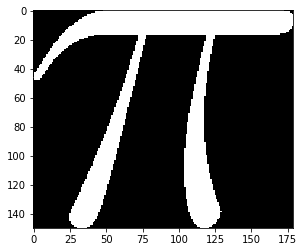

79 110


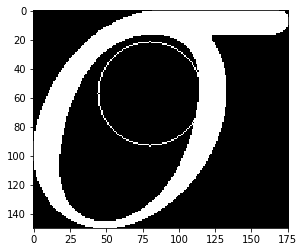

1
101 103
50 32


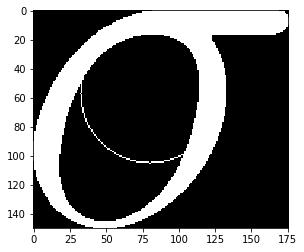

2
117 94
16 124
32 26


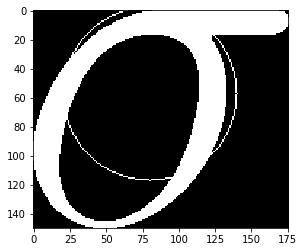

3
130 83
16 140
61 8


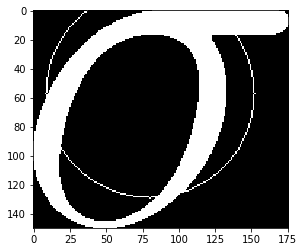

3
16 154
86 1
141 66


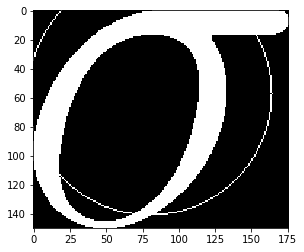

3
15 167
114 2


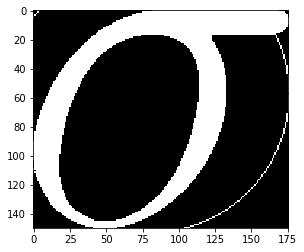

2


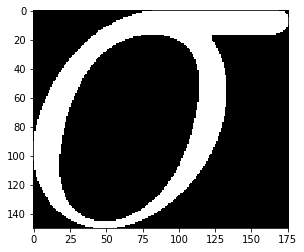

57 76
35 83
55 70


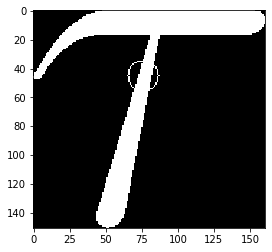

3
69 76
23 86
67 66


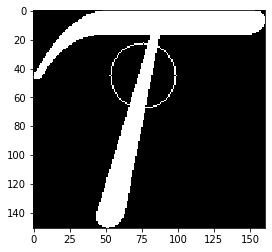

3
16 98
78 63


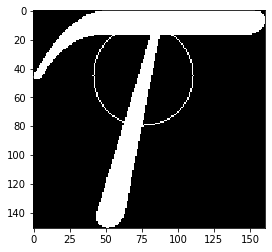

2
16 115
90 59


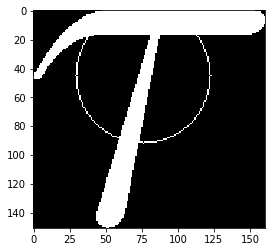

2
16 129
6 32
101 56


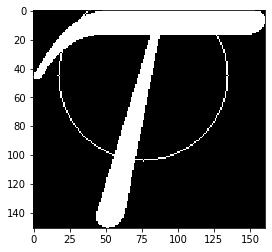

3
16 142
37 5
113 52


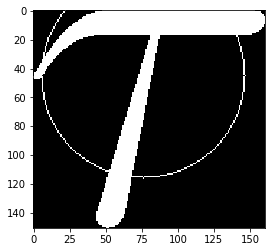

3
14 155
124 49


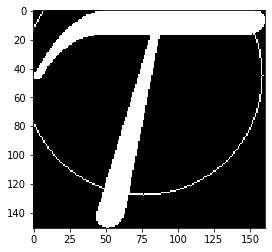

2
136 45


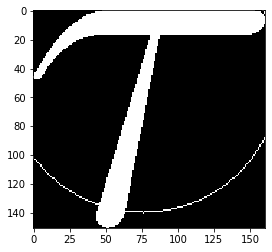

1


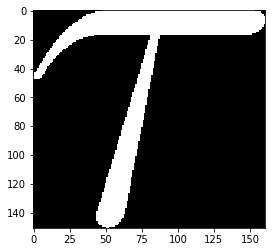

181 187
111 153


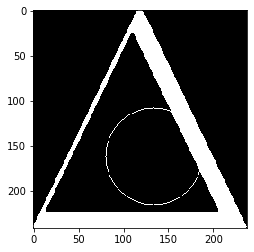

2
236 135
202 197
99 169
224 94


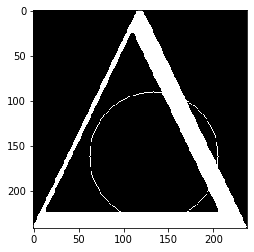

4
241 181
220 206
75 157
94 75
106 64
144 46
224 67


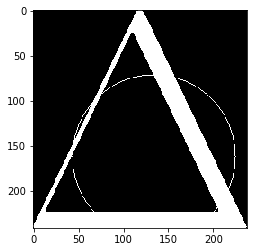

7
241 211
55 148
63 90
183 27
224 44


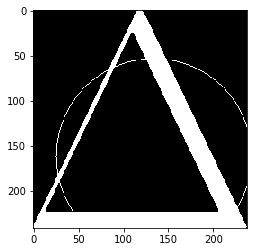

5
241 235
36 139
40 101
208 15
224 23


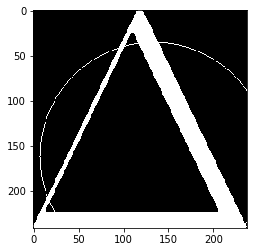

5
17 130
229 5


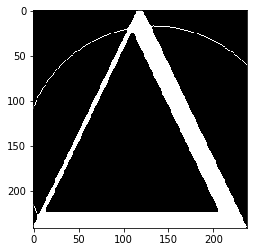

2


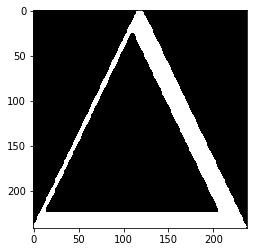

148 131


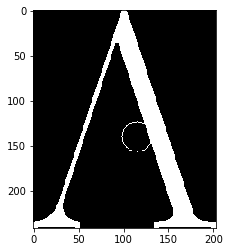

1
167 138
139 149
123 144


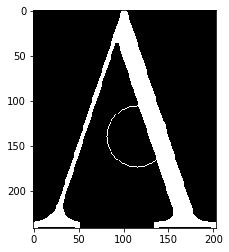

3
184 143
93 134


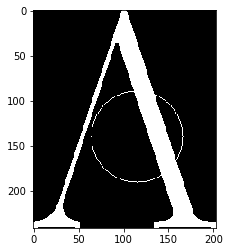

2
200 148
74 127
86 74
152 48


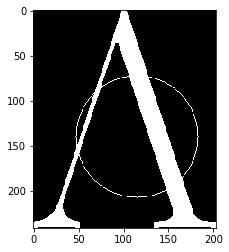

4
217 154
56 122
62 82
179 39


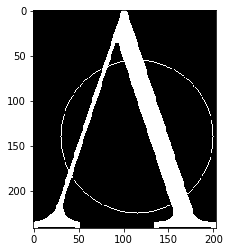

4
241 134
39 116
42 89
200 33


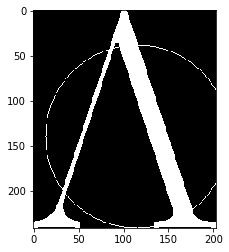

4
240 180
22 110
218 26


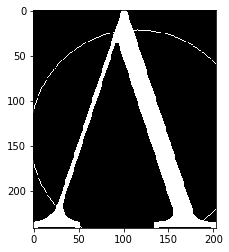

3
5 105
231 13


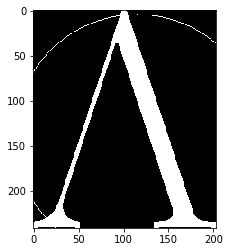

2


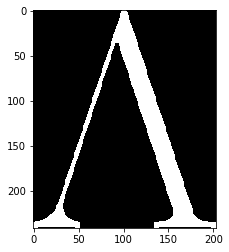

185 179
61 180
62 32


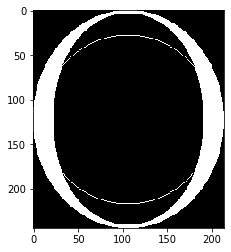

3
221 154
171 204
84 208
25 157
26 54
80 6
161 5
220 57


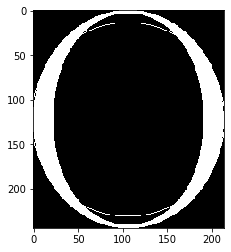

8


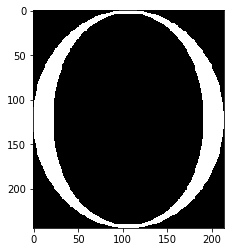

110 107
83 119
77 104
106 96


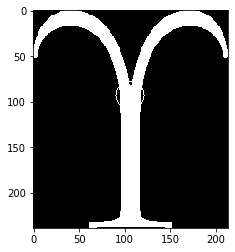

4
127 107
65 123
60 100
126 97


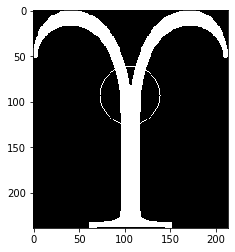

4
144 107
48 129
44 95
143 97


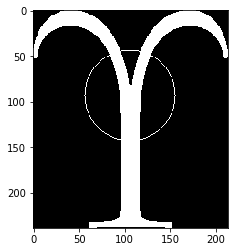

4
161 107
34 137
29 88
160 97


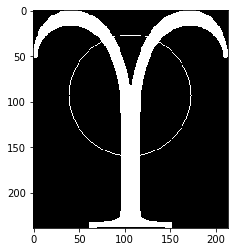

4
178 107
22 151
15 77
177 97


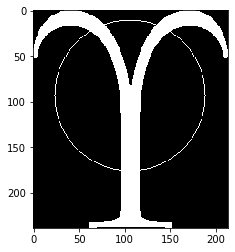

4
194 107
17 173
4 61
194 97


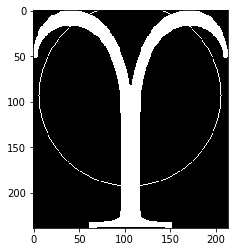

4
211 107
45 213
211 97


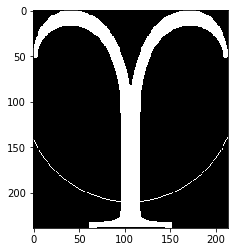

3
228 107


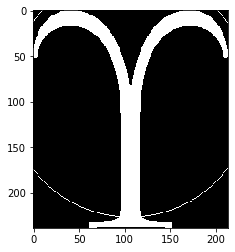

1


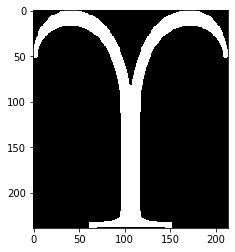

161 154
129 35
161 47


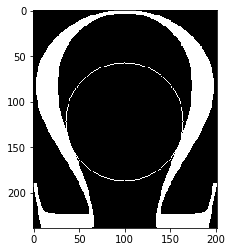

3
193 142
185 153
140 180
88 26
185 48
194 59


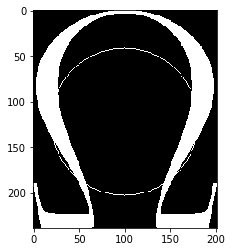

6
214 137
102 196
53 170
53 31
212 60


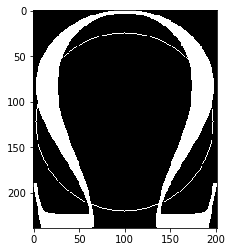

5
232 135
56 193
17 145
16 58
224 46


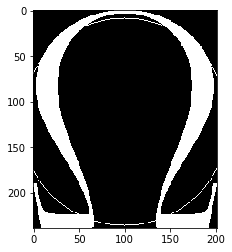

5
238 162
219 190
211 4
220 12


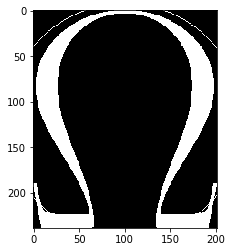

4


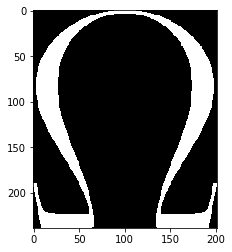

135 30
111 38
133 23


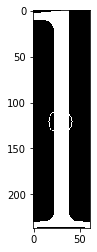

3
148 30
96 38
147 23


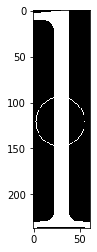

3
162 30
81 38
161 23


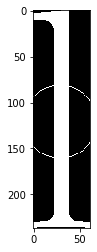

3
175 30
68 38
175 23


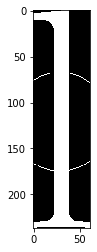

3
189 30
54 38
188 23


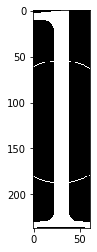

3
202 30
40 38
202 23


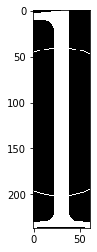

3
216 30
27 38
215 23


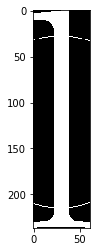

3
229 30
13 38
228 16


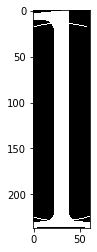

3


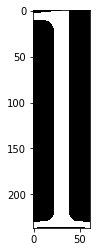

95 81


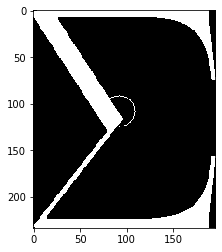

1
80 72
137 74


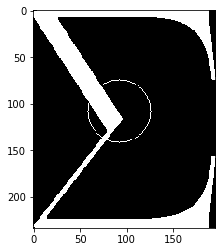

2
66 63
151 63


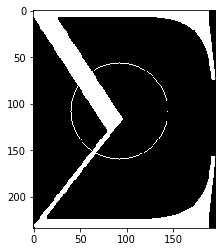

2
51 53
165 52


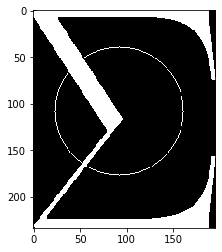

2
37 44
178 42


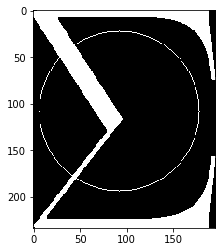

2
73 191
7 118
22 34
192 31


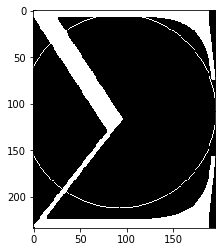

4
230 93
222 137
188 185
38 191
206 20
224 54


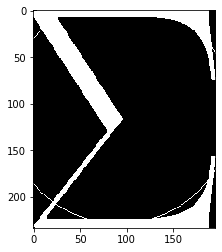

6
233 153
8 188
219 10


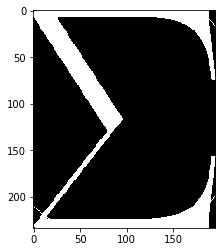

3


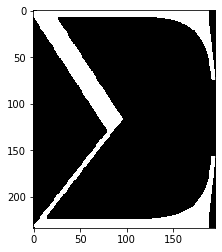

130 97
106 106
126 88


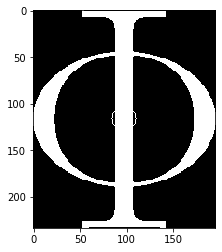

3
144 97
90 106
142 88


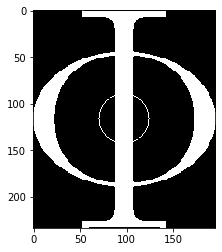

3
158 97
76 106
157 88


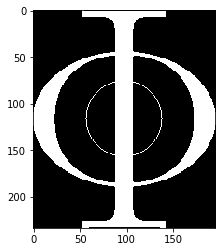

3
172 97
62 106
171 88


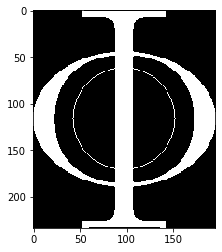

3
186 97
49 116
49 80
185 85


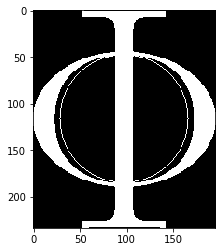

4
200 97
174 157
61 159
34 106
61 36
173 37
199 88


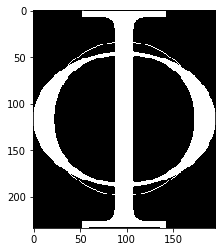

7
213 97
135 192
104 193
20 106
104 1
132 2
213 88


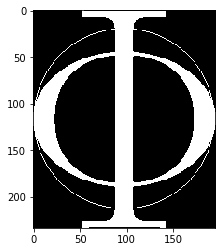

7
227 97
7 118
226 78


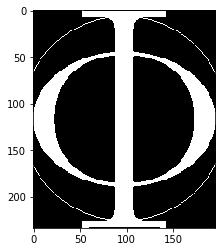

3


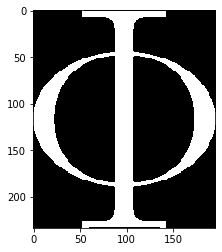

128 106
103 115
124 97


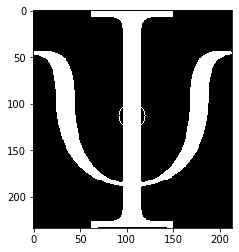

3
142 106
87 115
140 97


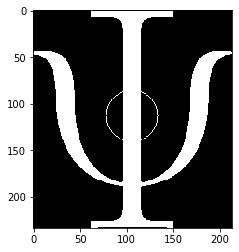

3
156 106
72 115
155 97


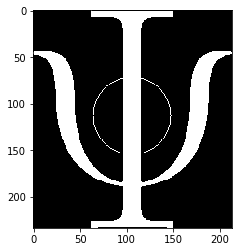

3
170 106
58 115
169 97


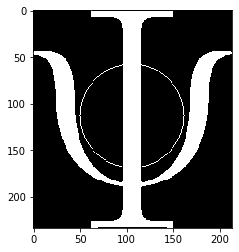

3
184 106
181 129
44 115
81 43
178 76
184 96


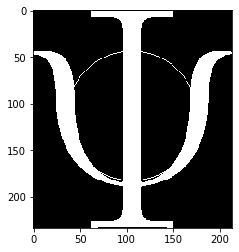

6
198 106
94 188
29 115
61 39
198 97


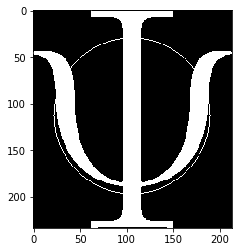

5
213 106
64 192
15 116
49 31
212 97


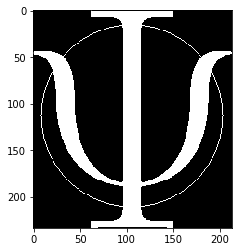

5
227 106
52 200
7 145
44 17
225 87


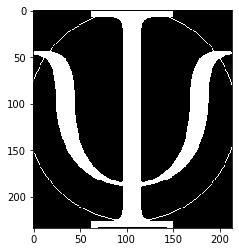

5


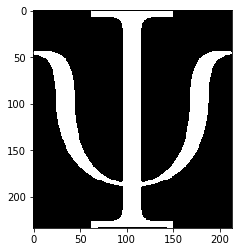

84 47


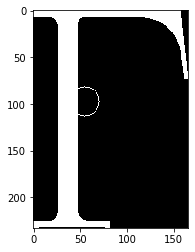

1
67 47
113 27


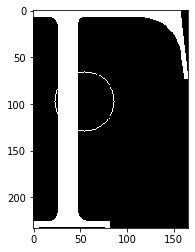

2
50 47
137 27


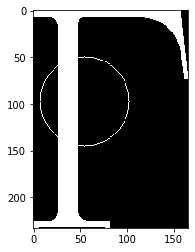

2
34 47
156 27


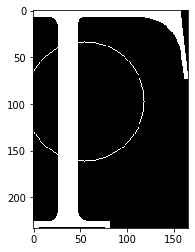

2
18 47
173 27


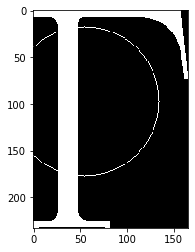

2
6 86
190 27


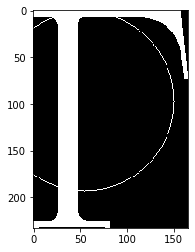

2
73 165
9 125
207 27


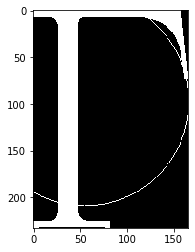

3
227 55
24 160
223 22


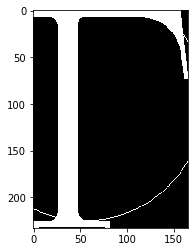

3


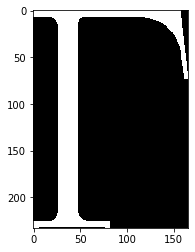

118 152


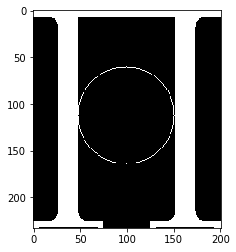

1
158 152
66 47


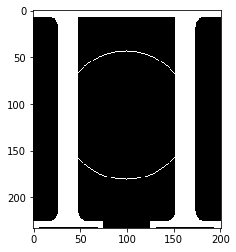

2
182 152
65 172
43 47
159 27


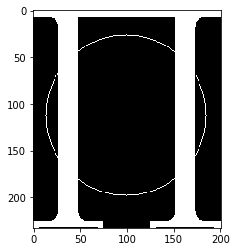

4
202 152
37 172
22 47
186 27


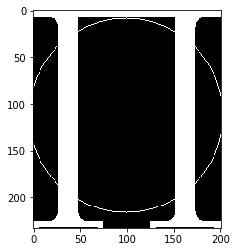

4
231 125
15 173
209 27


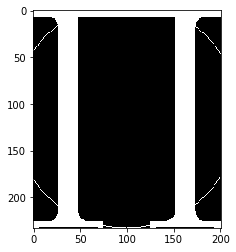

3
231 171
6 190
225 18


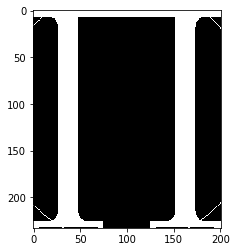

3


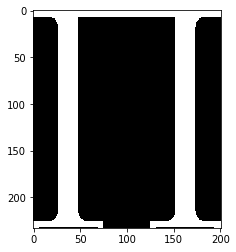

86 29


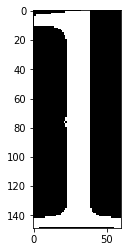

1
94 29
62 38
93 23


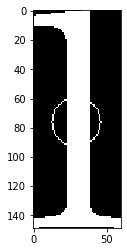

3
103 29
52 38
102 23


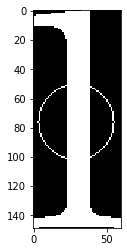

3
112 29
43 38
111 23


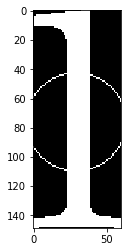

3
121 29
34 38
120 23


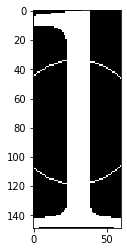

3
129 29
25 38
129 23


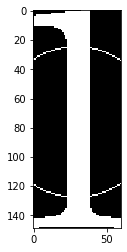

3
138 29
16 38
138 20


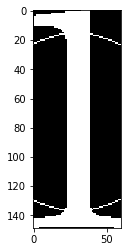

3
147 29
8 38
142 2


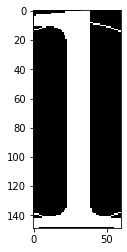

3


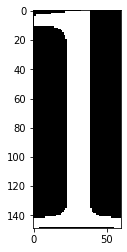

94 117
68 129
94 114


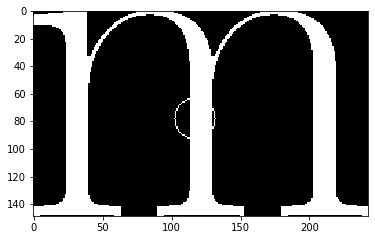

3
110 117
49 130
110 114


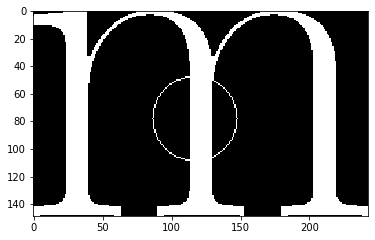

3
126 117
34 133
126 114


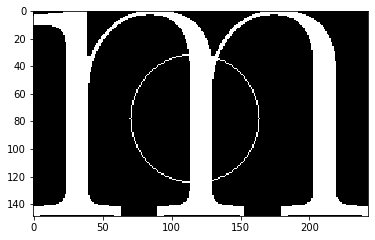

3
142 117
20 141
15 122
141 105


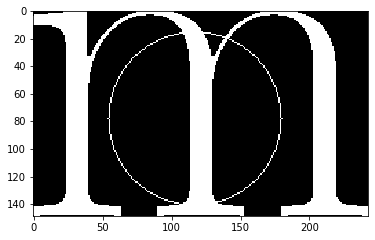

4
8 154
1 101
64 39


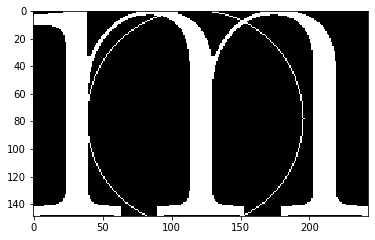

3
148 182
121 203
2 175
26 38
93 24
134 40


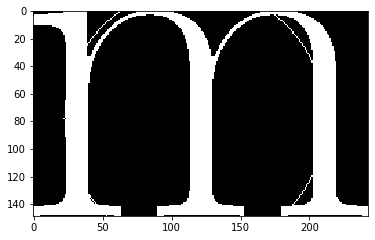

6
147 204
32 218
4 199
1 38
136 22


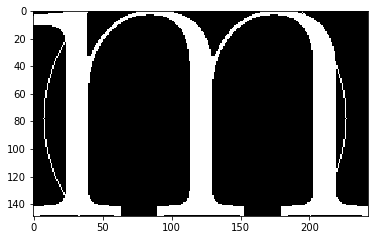

5
147 224
2 17
142 8


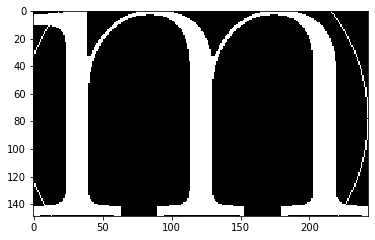

3


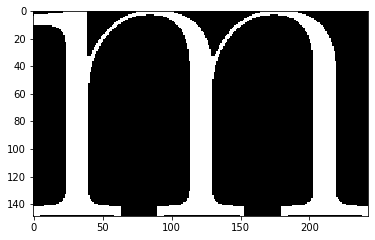

212 96
173 111
207 82


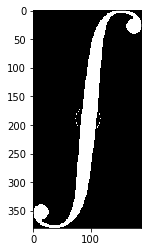

3
234 96
148 113
231 80


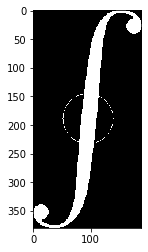

3
257 96
125 115
254 78


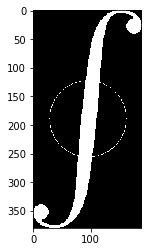

3
279 96
102 116
277 77


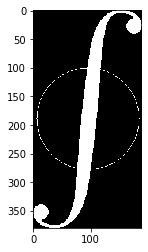

3
80 118
300 75


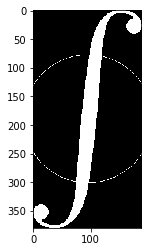

2
57 120
322 72


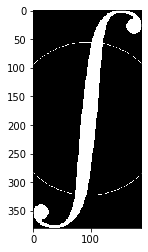

2
35 124
344 68


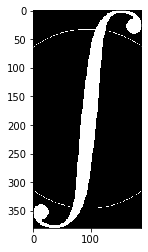

2
34 186
14 132
344 4
365 58


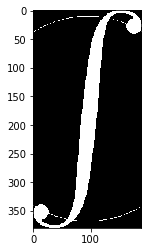

4


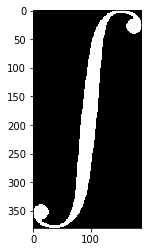

155 75
188 53


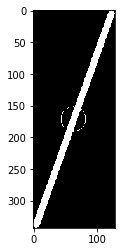

2
135 82
207 46


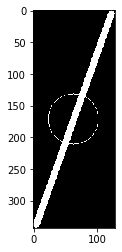

2
116 89
226 39


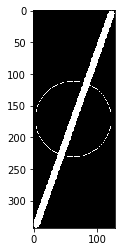

2
97 95
245 32


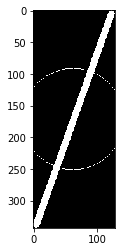

2
78 102
264 26


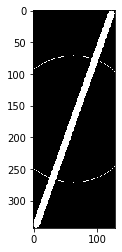

2
59 109
283 19


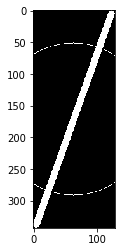

2
40 116
302 12


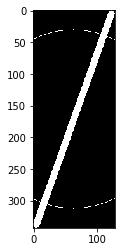

2
21 122
321 5


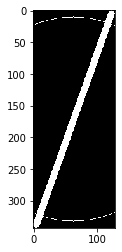

2


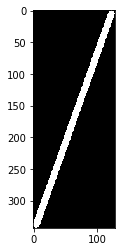

83 13
64 22
80 4


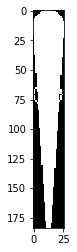

3
96 13
49 23
95 5


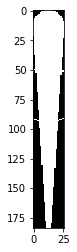

3
108 13
36 24
108 6


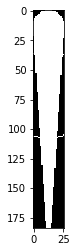

3
121 13
23 25
120 7


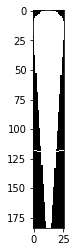

3
133 13
10 25
133 8


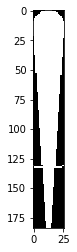

3
146 13


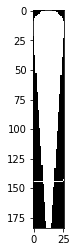

1
158 13


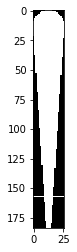

1
171 13


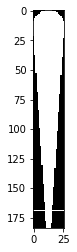

1


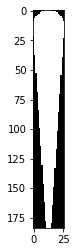

118 106
111 117
96 111
102 96
117 102


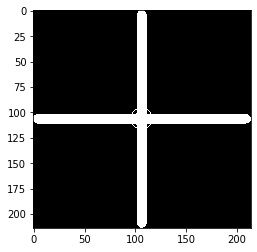

5
130 106
111 130
83 111
102 83
130 102


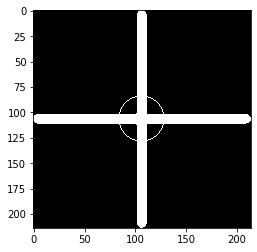

5
142 106
111 142
71 111
102 71
142 102


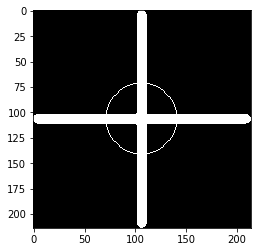

5
154 106
111 154
59 111
102 59
154 102


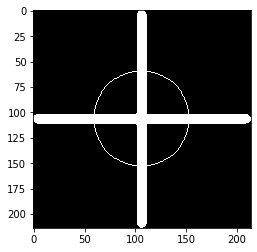

5
166 106
111 165
47 111
102 47
165 102


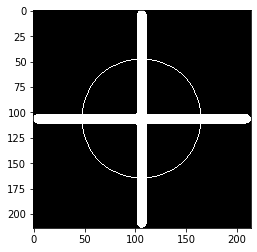

5
177 106
111 177
36 111
102 36
177 102


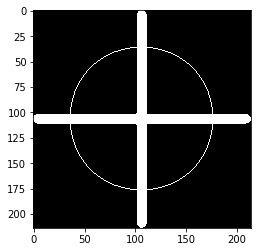

5
189 106
111 189
24 111
102 24
189 102


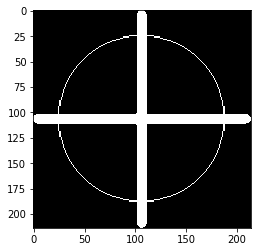

5
201 106
111 201
12 111
102 12
201 102


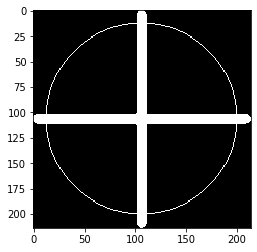

5


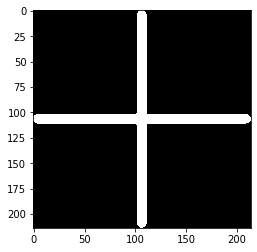

262 131
191 177


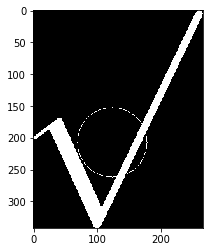

2
290 124
160 192
176 47
226 44
255 57
290 117


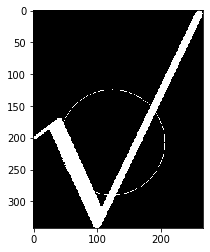

6
132 205
187 16
309 82


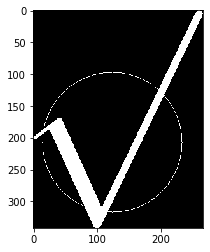

3
106 218


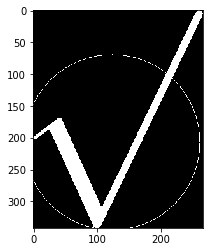

1
79 230


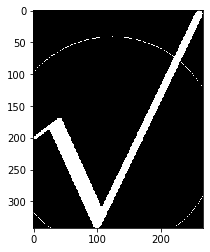

1
54 243


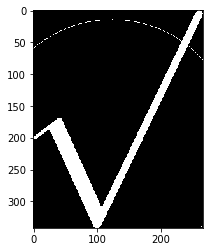

1
29 255


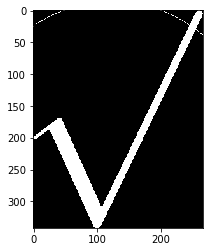

1


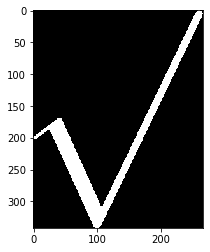

139 104
50 113
116 64


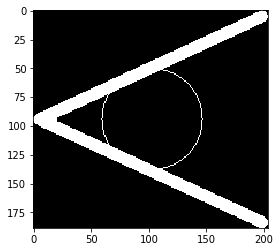

3
152 118
41 132
68 50
108 45


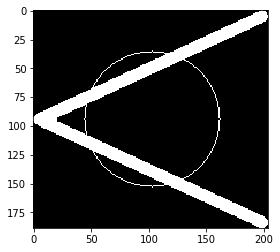

4
161 138
34 148
77 31
100 29


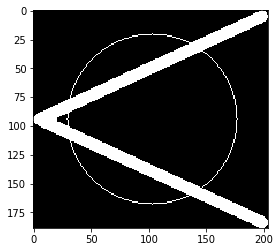

4
168 154
27 163
85 14


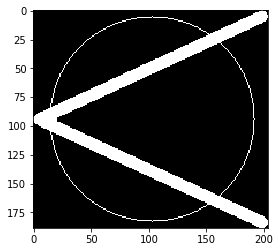

3
176 170
20 178


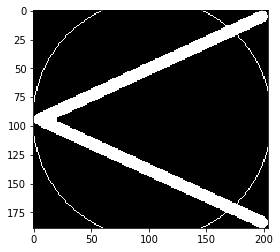

2
182 185
13 192


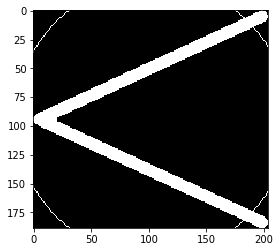

2


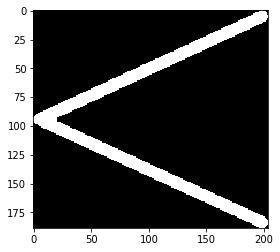

94 208
83 168


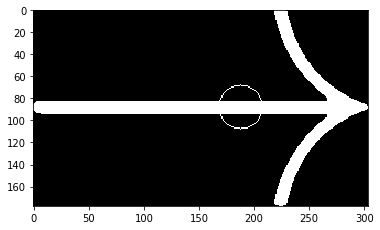

2
94 229
83 147


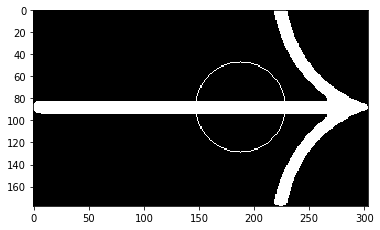

2
127 238
94 250
55 242
83 126


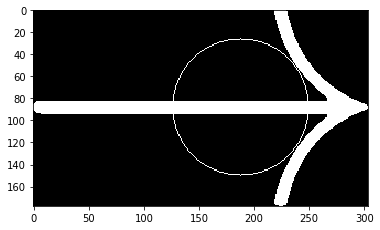

4
165 221
108 269
19 235
83 105


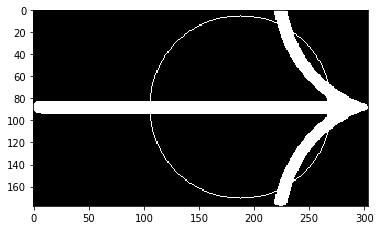

4
94 292
83 84


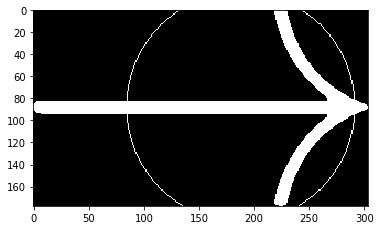

2
83 63


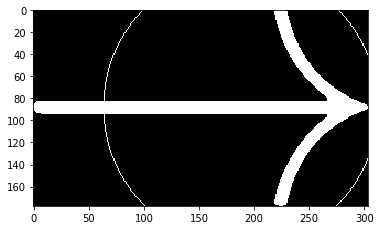

1
83 42


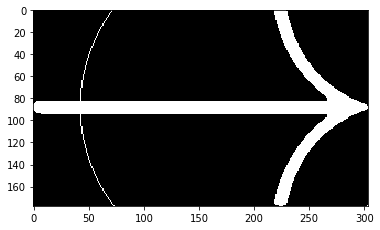

1
83 21


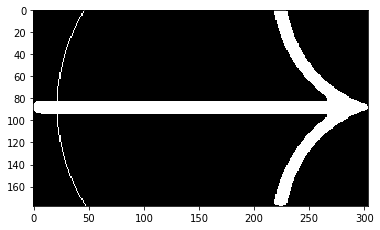

1


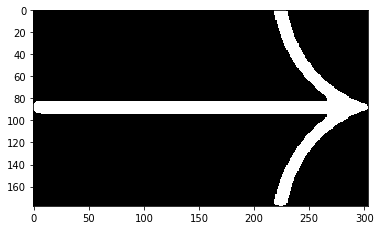

82 63
72 70
75 54


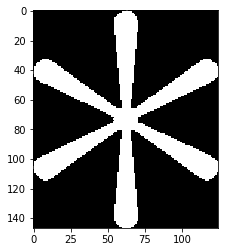

3
90 63
84 74
68 78
58 66
62 51
79 47
89 59


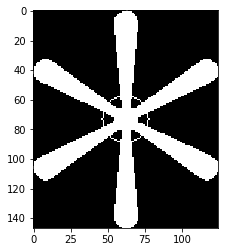

7
98 63
89 81
65 85
49 66
57 44
82 39
98 58


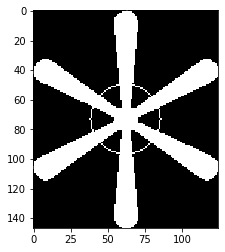

7
106 63
94 87
61 93
41 67
52 37
86 32
106 58


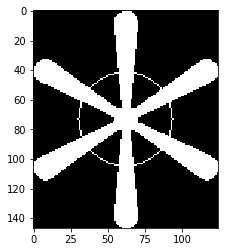

7
114 63
99 94
57 100
33 68
48 31
89 25
114 57


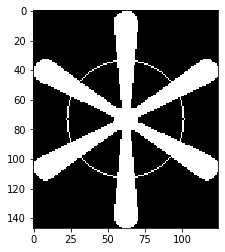

7
122 63
104 101
54 107
25 69
43 25
93 17
122 56


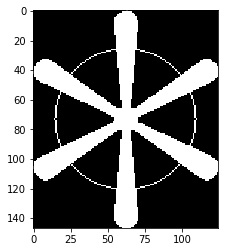

7
131 63
109 108
50 115
17 69
38 18
97 10
130 56


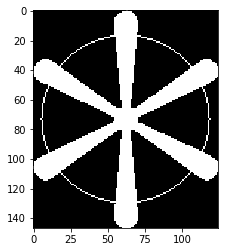

7
139 63
113 114
46 122
9 70
34 11
100 3
138 55


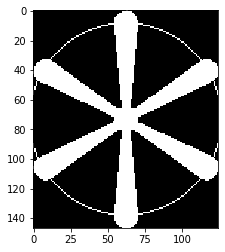

7


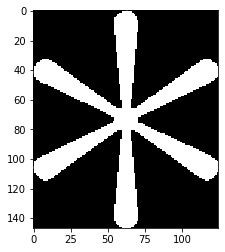

94 151
66 164
88 139


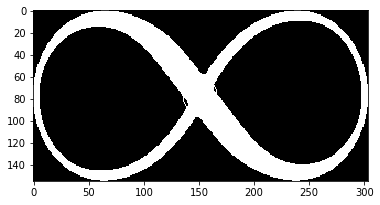

3
109 161
51 173
45 142
103 130


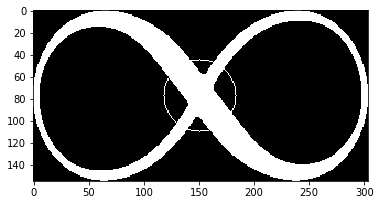

4
123 173
38 184
31 130
116 119


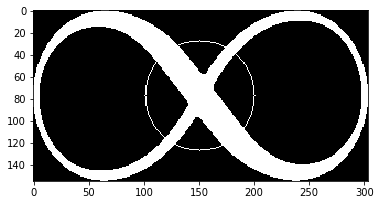

4
135 187
26 196
19 117
128 107


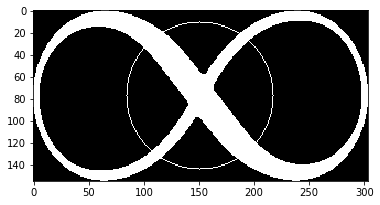

4
144 202
17 210
9 101
137 93


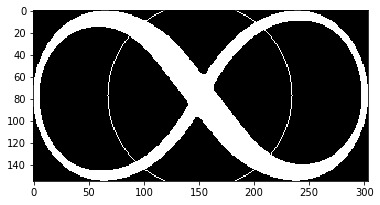

4
151 220
10 228
3 83
144 75


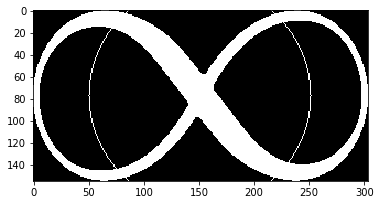

4
154 241
9 248
145 55


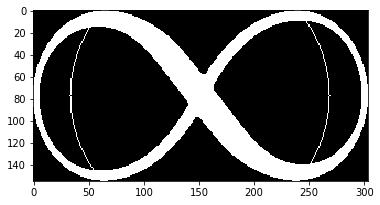

3
146 267
20 274
8 36
133 28


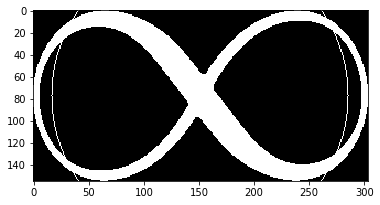

4


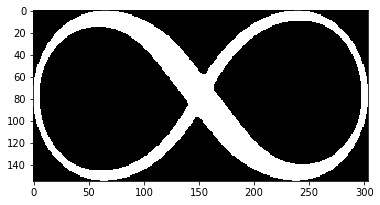

11 113


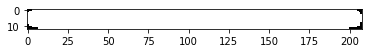

1
11 126


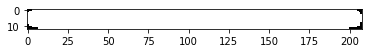

1
11 137


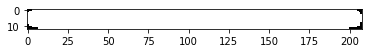

1
11 149


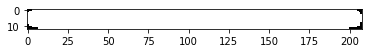

1
11 161


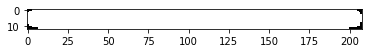

1
11 172


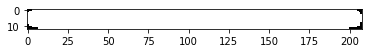

1
11 184


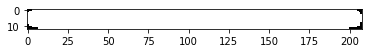

1
11 195


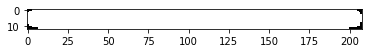

1


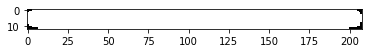

191 60
151 62
176 41


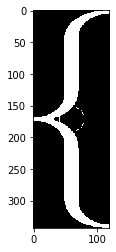

3
211 60
132 69
166 21
209 49


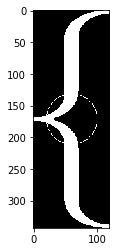

4
231 60
112 70
170 0
230 49


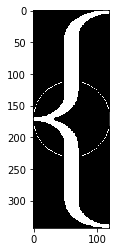

4
251 60
92 70
250 49


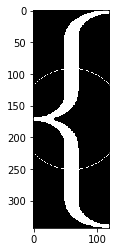

3
271 60
71 70
270 49


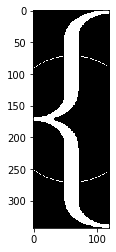

3
291 60
51 70
291 49


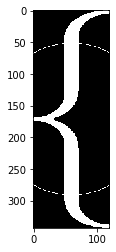

3
311 60
31 72
311 52


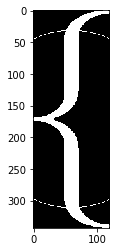

3
331 70
13 88


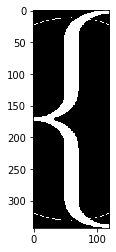

2


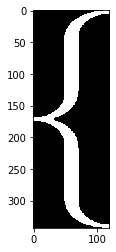

191 59
166 78
191 58


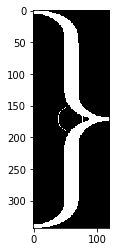

3
212 59
177 98
133 70
210 50


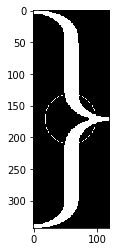

4
232 59
172 119
113 70
231 49


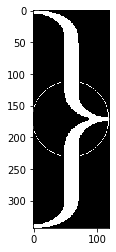

4
252 59
92 70
251 49


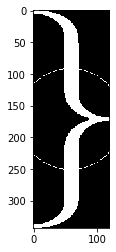

3
272 59
72 70
271 49


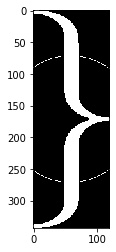

3
292 59
52 70
291 49


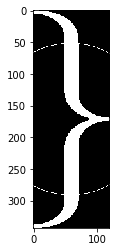

3
312 59
32 67
311 47


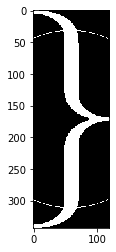

3
11 49
329 31


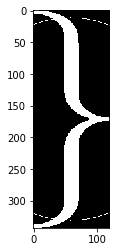

2


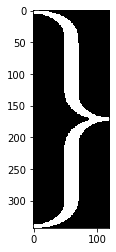

152 13


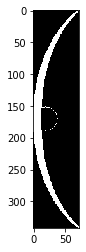

1
132 14
206 2


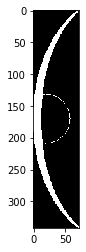

2
111 17
229 6


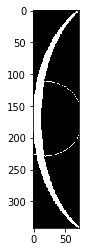

2
250 20
92 21
250 11


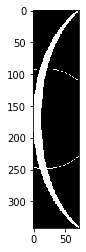

3
270 20
72 27
270 18


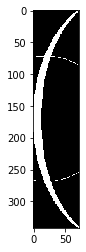

3
290 28
53 35


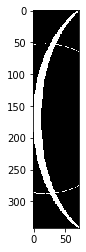

2
308 39
34 45


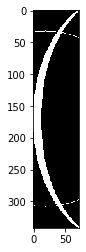

2
326 53
17 57


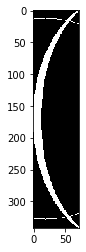

2


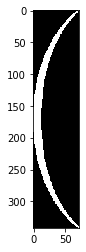

188 59


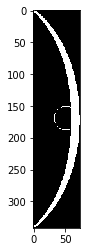

1
209 57
134 69


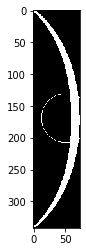

2
229 55
112 66


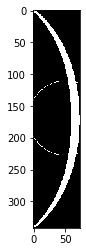

2
249 52
90 60
249 50


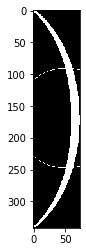

3
269 52
70 53
269 44


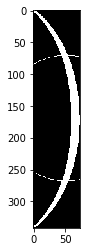

3
50 44
288 37


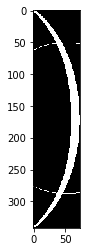

2
32 32
306 27


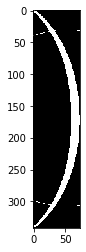

2
14 18
324 15


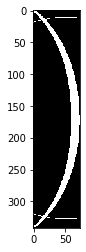

2


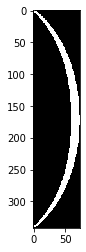

191 8
152 10


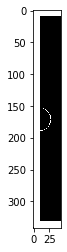

2
210 8
133 10


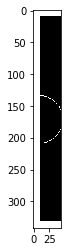

2
230 8
113 10


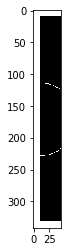

2
249 8
94 10


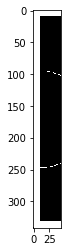

2
269 8
74 10


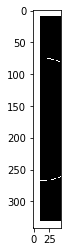

2
288 8
55 10


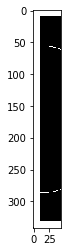

2
308 8
36 10


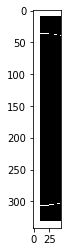

2
327 8
16 10


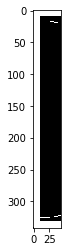

2


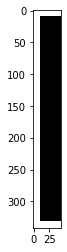

180 111
148 128
177 101


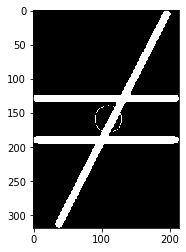

3
195 130
133 141
124 93
185 79


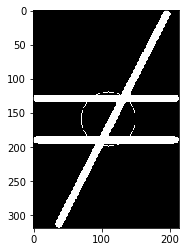

4
195 160
133 165
111 147
124 63
185 56
213 83


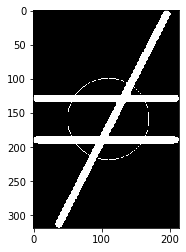

6
195 183
133 187
93 156
124 39
185 34
231 74


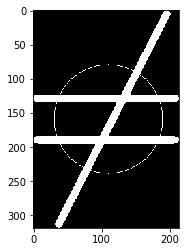

6
195 205
133 208
75 165
124 17
185 13
249 64


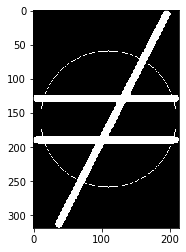

6
57 175
267 55


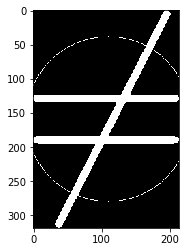

2
39 184
285 46


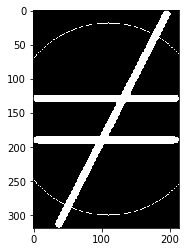

2
21 193
303 37


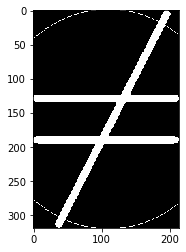

2


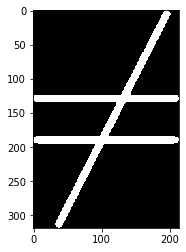

44 118
20 108


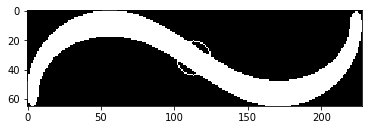

2
51 130
13 96


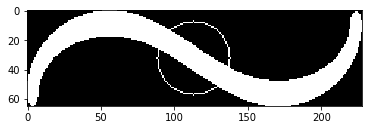

2
58 143
7 84


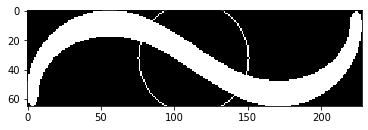

2
62 155
2 71


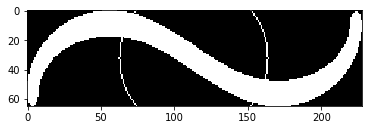

2
64 169
0 57


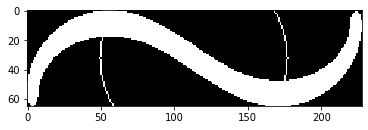

2
63 184
2 42


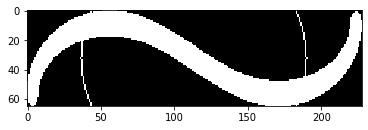

2
56 201
9 25


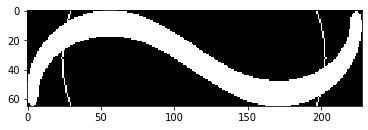

2
42 216
23 10


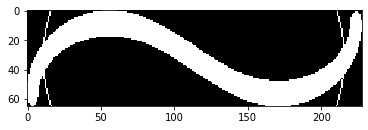

2


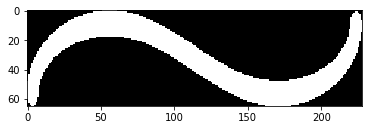

43 118
20 109


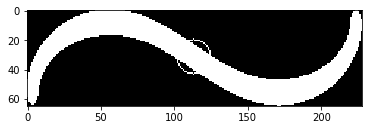

2
51 131
12 96


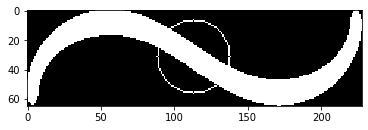

2
57 142
6 84


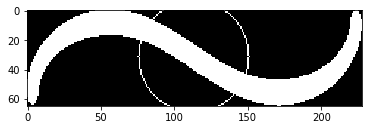

2
62 156
2 71


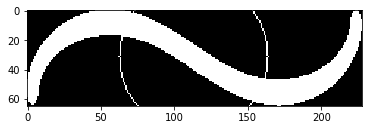

2
64 170
0 57


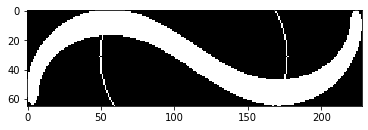

2
62 185
1 42


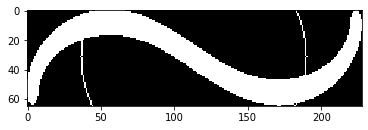

2
56 200
8 26


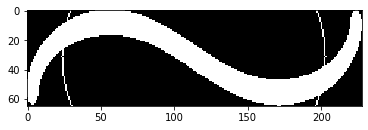

2
41 216
23 10


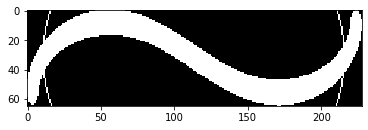

2


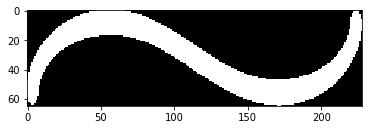

101 76


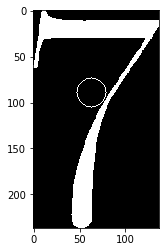

1
122 65
79 95


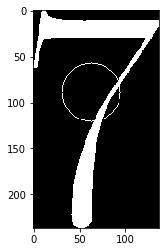

2
139 64
63 105
138 59


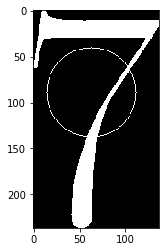

3
155 64
49 115
29 90
154 53


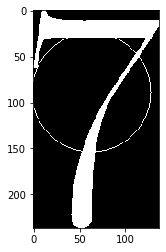

4
171 64
34 124
11 43
34 4
170 48


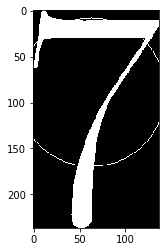

5
188 64
21 134
4 15
186 45


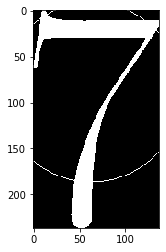

4
202 43


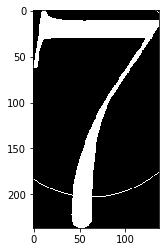

1
218 42


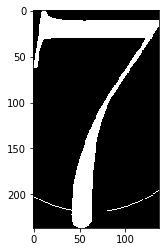

1


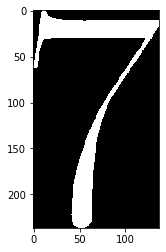

146 90


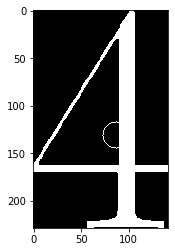

1
161 90
109 106


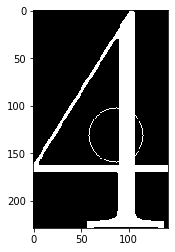

2
176 89
169 111
92 106
163 56


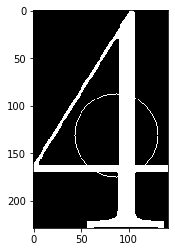

4
191 89
169 133
76 106
85 52
95 42
106 35
163 38


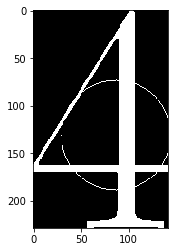

7
205 89
60 106
61 67
140 14
163 21


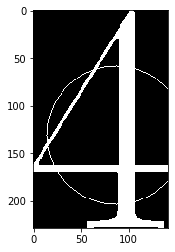

5
220 88
45 106
44 77
157 3
220 80


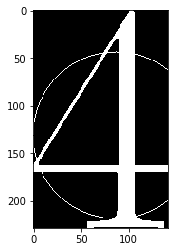

5
227 126
30 106


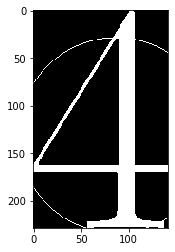

2
15 106


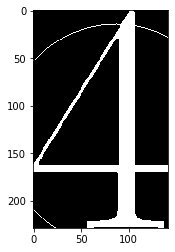

1


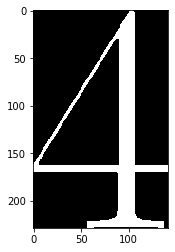

144 109
91 19


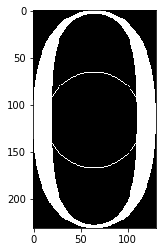

2
165 108
68 108
69 20


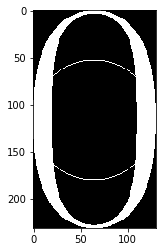

3
183 105
69 126
50 106
51 22
163 3


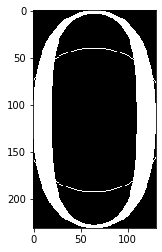

5
200 100
188 119
45 120
34 26
45 9
188 10


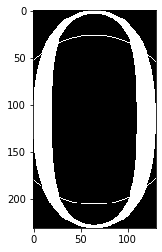

6
217 90
22 108
17 35
210 22
217 39


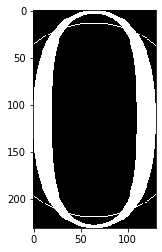

5


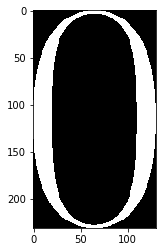

136 49
114 59
134 42


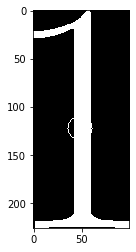

3
150 49
97 59
149 42


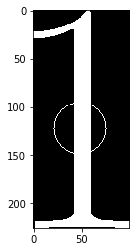

3
163 49
83 59
163 42


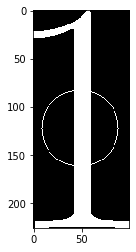

3
177 49
69 59
177 42


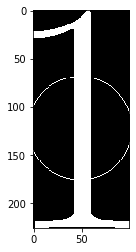

3
191 49
55 59
190 42


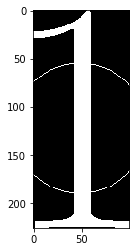

3
204 49
41 59
204 42


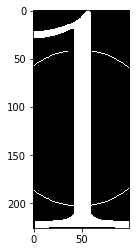

3
218 49
28 59
217 32


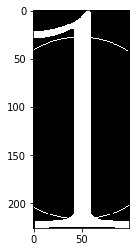

3
225 85
14 59
22 7
221 2


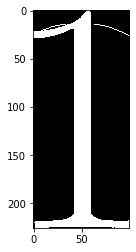

4


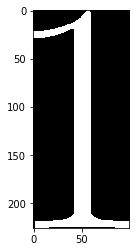

136 74


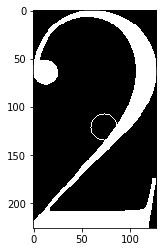

1
119 102
148 63


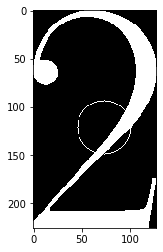

2
106 112
159 53


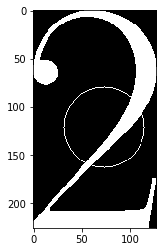

2
91 120
170 44


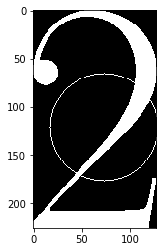

2
75 126
72 23
180 35


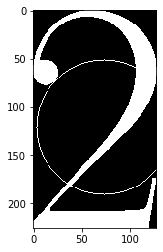

3
193 120
56 126
55 21
191 25


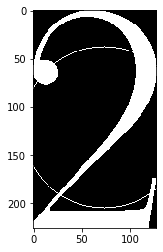

4
220 74
36 121
25 94
50 6
202 16


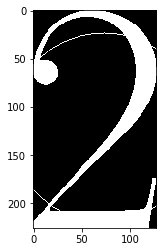

5
225 118
13 102
23 19
30 9
212 6


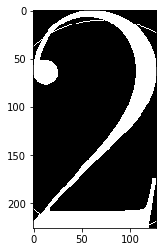

5


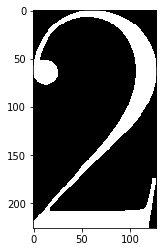

121 95
106 75


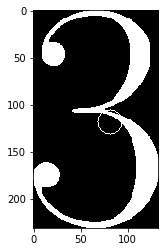

2
134 103
95 95
104 59


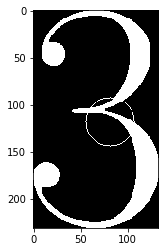

3
149 108
86 106
105 44


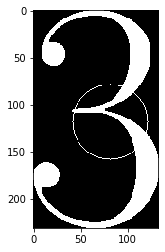

3
165 109
76 114


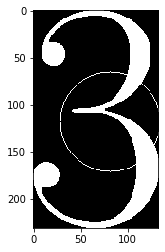

2
180 108
63 120


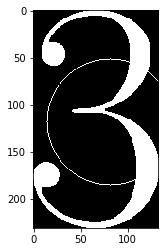

2
196 104
49 123
161 13


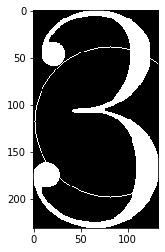

3
211 96
34 122
39 31
168 2


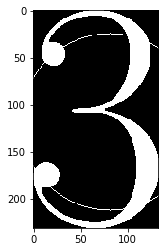

4
226 82
14 108
33 16
191 3
203 15
225 66


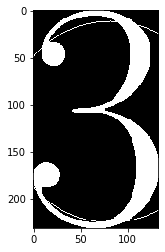

6


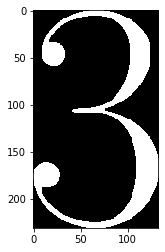

100 96
83 76
104 21


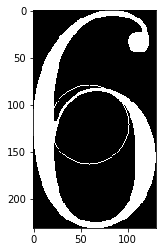

3
150 108
79 22


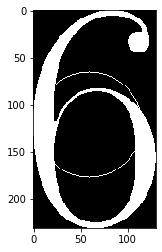

2
173 108
60 26
164 4
183 25


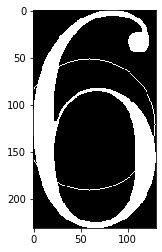

4
193 105
170 128
42 32
52 13
191 12


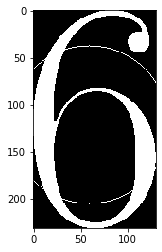

5
215 91
201 116
43 117
25 43
214 27


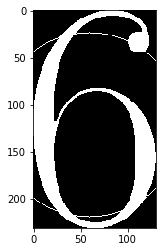

5
29 122
10 62


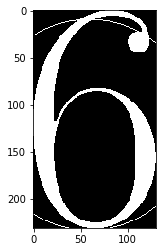

2


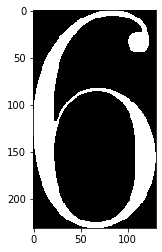

125 76
113 54


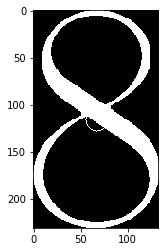

2
132 87
98 86
91 62
116 41


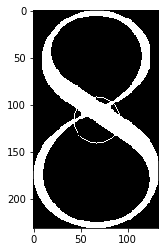

4
140 98
91 97
82 49
124 29


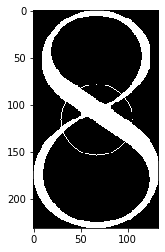

4
147 109
83 107
74 37
134 18


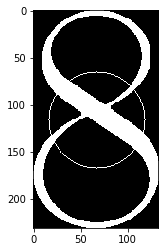

4
158 117
73 116
66 27
145 9


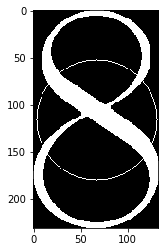

4
172 122
61 122
54 20
160 3


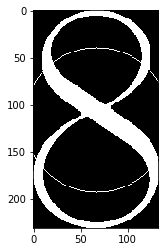

4
190 121
45 123
40 18
177 0


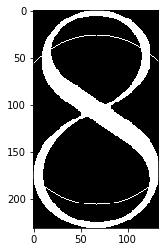

4
214 103
205 120
26 117
18 101
20 28
26 17
201 8
214 31


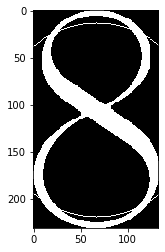

8


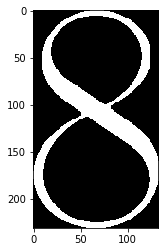

127 108
130 33


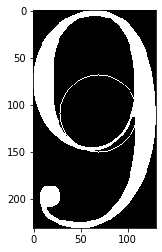

2
151 107
81 21
125 17


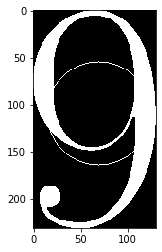

3
170 104
68 125
59 21


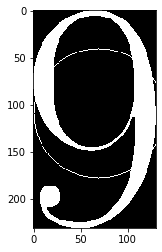

3
188 98
177 117
41 118
39 24


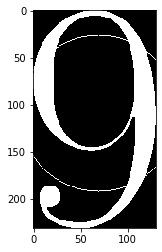

4
205 88
19 105
13 88
18 35
31 12
187 12


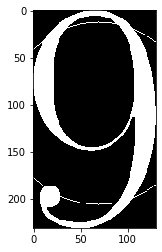

6
220 70
201 7
220 70


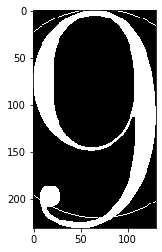

3


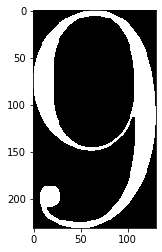

104 96
87 62


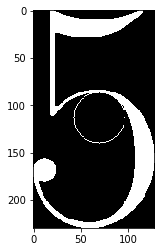

2
135 106
105 110
95 33


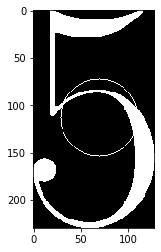

3
155 107
85 22


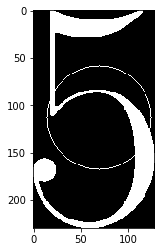

2
173 106
63 22
157 15


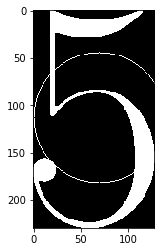

3
190 102
45 22
161 2


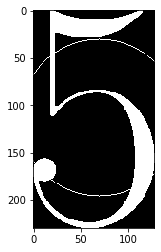

3
208 92
200 113
19 92
29 22
183 2


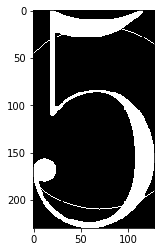

5
225 70
223 85
9 106
7 41
210 16
220 37
224 54


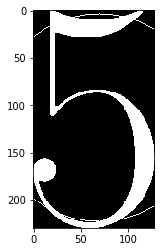

7


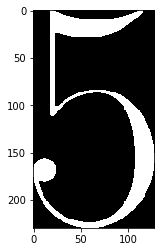

In [104]:
id_profs_list = []
imgs_list = []
for i in range(0,len(imgs)):
    prof = create_identifier(imgs[i],centroids_new[i])
    id_profs_list.append(prof)
    imgs_list.append(imgs[i])
    plt.imshow(imgs[i],cmap='gray')
    plt.show()

In [197]:
def find_nn(img,centroid):
#     fe_vector = create_identifier(cv2.GaussianBlur(img.astype(np.uint8),(5,5),3),centroid)
    fe_vector = create_identifier(img,centroid)
    mind = -1
    mival = 1000 
    for i in range(0,len(imgs_list)):
        val = np.sum(np.abs(np.array(fe_vector)-np.array(id_profs_list[i])))
        if val < mival:
            mival = val
            mind = i
    plt.imshow(imgs_list[mind])
    plt.show()
    print(id_profs_list[mind])
    print(fe_vector)

106 173
75 189
98 158


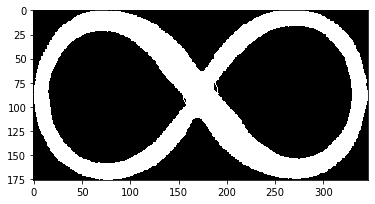

3
124 182
60 200
50 163
113 145


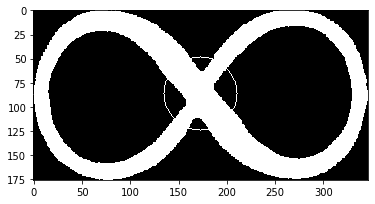

4
140 195
45 213
34 149
129 133


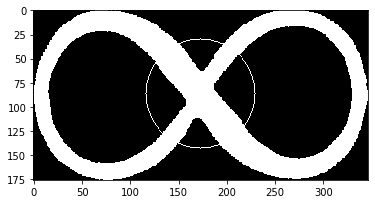

4
154 211
32 227
21 134
141 119


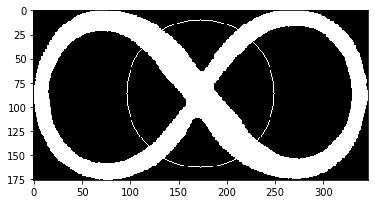

4
165 229
21 244
9 116
152 102


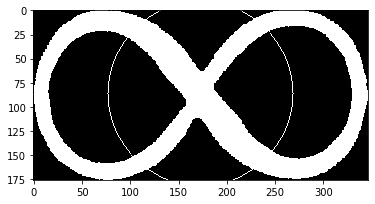

4
172 251
16 265
3 94
22 77
158 82


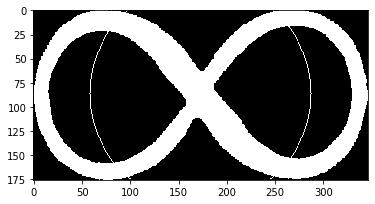

5
174 276
18 289
155 57


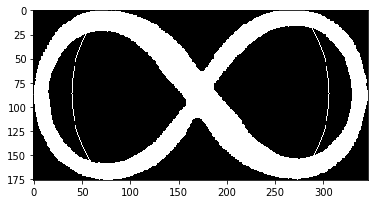

3
166 305
116 325
58 325
7 42
122 23


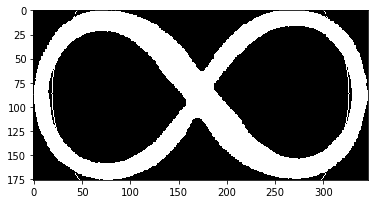

5


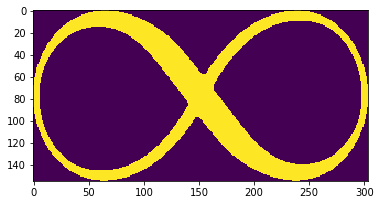

[ 8.10064467e-01  3.00000000e+00  4.00000000e+00  4.00000000e+00
  4.00000000e+00  4.00000000e+00  4.00000000e+00  3.00000000e+00
  4.00000000e+00  4.98193943e-01  3.44262295e-01  3.19533204e-01
  3.00639066e-01  2.76187830e-01  2.54515143e-01  4.99861073e-01
  1.40910038e-01  3.05451998e-05  5.55355522e-02  1.27918944e-08
  2.78571271e-05 -1.03954726e-09]
[ 6.51970584e-01  3.00000000e+00  4.00000000e+00  4.00000000e+00
  4.00000000e+00  4.00000000e+00  5.00000000e+00  3.00000000e+00
  5.00000000e+00  4.95971103e-01  3.39816616e-01  3.16476799e-01
  2.95081967e-01  2.70908586e-01  2.65073632e-01  4.99027508e-01
  1.20446627e-01  4.23389706e-05  2.45739765e-02 -3.37520096e-09
 -7.20660115e-06  2.06354047e-09]
152 84


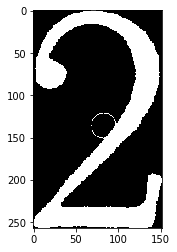

1
168 83
165 96
147 113
166 71


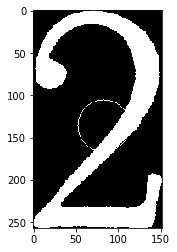

4
125 130
178 59


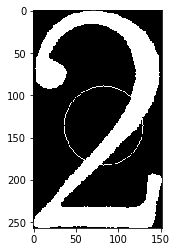

2
108 141
190 49


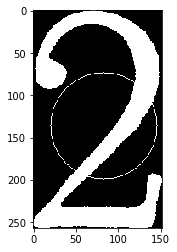

2
197 136
87 146
70 38
202 38


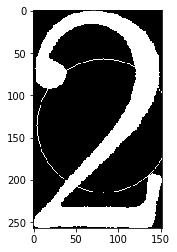

4
232 83
218 133
66 148
45 114
60 26
215 28
231 69


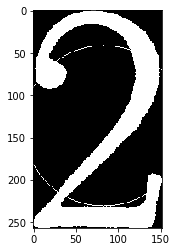

7
248 83
229 145
42 143
40 26
59 3
227 18


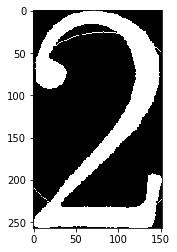

6
256 127
13 116
239 7


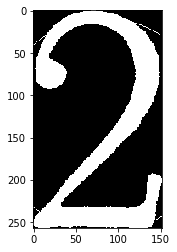

3


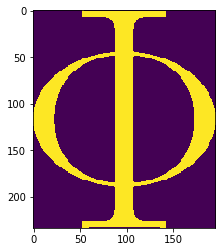

[ 6.02912713e-01  3.00000000e+00  3.00000000e+00  3.00000000e+00
  3.00000000e+00  4.00000000e+00  7.00000000e+00  7.00000000e+00
  3.00000000e+00  4.92914699e-01  4.97360378e-01  4.98193943e-01
  4.98749653e-01  4.57349264e-01  2.38399555e-01  2.44234510e-01
  9.46856178e-03  7.66321842e-06  1.24682648e-01 -1.02629966e-09
  7.26890350e-07  2.00915707e-10]
[ 7.71492175e-01  1.00000000e+00  4.00000000e+00  2.00000000e+00
  2.00000000e+00  4.00000000e+00  7.00000000e+00  6.00000000e+00
  3.00000000e+00  0.00000000e+00  2.57571548e-01  3.71214226e-01
  4.12892470e-01  3.08696860e-01  2.99527647e-01  3.16198944e-01
  2.11292454e-01  7.76167569e-03  3.60094052e-01 -4.79350345e-06
 -1.05967742e-03 -3.27025141e-06]
286 131
236 153
277 109


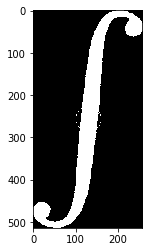

3
317 131
201 155
312 107


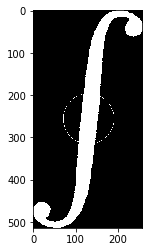

3
347 131
169 158
343 104


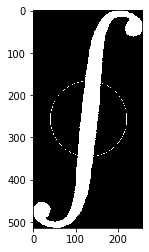

3
377 131
138 160
374 102


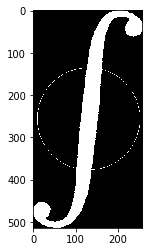

3
408 131
108 163
405 101


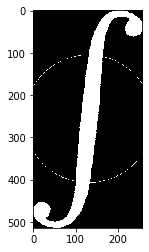

3
78 166
435 97


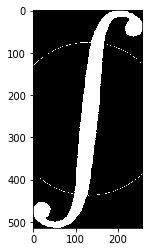

2
48 173
464 90


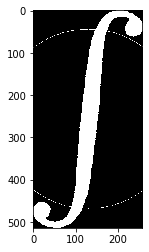

2
49 256
21 189
462 2
491 73


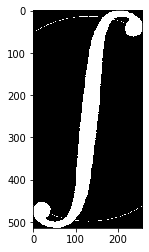

4


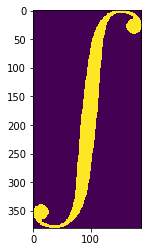

[1.43200420e+00 3.00000000e+00 3.00000000e+00 3.00000000e+00
 3.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 4.00000000e+00 4.88191164e-01 4.95137538e-01 4.97082523e-01
 4.97638233e-01 4.98193943e-01 4.99861073e-01 4.99861073e-01
 1.83741987e+00 1.53853493e-04 1.70631980e+00 1.89242202e-07
 9.92582070e-04 8.17450562e-08]
[ 1.29160106e+00  3.00000000e+00  3.00000000e+00  3.00000000e+00
  3.00000000e+00  3.00000000e+00  2.00000000e+00  2.00000000e+00
  4.00000000e+00  4.96804668e-01  4.98749653e-01  4.99305363e-01
  4.99305363e-01  4.97360378e-01  4.98749653e-01  4.99027508e-01
  1.49947955e+00  3.72122913e-05  1.37354957e+00  3.23699814e-10
  2.54554026e-04 -1.86178269e-08]
167 121
167 88


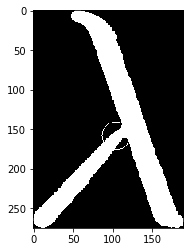

2
188 127
181 74


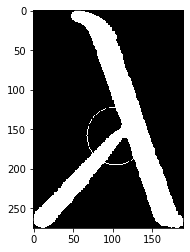

2
206 133
109 129
194 61


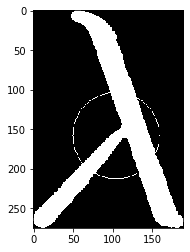

3
224 140
87 122
208 48


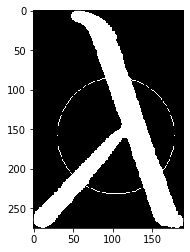

3
242 146
67 114
221 36


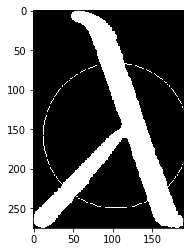

3
260 151
48 108
235 23


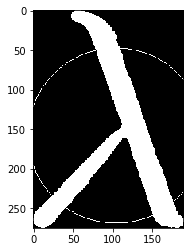

3
272 167
29 102
248 10


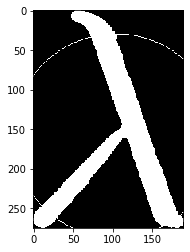

3
11 87
264 0


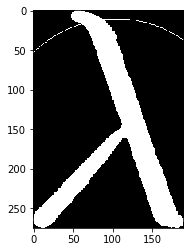

2


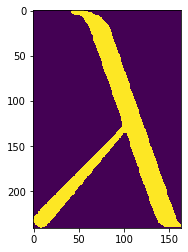

[ 8.73383615e-01  2.00000000e+00  3.00000000e+00  3.00000000e+00
  3.00000000e+00  3.00000000e+00  3.00000000e+00  3.00000000e+00
  2.00000000e+00  3.08141150e-01  4.69297027e-01  4.27896638e-01
  3.97610447e-01  4.17893859e-01  4.31230897e-01  4.33175882e-01
  2.26344553e-01  4.23524234e-01  4.02738303e-01 -1.46219042e-03
 -4.99385245e-03  5.23147180e-04]
[ 6.88184227e-01  2.00000000e+00  2.00000000e+00  3.00000000e+00
  3.00000000e+00  3.00000000e+00  3.00000000e+00  3.00000000e+00
  2.00000000e+00  3.49263684e-01  2.54792998e-01  4.32898027e-01
  4.03723256e-01  4.08168936e-01  4.25118088e-01  4.21505974e-01
  1.34595115e-01  2.13779323e-01  2.55366447e-01 -3.81109852e-04
 -9.95165072e-04 -6.13069903e-05]
172 112


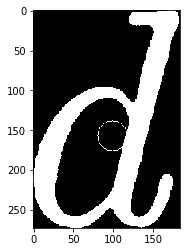

1
195 107
120 113


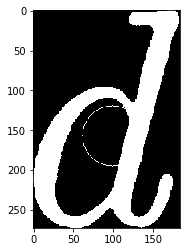

2
215 102
128 150
99 108


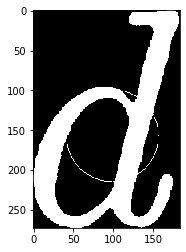

3
235 99
103 155
136 25
235 92


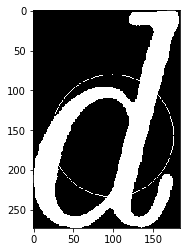

4
254 102
239 152
82 162
181 5
251 72


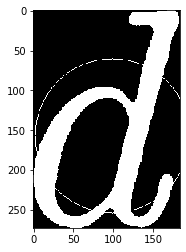

5
270 127
258 157
63 168
219 1


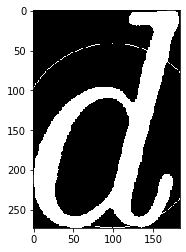

4
42 172


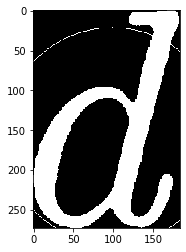

1
23 179


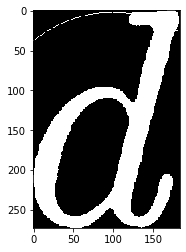

1


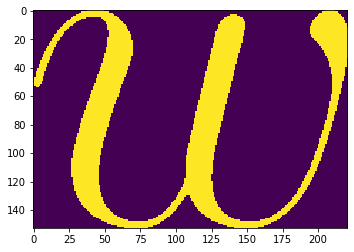

[7.49135227e-01 1.00000000e+00 2.00000000e+00 3.00000000e+00
 4.00000000e+00 5.00000000e+00 4.00000000e+00 3.00000000e+00
 1.00000000e+00 0.00000000e+00 2.84523479e-01 3.58432898e-01
 3.77882745e-01 3.74826341e-01 4.64851348e-01 4.30119478e-01
 6.21152237e-02 6.41699013e-02 1.51918353e-01 1.10167724e-03
 5.08830176e-03 2.99369493e-04]
[5.91332106e-01 1.00000000e+00 2.00000000e+00 3.00000000e+00
 4.00000000e+00 5.00000000e+00 4.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 4.15115310e-01 4.69574882e-01
 3.72325646e-01 3.99833287e-01 4.39566546e-01 0.00000000e+00
 1.06834920e-01 7.29486260e-02 1.42917986e-01 3.20701906e-04
 3.18040920e-03 6.69654183e-04]
104 78
117 45


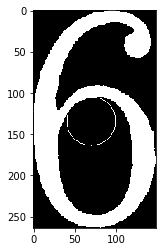

2
140 117
94 93
118 28


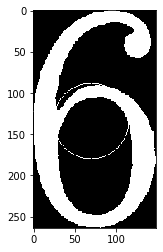

3
172 120
119 130
88 30


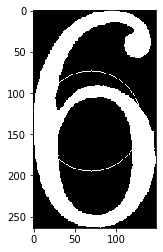

3
194 119
65 37
96 4
170 3


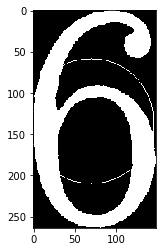

4
215 115
56 120
45 46
61 15
201 8


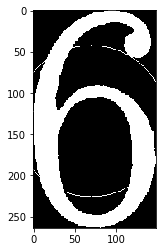

5
238 101
216 140
51 138
27 62
228 19


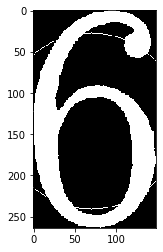

5
257 71
249 114
34 142
21 120
14 98
254 42


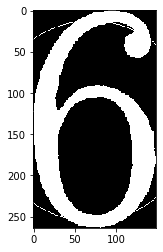

6


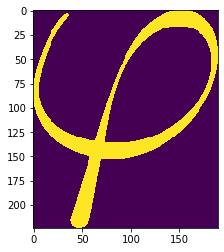

[ 1.02992044e+00  1.00000000e+00  2.00000000e+00  3.00000000e+00
  4.00000000e+00  4.00000000e+00  5.00000000e+00  5.00000000e+00
  5.00000000e+00  0.00000000e+00  3.24534593e-01  4.93748263e-01
  3.46485135e-01  3.19533204e-01  3.48707974e-01  3.77604890e-01
  2.59328144e-01  1.54881294e-01  4.70663185e-01 -2.71741298e-04
  2.80981474e-02 -5.69770862e-03]
[ 5.69891463e-01  0.00000000e+00  2.00000000e+00  3.00000000e+00
  3.00000000e+00  4.00000000e+00  5.00000000e+00  5.00000000e+00
  6.00000000e+00  0.00000000e+00  1.93942762e-01  4.62072798e-01
  4.68463462e-01  4.64851348e-01  3.31203112e-01  4.07057516e-01
  5.93711439e-02  8.67431502e-03  1.74221865e-01 -5.85684668e-06
 -3.78591114e-04 -1.08209918e-06]
136 102


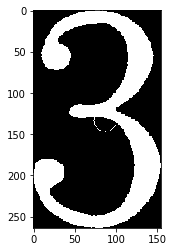

1
150 112
112 109
115 64


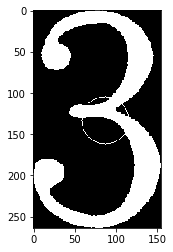

3
166 119
103 120
119 45


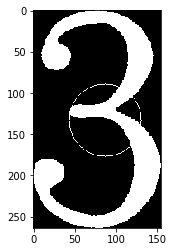

3
183 122
92 130


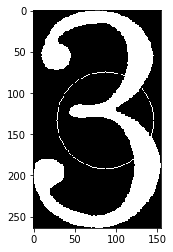

2
200 122
79 138
187 35


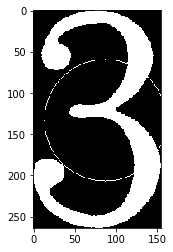

3
218 118
64 144
54 45
180 11


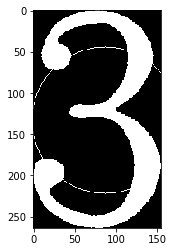

4
236 106
44 142
42 37
193 1


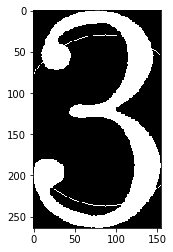

4
253 87
247 123
22 131
220 5


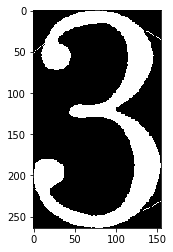

4


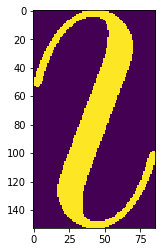

[ 6.64481919e-01  1.00000000e+00  3.00000000e+00  3.00000000e+00
  2.00000000e+00  2.00000000e+00  4.00000000e+00  4.00000000e+00
  4.00000000e+00  0.00000000e+00  4.99583218e-01  4.92081134e-01
  4.95693248e-01  4.98193943e-01  3.02028341e-01  3.55654348e-01
  2.44586165e-01  1.48025143e-03  3.38269218e-01  7.67941152e-07
  2.84658998e-04 -4.82504554e-07]
[ 6.99247254e-01  1.00000000e+00  3.00000000e+00  3.00000000e+00
  2.00000000e+00  3.00000000e+00  4.00000000e+00  4.00000000e+00
  4.00000000e+00  0.00000000e+00  4.88469019e-01  4.25395943e-01
  2.75909975e-01  4.95137538e-01  3.36204501e-01  3.84273409e-01
  1.45205126e-01  9.80751746e-03  2.65141315e-01 -4.43392051e-06
 -1.30934211e-03  1.30524865e-05]
136 123
114 134
112 114
134 116


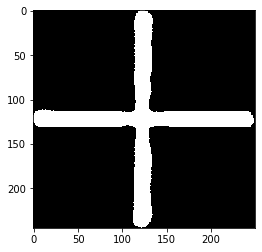

4
150 123
129 150
95 132
114 97
148 115


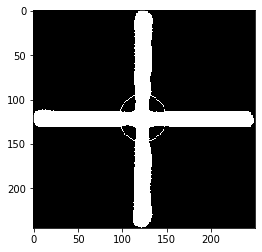

5
164 123
130 164
81 132
114 82
163 114


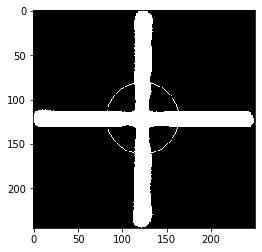

5
178 123
130 178
67 133
113 68
177 114


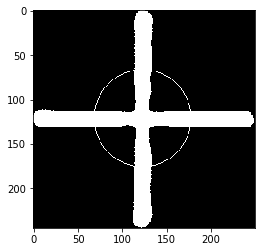

5
192 123
130 193
53 133
113 54
191 114


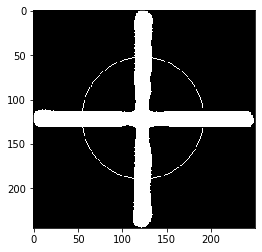

5
206 123
131 207
39 132
113 40
205 114


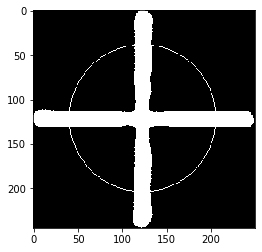

5
220 123
131 221
25 133
25 114
113 26
219 114


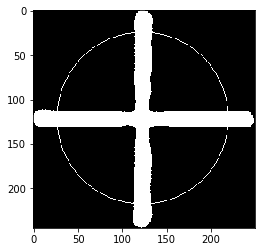

6
234 123
131 235
11 134
112 12
233 113


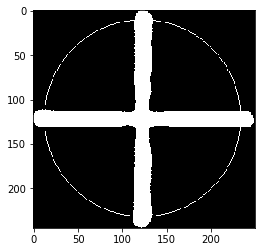

5


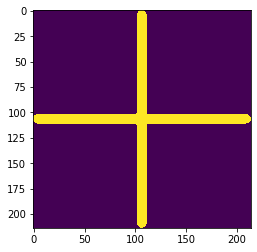

[ 9.25945730e-01  5.00000000e+00  5.00000000e+00  5.00000000e+00
  5.00000000e+00  5.00000000e+00  5.00000000e+00  5.00000000e+00
  5.00000000e+00  2.52292303e-01  2.51180884e-01  2.50625174e-01
  2.50625174e-01  2.50347319e-01  2.50347319e-01  2.50347319e-01
  2.72282909e-08  1.42567593e-05  2.21623830e-01 -2.57995039e-08
  3.83158643e-08  8.96702265e-09]
[ 6.31678937e-01  4.00000000e+00  5.00000000e+00  5.00000000e+00
  5.00000000e+00  5.00000000e+00  5.00000000e+00  6.00000000e+00
  5.00000000e+00  3.50930814e-01  2.55626563e-01  2.53681578e-01
  2.52570158e-01  2.52014448e-01  2.50903029e-01  2.49235899e-01
  1.64346655e-06  4.70439682e-06  1.02631279e-01 -2.64566190e-08
 -2.18290618e-07 -5.65318798e-09]
102 94
94 106
85 82


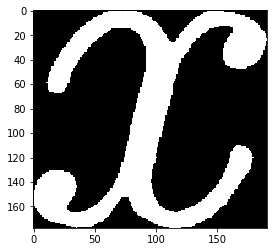

3
115 94
69 112
108 77


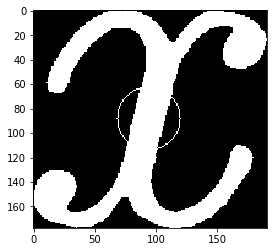

3
128 94
55 116
122 74


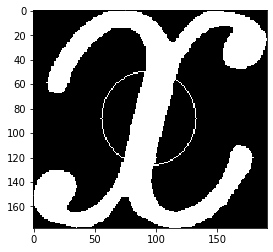

3
141 94
42 120
134 69


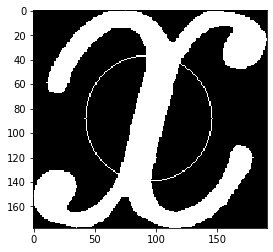

3
154 94
31 126
25 112
146 63


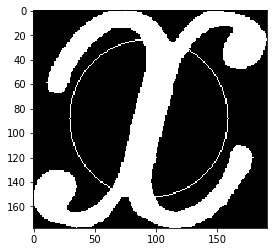

4
167 94
164 118
154 138
46 161
21 135
10 100
16 62
132 28
156 55
167 86


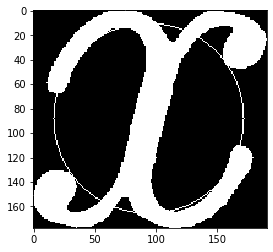

10
177 117
153 160
132 175
45 176
13 148
1 67
131 13
164 41


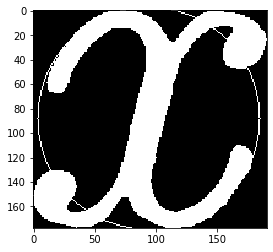

8
36 186
139 3


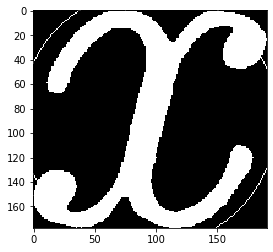

2


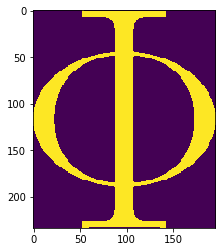

[ 6.02912713e-01  3.00000000e+00  3.00000000e+00  3.00000000e+00
  3.00000000e+00  4.00000000e+00  7.00000000e+00  7.00000000e+00
  3.00000000e+00  4.92914699e-01  4.97360378e-01  4.98193943e-01
  4.98749653e-01  4.57349264e-01  2.38399555e-01  2.44234510e-01
  9.46856178e-03  7.66321842e-06  1.24682648e-01 -1.02629966e-09
  7.26890350e-07  2.00915707e-10]
[ 5.40288376e-01  3.00000000e+00  3.00000000e+00  3.00000000e+00
  3.00000000e+00  4.00000000e+00  1.00000000e+01  8.00000000e+00
  2.00000000e+00  4.70686302e-01  4.99027508e-01  4.95971103e-01
  4.99027508e-01  4.63462073e-01  2.75632120e-01  2.77854960e-01
  2.75924142e-02  1.78227885e-05  1.03892949e-01 -4.14258404e-09
 -5.60006790e-06 -8.91641528e-10]
96 63


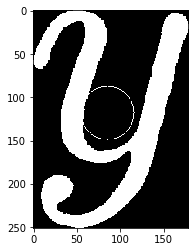

1
166 86
73 70


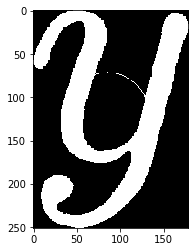

2
176 111
142 144
129 148
56 76


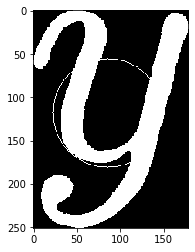

4
196 102
180 134
88 158
39 83


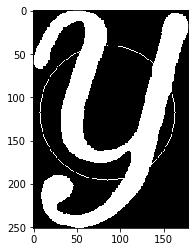

4
213 90
205 123
64 163
24 84
51 19
190 23


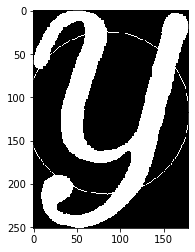

6
229 86
46 169
8 75
18 38
44 4
201 12
228 74


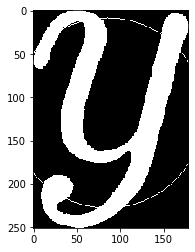

7
29 175
1 40
219 10
233 31


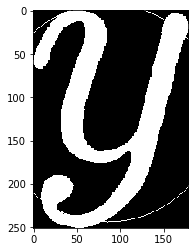

4


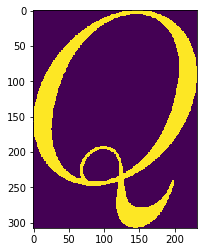

[9.04825438e-01 0.00000000e+00 0.00000000e+00 3.00000000e+00
 4.00000000e+00 4.00000000e+00 5.00000000e+00 6.00000000e+00
 5.00000000e+00 0.00000000e+00 0.00000000e+00 1.06696305e-01
 3.61489303e-01 3.16754654e-01 3.37871631e-01 3.70936371e-01
 1.01921206e-02 1.03020263e-01 2.16063840e-01 6.18654144e-05
 3.17580335e-04 2.56526822e-04]
[ 5.26164853e-01  0.00000000e+00  1.00000000e+00  2.00000000e+00
  4.00000000e+00  4.00000000e+00  6.00000000e+00  7.00000000e+00
  4.00000000e+00  0.00000000e+00  0.00000000e+00  4.48180050e-01
  4.58738538e-01  4.72075577e-01  2.82022784e-01  3.63156432e-01
  5.02492492e-02  2.00213914e-02  1.45080308e-01 -2.39226278e-07
 -1.66432125e-05  1.27253608e-06]
101 95
92 107


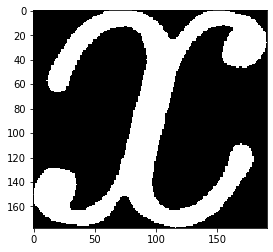

2
114 95
69 112
107 77


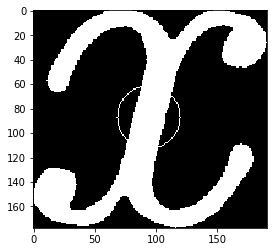

3
127 95
55 115
121 73


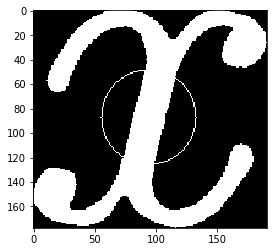

3
140 95
42 120
134 70


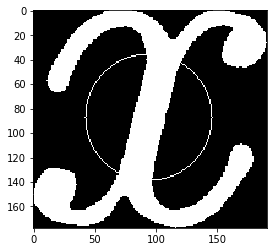

3
153 95
31 126
145 63


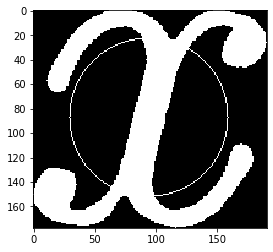

3
166 95
162 120
155 136
44 160
20 135
10 101
14 67
22 51
131 29
155 55
166 87


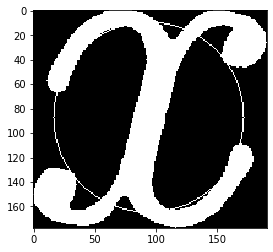

11
177 116
153 158
143 167
131 175
45 175
13 148
0 71
27 27
36 20
129 13
163 42


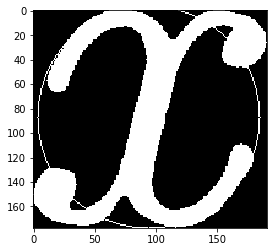

11
36 186
139 3


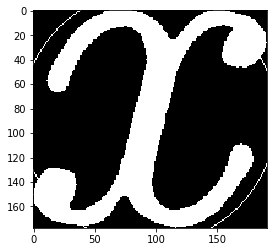

2


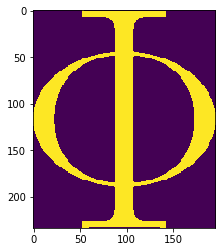

[ 6.02912713e-01  3.00000000e+00  3.00000000e+00  3.00000000e+00
  3.00000000e+00  4.00000000e+00  7.00000000e+00  7.00000000e+00
  3.00000000e+00  4.92914699e-01  4.97360378e-01  4.98193943e-01
  4.98749653e-01  4.57349264e-01  2.38399555e-01  2.44234510e-01
  9.46856178e-03  7.66321842e-06  1.24682648e-01 -1.02629966e-09
  7.26890350e-07  2.00915707e-10]
[ 5.33835163e-01  2.00000000e+00  3.00000000e+00  3.00000000e+00
  3.00000000e+00  3.00000000e+00  1.10000000e+01  1.10000000e+01
  2.00000000e+00  1.91997777e-01  4.97082523e-01  4.95971103e-01
  4.97638233e-01  4.99305363e-01  2.56182273e-01  1.70325090e-01
  2.60826455e-02  2.08685929e-05  1.01475744e-01 -1.31736794e-08
 -1.12315358e-05 -3.94776316e-09]
20 131
1 112


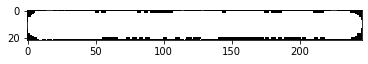

2
19 148
2 96


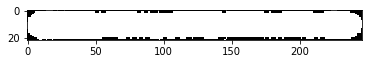

2
19 162
2 82


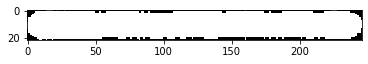

2
19 176
1 68


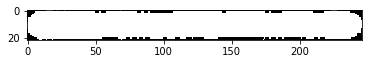

2
19 190
2 54


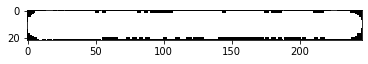

2
19 203
1 40


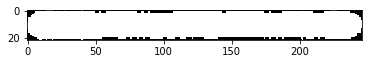

2
19 217
1 26


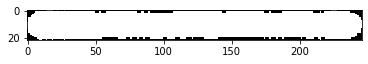

2
20 231
1 13


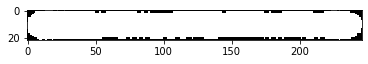

2


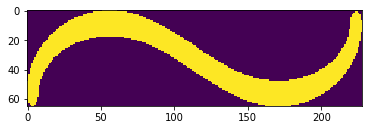

[1.19932466e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 4.98749653e-01 4.95693248e-01 4.98471798e-01
 4.98471798e-01 4.98749653e-01 4.98749653e-01 4.99027508e-01
 1.16537617e+00 3.64734339e-04 7.75155414e-03 3.97398716e-08
 1.34140954e-04 1.43537886e-08]
[1.06529242e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 4.95415393e-01 4.98471798e-01 4.99027508e-01
 4.97916088e-01 4.99583218e-01 4.98749653e-01 4.98749653e-01
 1.10706997e+00 2.79338624e-03 3.15773972e-03 1.74892353e-05
 2.49435050e-03 1.82252734e-07]
18 133
0 113


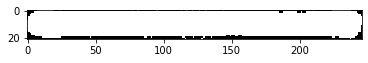

2
17 148
1 97


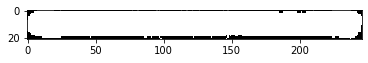

2
18 162
1 82


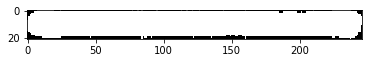

2
18 176
1 69


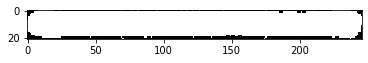

2
18 190
1 55


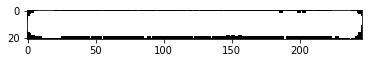

2
18 204
1 41


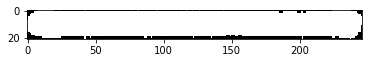

2
18 217
1 27


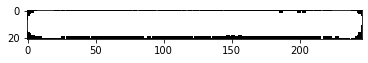

2
19 231


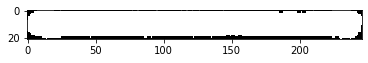

1


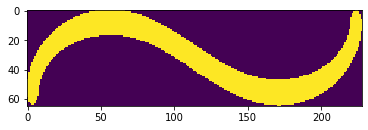

[1.20158512e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 4.95415393e-01 4.95693248e-01 4.99305363e-01
 4.99583218e-01 4.99861073e-01 4.99583218e-01 4.98471798e-01
 1.17117057e+00 1.07458811e-03 8.07057331e-03 7.15283105e-08
 1.43635185e-04 1.61134451e-07]
[1.13826547e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 1.00000000e+00 4.84023340e-01 4.93748263e-01 4.99861073e-01
 4.99861073e-01 4.99861073e-01 4.99861073e-01 4.99861073e-01
 1.26752096e+00 1.41238635e-03 1.23613176e-03 1.77629521e-06
 7.89720147e-04 1.48295287e-07]
107 173
76 188
99 157


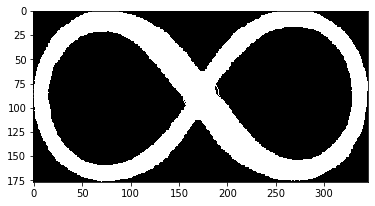

3
125 183
61 201
50 162
114 146


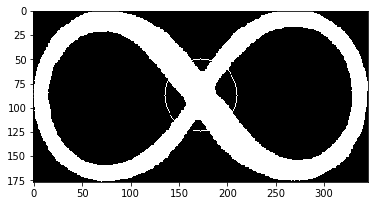

4
141 194
45 213
35 149
129 133


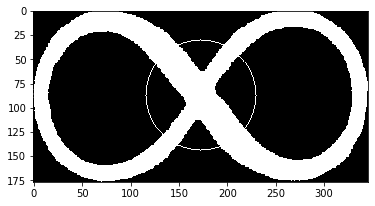

4
155 211
33 227
21 134
142 119


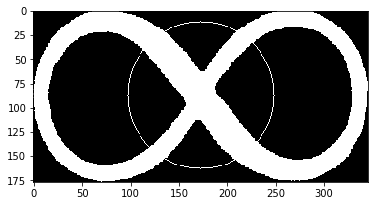

4
165 229
22 243
10 117
153 102


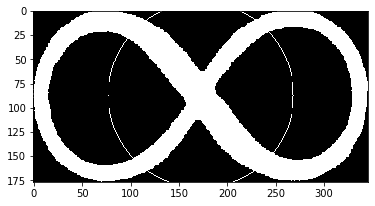

4
173 250
17 265
3 95
159 82


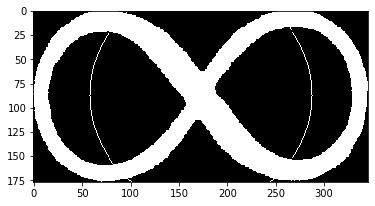

4
175 275
20 290
1 70
156 57


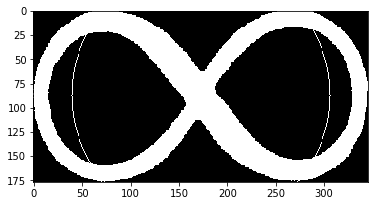

4
164 306
114 325
62 325
10 40
55 22
122 23


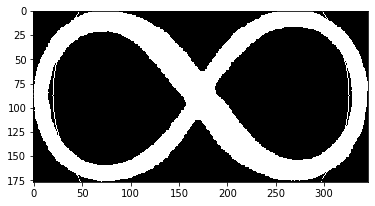

6


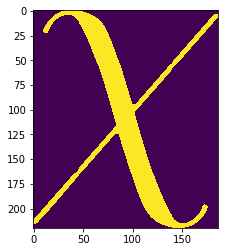

[8.64577666e-01 3.00000000e+00 5.00000000e+00 4.00000000e+00
 4.00000000e+00 4.00000000e+00 4.00000000e+00 4.00000000e+00
 5.00000000e+00 4.94303973e-01 3.82328425e-01 3.68435677e-01
 3.58155043e-01 3.52597944e-01 3.48152265e-01 3.33425952e-01
 2.62546226e-01 3.40399402e-04 4.51325541e-01 9.40164283e-08
 1.95314984e-04 1.86609445e-07]
[ 6.54205429e-01  3.00000000e+00  4.00000000e+00  4.00000000e+00
  4.00000000e+00  4.00000000e+00  4.00000000e+00  4.00000000e+00
  6.00000000e+00  4.97082523e-01  3.29258127e-01  3.21478188e-01
  2.93692692e-01  2.69797166e-01  2.64795777e-01  3.05640456e-01
  1.22222225e-01  8.70766022e-06  2.30907392e-02 -1.26916533e-10
 -2.75545282e-06 -3.26463021e-11]
19 128
1 109


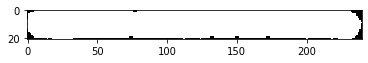

2
19 144
1 94


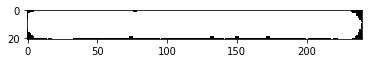

2
19 158
1 80


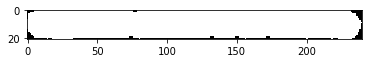

2
18 171
1 66


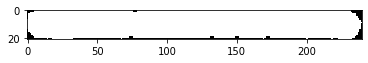

2
19 185
1 52


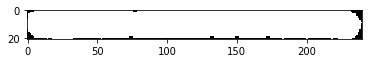

2
19 198
1 39


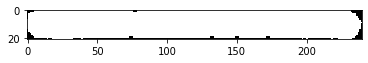

2
19 212
0 26


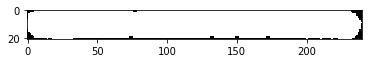

2
20 225
0 12


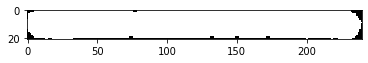

2


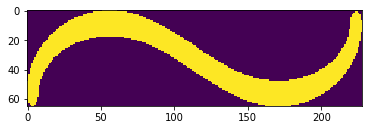

[1.19932466e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 4.98749653e-01 4.95693248e-01 4.98471798e-01
 4.98471798e-01 4.98749653e-01 4.98749653e-01 4.99027508e-01
 1.16537617e+00 3.64734339e-04 7.75155414e-03 3.97398716e-08
 1.34140954e-04 1.43537886e-08]
[1.04265706e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 4.97916088e-01 4.99305363e-01 4.99305363e-01
 4.97360378e-01 4.99583218e-01 4.99861073e-01 4.98471798e-01
 1.05897203e+00 3.05299992e-03 1.78114093e-03 3.09318810e-06
 8.40700907e-04 9.32898186e-07]


In [213]:
for i in range(0,len(imgs)):
    find_nn(imgs[i],centroids_new[i])

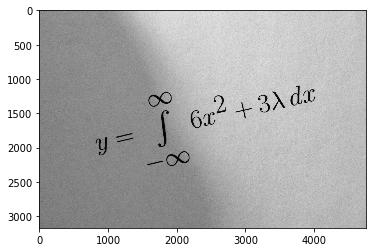

Photograph
[77, 77, 77, 77]
-13


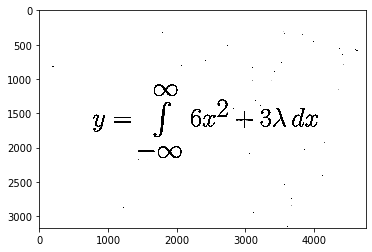

[  5040   5166   5412  33998  33998  39064  39336  40920  44929  50232
  52250  61072  61242  61250 132612]
[86.93467593539162, 173.26073400122664]
[136.26340795619262, 83.1745852794329]
[256.02139062354377, 130.78875011650666]
[158.9007261853908, 104.01623237932517]
[157.05282064928156, 99.44717935071867]
[134.27693748199363, 70.80733218092746]
[133.36944642432877, 87.47390512394077]
[121.85455187845946, 123.23271699446468]
[88.38153087321894, 94.45341614906829]
[118.38924775994997, 85.62471348197539]
[87.8370893293511, 94.66702869037908]
[10.366353543979585, 121.73654995730135]
[9.488949030220965, 122.34393324312123]
[87.40599733906447, 173.0006140620203]
[9.941435490973163, 118.66446499339509]


In [212]:
img = cv2.imread("../input/eq8_hr.jpg",0)
plt.imshow(img,cmap='gray')
plt.show()
new_img = binarize_input(img)
img_rotated = skew_correction(new_img)
plt.imshow(img_rotated,cmap='gray')
plt.show()
centroids, bboxs, convex_hulls,imgs = segmentation(img_rotated)
centroids_new = create_new_centroids(centroids, bboxs, imgs)